# Flux Calculation
1. [Basic Formulae](#Basic-Formulae)
1. [Parameters](#Introduction-of-FISS-inversion-parameters)
1. [Flux Calculator](#Flux-Calculator)
    1. [Version 1](#Flux-Calculator-ver.1)
    1. [Version 2](#Flux-Calculator-ver.2)
        1. [Kernel](#Kernel)
        1. [Modified Kernel-wavelength issue](#Modified-Kernel-wavelength-issue)
        1. [Modified Kernel-optical depth issue](#Modified-Kernel-optical-depth-issue)
    1. [Comparison btw. versions and data](#Comparison-between-each-versions-and-observed-data)
    1. [Deep Learning](#Deep-Learning)
1. [FISS data](#FISS-data)
    1. [Flux direct calculation from FISS](#Flux-direct-calculation-from-FISS)
    1. [Parameters space](#Parameter-space)
    1. [Parameters-geometry](#Parameter-geometry)

In [1]:
# FUNDMENTAL SETTING
# internal packages
from time import time
import multiprocessing as mp
from multiprocessing import Pool, Process, Queue, Manager

# numpy, matplotlib, scipy packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colors
import scipy.special as special
from scipy.special import expn
from scipy.special import wofz
from scipy import integrate, interpolate

# additional packages
import corner
from fisspy.read import FISS

# local packages
import sub4
from sub4 import fissDB

%config InlineBackend.figure_format='retina'
#%matplotlib inline

plt.rcParams['font.size'] = 15
plt.rc('legend', fontsize=12)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
#plt.rcParams['text.usetex'] = True

plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 3.5
plt.rcParams['ytick.minor.size'] = 3.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True

# Basic Formulae (based on Chae et al. 2021 in prep.)
---
According to the radiative transfer equation, the radiative flux near the solar chromospheric line (eg. Ha, Ca II 8542) is wirtten as an integration of source function,
$$
F_R(t_0) = \int F_\lambda(\tau_\lambda(t_0))d\lambda = 2\pi\int_{\lambda_0-\Delta\lambda/2}^{\lambda_0+\Delta\lambda/2} d\lambda \int_0^\infty S(t_\lambda)E_2(|t_\lambda-\tau_\lambda|)sgn(t_\lambda-\tau_\lambda)dt_\lambda.
$$

## Source function, Doppler velocity, and Doppler width
$$
\begin{align}
\text{upper chromsphere:}\quad S(x;1) &= S_0 + \frac{-S_2+4S_1-3S_0}{2}x + \frac{S_2-2S_1+S_0}{2}x^2, x\in[0,1]\\
\text{lower chromsphere:}\quad S(x;2) &= S_1 + \frac{S_2-S_0}{2}x + \frac{S_2-2S_1+S_0}{2}x^2, x\in[0,1] \\
\text{photosphere:}\quad S(x;3) &= S_2 + (S_p-S_2)x, x\in[0,\infty), \\
\\
v(x;1) &= v_0 + (v_1-v_0)x, \\
v(x;2) &= v_1 + (v_2-v_1)x, \\
v(x;3) &= v_p = v_2 \\
\\
w(x;1) &= w_0 + (w_1-w_0)x, \\
w(x;2) &= w_1 + (w_2-w_1)x, \\
w(x;3) &= w_p = w_2
\end{align}
$$

## Line profiles
$$\begin{align}
\text{upper chromsphere:}\quad r_{\lambda,1} &= H\bigg(u_{\lambda,1}=\frac{\lambda-(1+v(x;1)/c)\lambda_0}{w(x;1)},a_1=0\bigg)\bigg/H\bigg(u_{\lambda,1}=0,a_1=0\bigg) \\
\text{lower chromsphere:}\quad r_{\lambda,2} &= H\bigg(u_{\lambda,2}=\frac{\lambda-(1+v(x;2)/c)\lambda_0}{w(x;2)},a_2=\frac{\gamma x}{w(x;2)}\bigg)\bigg/H\bigg(u_{\lambda,2}=0,a_2=\frac{\gamma x}{w(x;2)}\bigg) \\
\text{photosphere:}\quad r_{\lambda,p} &= 1 + \eta H\bigg(u_{\lambda,p}=\frac{\lambda-(1+v(x;3)/c)\lambda_0}{w(x;3)},a_p\bigg)\bigg/H\bigg(u_{\lambda,p}=0,a_p\bigg) \equiv \tau_{\lambda,p}
\end{align}
$$
where the Voigt profile $H$ is defined by the real part of Faddeeva function $w(z)$,
$$
H(u,a) = H(\frac{x}{\sqrt{2}\sigma},\frac{\gamma}{\sqrt{2}\sigma}) = \sqrt{2\pi}\sigma V(x;\sigma,\gamma) = \mathfrak{R}[w(z)] = \mathfrak{R}[w(u+ia)]
$$

## Optical depth
$$\begin{align}
\text{upper chromsphere:}\quad \tau_{\lambda,1}(x) &= \int_0^x \tau_1 r_{\lambda,1}dx' \\
&\simeq \frac{\tau_1x}{2}\bigg[\frac{5}{9}r_{\lambda,1}\bigg(\frac{x'}{x}=\frac{1-\sqrt{3/5}}{2}\bigg) + \frac{8}{9}r_{\lambda,1}\bigg(\frac{x'}{x}=\frac{1}{2}\bigg) + \frac{5}{9}r_{\lambda,1}\bigg(\frac{x'}{x}=\frac{1+\sqrt{3/5}}{2}\bigg) \bigg] \\
\text{lower chromsphere:}\quad \tau_{\lambda,2}(x) &= \int_0^x \tau_2 r_{\lambda,2}dx' \\
&\simeq \frac{\tau_2x}{2}\bigg[\frac{5}{9}r_{\lambda,2}\bigg(\frac{x'}{x}=\frac{1-\sqrt{3/5}}{2}\bigg) + \frac{8}{9}r_{\lambda,1}\bigg(\frac{x'}{x}=\frac{1}{2}\bigg) + \frac{5}{9}r_{\lambda,1}\bigg(\frac{x'}{x}=\frac{1+\sqrt{3/5}}{2}\bigg) \bigg] \\
\text{photosphere:}\quad \tau_{\lambda,p}(x) &= \int_0^{x} r_{\lambda, p}dx' = \tau_{\lambda,p}x
\end{align}
$$

## Radiative Flux
Then radiative energy flux can be calculated. (+sign means upward energy flux)
$$
F_{R,i} = \sum_j F_{R,i,j} \quad\text{for}\;  i = 0,1,2
$$
where
$$\begin{align}
F_{R,0,0} &= 2\pi\int d\lambda \int_0^1 S(x;1)E_2[\tau_{\lambda,1}(x)] \tau_1r_{\lambda,1}(x)dx, &F_{R,0,0} &= 2\pi\int d\lambda \int_0^1 S(x;1)E_2[\tau_{\lambda,1}(x)] \tau_1r_{\lambda,1}(x)dx,\\
F_{R,0,1} &= 2\pi\int d\lambda \int_0^1 S(x;2)E_2[\tau_{\lambda,1}+\tau_{\lambda,2}(x)] \tau_2r_{\lambda,2}(x)dx, &F_{R,1,0} &= -2\pi\int d\lambda \int_0^1 S(x;1)E_2[\tau_{\lambda,1}-\tau_{\lambda,1}(x)] \tau_1r_{\lambda,1}(x)dx,\\
F_{R,0,2} &= 2\pi\int d\lambda \int_0^\infty S(x;3)E_2[\tau_{\lambda,1}+\tau_{\lambda,2}+\tau_{\lambda,p}x] r_{\lambda,p}dx, &F_{R,2,0} &= -2\pi\int d\lambda \int_0^1 S(x;1)E_2[\tau_{\lambda,1}-\tau_{\lambda,1}(x) + \tau_{\lambda,2}] \tau_1r_{\lambda,1}(x)dx,\\ 
\\
F_{R,1,0} &= -2\pi\int d\lambda \int_0^1 S(x;1)E_2[\tau_{\lambda,1}-\tau_{\lambda,1}(x)] \tau_1r_{\lambda,1}(x)dx, &F_{R,0,1} &= 2\pi\int d\lambda \int_0^1 S(x;2)E_2[\tau_{\lambda,1}+\tau_{\lambda,2}(x)] \tau_2r_{\lambda,2}(x)dx,\\
F_{R,1,1} &= 2\pi\int d\lambda \int_0^1 S(x;2)E_2[\tau_{\lambda,2}(x)] \tau_2r_{\lambda,2}(x)dx, &F_{R,1,1} &= 2\pi\int d\lambda \int_0^1 S(x;2)E_2[\tau_{\lambda,2}(x)] \tau_2r_{\lambda,2}(x)dx,\\
F_{R,1,2} &= 2\pi\int d\lambda \int_0^\infty S(x;3)E_2[\tau_{\lambda,2}+\tau_{\lambda,p}x] r_{\lambda,p}dx, &F_{R,2,1} &= -2\pi\int d\lambda \int_0^1 S(x;2)E_2[\tau_{\lambda,2}-\tau_{\lambda,2}(x)] \tau_2r_{\lambda,2}(x)dx,\\ 
\\
F_{R,2,0} &= -2\pi\int d\lambda \int_0^1 S(x;1)E_2[\tau_{\lambda,1}-\tau_{\lambda,1}(x) + \tau_{\lambda,2}] \tau_1r_{\lambda,1}(x)dx, &F_{R,0,2} &= 2\pi\int d\lambda \int_0^\infty S(x;3)E_2[\tau_{\lambda,1}+\tau_{\lambda,2}+\tau_{\lambda,p}x] r_{\lambda,p}dx,\\
F_{R,2,1} &= -2\pi\int d\lambda \int_0^1 S(x;2)E_2[\tau_{\lambda,2}-\tau_{\lambda,2}(x)] \tau_2r_{\lambda,2}(x)dx, &F_{R,1,2} &= 2\pi\int d\lambda \int_0^\infty S(x;3)E_2[\tau_{\lambda,2}+\tau_{\lambda,p}x] r_{\lambda,p}dx,\\
F_{R,2,2} &= 2\pi\int d\lambda \int_0^\infty S(x;3)E_2[\tau_{\lambda,p}x] r_{\lambda,p}dx. &F_{R,2,2} &= 2\pi\int d\lambda \int_0^\infty S(x;3)E_2[\tau_{\lambda,p}x] r_{\lambda,p}dx.
\end{align}
$$

## Radiative Loss

Radiative loss at the upper chromosphere:
$$\begin{align}
\Delta F_{R,uc} &= 2\pi\int d\lambda \int_0^1 S(x;1)\bigg(E_2[\tau_{\lambda,1}(x)] + E_2[\tau_{\lambda,1}-\tau_{\lambda,1}(x)]\bigg) \tau_1r_{\lambda,1}(x)dx \\
&+ 2\pi\int d\lambda \int_0^1 S(x;2)\bigg(E_2[\tau_{\lambda,1}+\tau_{\lambda,2}(x)] - E_2[\tau_{\lambda,2}(x)]\bigg) \tau_2r_{\lambda,2}(x)dx \\
&+ 2\pi\int d\lambda \int_0^\infty S(x;3)\bigg(E_2[\tau_{\lambda,1}+\tau_{\lambda,2}+\tau_{\lambda,p}x] - E_2[\tau_{\lambda,2}+\tau_{\lambda,p}x]\bigg) r_{\lambda,p}dx
\end{align}
$$
Radiative loss at the lower chromosphere:
$$\begin{align}
\Delta F_{R,lc} &= 2\pi\int d\lambda \int_0^1 S(x;1)\bigg(E_2[\tau_{\lambda,1}-\tau_{\lambda,1}(x)+\tau_{\lambda,2}] - E_2[\tau_{\lambda,1}-\tau_{\lambda,1}(x)]\bigg) \tau_1r_{\lambda,1}(x)dx \\
&+ 2\pi\int d\lambda \int_0^1 S(x;2)\bigg(E_2[\tau_{\lambda,2}(x)] + E_2[\tau_{\lambda,2}-\tau_{\lambda,2}(x)]\bigg) \tau_2r_{\lambda,2}(x)dx \\
&+ 2\pi\int d\lambda \int_0^\infty S(x;3)\bigg(E_2[\tau_{\lambda,2}+\tau_{\lambda,p}x] - E_2[\tau_{\lambda,p}x]\bigg) r_{\lambda,p}dx
\end{align}
$$

## Appendix: Exponential Integrals

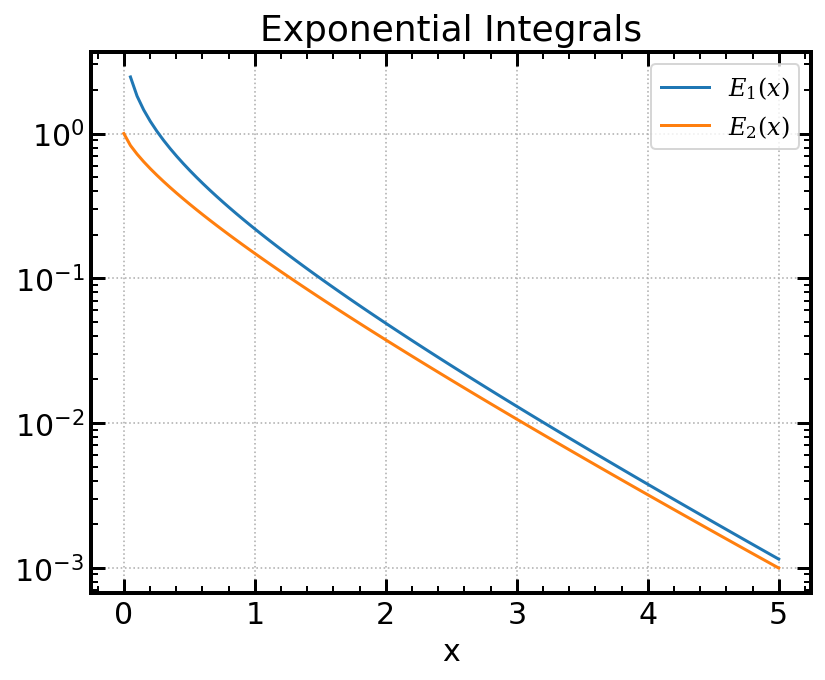

In [2]:
# Exponetial Integrals
e1 = lambda x: special.exp1(x)
e2 = lambda x: special.expn(2,x)

fig = plt.figure(figsize=(6,5))

x = np.linspace(0,5,100)

plt.plot(x,e1(x), label=r'$E_1(x)$')
plt.plot(x,e2(x), label=r'$E_2(x)$')

plt.title('Exponential Integrals')
plt.xlabel(r'x')
plt.yscale('log')
plt.grid(ls=':')
plt.legend()

fig.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=300)
plt.show()

## Appendix: Shape of Source function

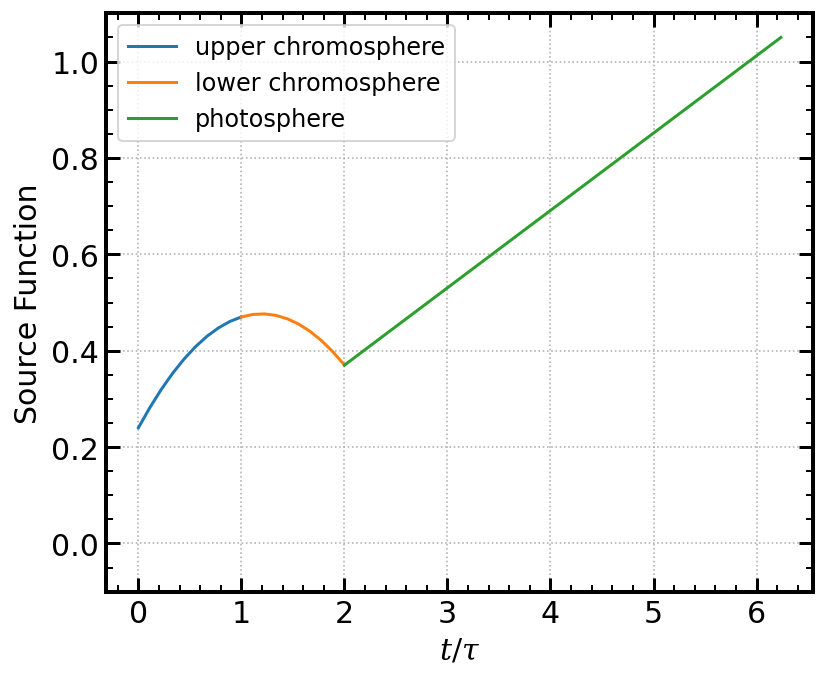

In [3]:
# Source Functions
S0 = 0.24
S1 = 0.47
S2 = 0.37
Sp = 1.05
eta = 10**0.51

s1 = lambda x: S0 + (-3*S0+4*S1-S2)/2 * x + (S0-2*S1+S2)/2 * x**2
s2 = lambda x: S1 + (-S0+S2)/2 * x + (S0-2*S1+S2)/2 * x**2
s3 = lambda x: S2 + (Sp-S2) * x

fig = plt.figure(figsize=(6,5))

x = np.linspace(0,1,10)

plt.plot(x,s1(x), label='upper chromosphere')
plt.plot(1+x,s2(x), label='lower chromosphere')
plt.plot(2+(1+eta)*x,s3(x), label='photosphere')

plt.ylim(-0.1,1.1)
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'Source Function')
plt.grid(ls=':')
plt.legend()

fig.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=300)
plt.show()

## Appendix: Gaussian Quadrature

In [24]:
def tau_quad(optical_depth, wavelength, num=3):
    if num==3:
        points = [(1-np.sqrt(3/5))/2, 1/2, (1+np.sqrt(3/5))/2]
        weights = [5/9, 8/9, 5/9]
    elif num==5:
        points = [(1-0.90618)/2, (1-0.53847)/2, 1/2, (1+0.53847)/2, (1+0.90618)/2]
        weights = [0.236927, 0.478629, 0.568889, 0.478629, 0.236927]
    else:
        raise NameError('Wrong num inputted!')
    
    v0, v1 = 20, -4 # in km/s
    w0, w1 = 0.02, 0.025 # in nm
    
    vx = lambda x: v0 + (v1-v0)*x
    wx = lambda x: w0 + (w1-w0)*x
    
    def u(wv, v, w):
        wv0 = 656.3 # Ha, in nm
        c = 3e5 # in km/s
        return (wv - (1+v/c)*wv0)/w
    
    # lower chromosphere
    r = lambda x, y: wofz(u(y,vx(x),wx(x))).real / wofz(0).real
    
    output = 0
    for point, weight in zip(points, weights):
        output += weight * r(point*optical_depth, wavelength)
    output = optical_depth/2 * output
    
    return output

In [63]:
def tau_intg(optical_depth, wavelength):
    v0, v1 = 20, -4 # in km/s
    w0, w1 = 0.02, 0.025 # in nm
    
    vx = lambda x: v0 + (v1-v0)*x
    wx = lambda x: w0 + (w1-w0)*x
    
    def u(wv, v, w):
        wv0 = 656.3 # Ha, in nm
        c = 3e5 # in km/s
        return (wv - (1+v/c)*wv0)/w
    
    # lower chromosphere
    r = lambda x, y: wofz(u(y,vx(x),wx(x))).real / wofz(0).real
    
    output1, output2 = integrate.quad(r, 0, optical_depth, args=(wavelength,))
    
    return output1

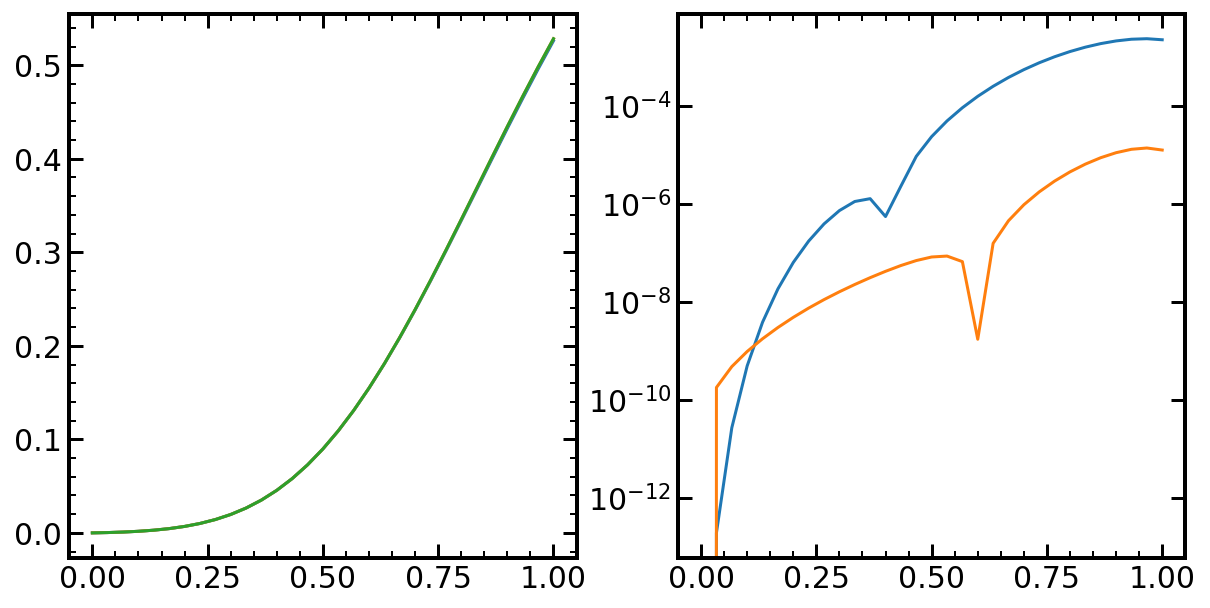

In [74]:
x = np.linspace(0,1, 31)
wavelength = 656.3 # in nm

result3 = []
result5 = []
resulti = []
for xx in x:
    result3.append(tau_quad(xx, wavelength, num=3))
    result5.append(tau_quad(xx, wavelength, num=5))
    resulti.append(tau_intg(xx, wavelength))

result3 = np.array(result3)
result5 = np.array(result5)
resulti = np.array(resulti)
    
fig, ax = plt.subplots(1,2, figsize=(10,5))
    
ax[0].plot(x, result3)
ax[0].plot(x, result5)
ax[0].plot(x, resulti)
    
ax[1].semilogy(x, abs(result3-resulti))
ax[1].semilogy(x, abs(result5-resulti))

plt.show()

# Introduction of FISS inversion parameters
---
## input
an array containing 17 parameters.
- parameter[0] : vp [km/s]
- parameter[1] : log eta [ ]
- parameter[2] : log wp [$\mathring A$]  
- parameter[3] : log a [ ]  
- parameter[4] : log Sp [?]  
- parameter[5] : log S2 [?]  
- parameter[6] : log tau2 [ ]  
- parameter[7] : log tau1 [ ]  
- parameter[8] : v2 [km/s]  
- parameter[9] : v1 [km/s]  
- parameter[10] : log w2 [$\mathring A$]  
- parameter[11] : log w1 [$\mathring A$]  
- parameter[12] : log S1 [?]  
- parameter[13] : log S0 [?]  
- parameter[14] : epsD [ ]  
- parameter[15] : epsC [ ]  
- parameter[16] : log Icenter [?]

## output
Flux and corresponding errors with 9 elements.

# Flux Calculator

## ver.1 - nquad

In [2]:
def flux_calculator(pars, line='Ha', int_bin_size=2, calc_option='bundle'):  
    # source function, [S] = ?
    s0 = 10**pars[13]
    s1 = 10**pars[12]
    s2 = 10**pars[5]
    sp = 10**pars[4]

    S1 = lambda x: s0 + (-3*s0+4*s1-s2)/2 * x + (s0-2*s1+s2)/2 * x**2
    S2 = lambda x: s1 + (-s0+s2)/2 * x        + (s0-2*s1+s2)/2 * x**2
    S3 = lambda x: s2 + (sp-s2) * x

    # Doppler shift, [v] = km/s
    v0 = pars[9]
    v1 = pars[8]
    v2 = pars[0]
    vp = v2
    
    V1 = lambda x: v0 + (v1-v0)*x
    V2 = lambda x: v1 + (v2-v1)*x
    V3 = lambda x: v2
    
    # Doppelr width, [w] = nm
    w0 = 10**(pars[11]-1)
    w1 = 10**(pars[10]-1)
    w2 = 10**(pars[2]-1)
    wp = w2
    
    W1 = lambda x: w0 + (w1-w0)*x
    W2 = lambda x: w1 + (w2-w1)*x
    W3 = lambda x: w2
    
    # Other parameters, [a]&[eta]&[tau] = None
    a1 = 0.0
    a2 = lambda x: pars[14]/10*x/W2(x)
    ap = 10**pars[3]
    eta = 10**pars[1]
    tau = 5.0
    c = 3e5 # km/s
    
    # different parameters of given line
    if line == 'Ha':
        line_center = 656.2817 # nm
        flux_factor = 28.5/1.05 # kW m-2 sr-1 nm-1
    elif line == 'Ca':
        line_center = 854.2091 # nm
        flux_factor = 17.6/1.05 # kW m-2 sr-1 nm-1
    else:
        raise NameError('Wrong line inputting.')
    
    # Line profiles & optical depth
    def u(wavelength, velocity, width):
        return (wavelength - (1+velocity/c)*line_center)/width
    
    r1 = lambda x, y: wofz(u(y,V1(x),W1(x)) + a1*1j).real    / wofz(a1*1j).real
    r2 = lambda x, y: wofz(u(y,V2(x),W2(x)) + a2(x)*1j).real / wofz(a2(x)*1j).real
    rp = lambda x, y: wofz(u(y,V3(x),W3(x)) + ap*1j).real    / wofz(ap*1j).real * eta + 1
    
    t1 = lambda x, y: tau * x/2 * (5/9*r1(x*(1-np.sqrt(3/5))/2,y) + 8/9*r1(x/2,y) + 5/9*r1(x*(1+np.sqrt(3/5))/2,y))
    t2 = lambda x, y: tau * x/2 * (5/9*r2(x*(1-np.sqrt(3/5))/2,y) + 8/9*r2(x/2,y) + 5/9*r2(x*(1+np.sqrt(3/5))/2,y))
    tp = lambda x, y: x * rp(x,y)

    E2 = lambda x: special.expn(2,x)
    
    # integration range [nm], default bin size = 2nm
    int_bin = [line_center-int_bin_size/2, line_center+int_bin_size/2]

#     # Flux_0: flux to top plane of chromosphere
#     f00 = lambda x, y: S1(x) * E2(t1(x,y)                    ) * r1(x,y) * tau
#     f01 = lambda x, y: S2(x) * E2(t1(1,y) + t2(x,y)          ) * r2(x,y) * tau
#     f02 = lambda x, y: S3(x) * E2(t1(1,y) + t2(1,y) + tp(x,y)) * rp(x,y)
    
#     # Flux_1: flux to mid plane of chromosphere
#     f10 = lambda x, y: S1(x) * -E2(t1(1,y) - t1(x,y)) * r1(x,y) * tau
#     f11 = lambda x, y: S2(x) *  E2(t2(x,y)          ) * r2(x,y) * tau
#     f12 = lambda x, y: S3(x) *  E2(t2(1,y) + tp(x,y)) * rp(x,y)
    
#     # Flux_2: flux to bottom plane of chromosphere
#     f20 = lambda x, y: S1(x) * -E2(t1(1,y) - t1(x,y) + t2(1,y)) * r1(x,y) * tau
#     f21 = lambda x, y: S2(x) * -E2(t2(1,y) - t2(x,y)          ) * r2(x,y) * tau
#     f22 = lambda x, y: S3(x) *  E2(tp(x,y)                    ) * rp(x,y)
    
    # flux from upper chromosphere
    f00 = lambda x, y: S1(x) *  E2(t1(x,y)                    ) * r1(x,y) * tau
    f10 = lambda x, y: S1(x) * -E2(t1(1,y) - t1(x,y)          ) * r1(x,y) * tau
    f20 = lambda x, y: S1(x) * -E2(t1(1,y) - t1(x,y) + t2(1,y)) * r1(x,y) * tau
    
    # flux from lower chromosphere
    f01 = lambda x, y: S2(x) *  E2(t1(1,y) + t2(x,y)) * r2(x,y) * tau
    f11 = lambda x, y: S2(x) *  E2(t2(x,y)          ) * r2(x,y) * tau
    f21 = lambda x, y: S2(x) * -E2(t2(1,y) - t2(x,y)) * r2(x,y) * tau
    
    # flux from photosphere
    f02 = lambda x, y: S3(x) * E2(t1(1,y) + t2(1,y) + tp(x,y)) * rp(x,y)
    f12 = lambda x, y: S3(x) * E2(          t2(1,y) + tp(x,y)) * rp(x,y)
    f22 = lambda x, y: S3(x) * E2(                    tp(x,y)) * rp(x,y)

    # Calculation part
    FR, ERR = np.zeros((3,3)), np.zeros((3,3))
   
    FR[0,0], ERR[0,0] = integrate.nquad(f00, [[0,1],int_bin])
    FR[0,1], ERR[0,1] = integrate.nquad(f01, [[0,1],int_bin]) 
    FR[0,2], ERR[0,2] = integrate.nquad(f02, [[0,np.inf],int_bin])
    
    FR[1,0], ERR[1,0] = integrate.nquad(f10, [[0,1],int_bin])
    FR[1,1], ERR[1,1] = integrate.nquad(f11, [[0,1],int_bin])
    FR[1,2], ERR[1,2] = integrate.nquad(f12, [[0,np.inf],int_bin])

    FR[2,0], ERR[2,0] = integrate.nquad(f20, [[0,1],int_bin])
    FR[2,1], ERR[2,1] = integrate.nquad(f21, [[0,1],int_bin])
    FR[2,2], ERR[2,2] = integrate.nquad(f22, [[0,np.inf],int_bin])
    
    if calc_option == 'bundle':
        FR, ERR = FR @ np.ones(3), ERR @ np.ones(3)
    elif calc_option == 'each':
        pass
    else:
        raise NameError('Wrong calculation option iputted!')

    # [F_R] = kW/m^2
    FR = 2*np.pi * FR * flux_factor
    ERR = 2*np.pi * ERR * flux_factor
    
    return FR, ERR

### test

In [3]:
parHa = np.array([-0.395 ,  0.4923, -0.644 ,  0.4858, -0.004 ,
                  -0.1789,  0.699 ,  0.699 , -0.5748, -0.404 , 
                  -0.3948,  0.3964, -0.3125, -0.5347,  0.144 ])
parCa = np.array([-0.75  ,  0.3741, -1.268 ,  1.295 , -0.0092,
                  -0.3656,  0.699 ,  0.699 ,  0.8927, -3.5456, 
                  -0.6919, -0.6911, -0.1665, -0.3544,  0.271 ])

### 2nm 

In [4]:
t1 = time()
fr_Ha, err_Ha = flux_calculator(parHa, line='Ha')
t2 = time()
fr_Ca, err_Ca = flux_calculator(parCa, line='Ca')
t3 = time()

print(f'Flux and error of Ha line: Time for one calc. = {(t2-t1):.3f} [sec]')
print(fr_Ha, err_Ha, '\n')

print(f'Flux and error of Ca II line: Time for one calc. = {(t3-t2):.3f} [sec]')
print(fr_Ca, err_Ca)

/data/home/sskang/.conda/envs/tf2/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Flux and error of Ha line: Time for one calc. = 23.134 [sec]
[122.76660364          nan 123.48034447] [6.10519747e-06 7.32494728e-06 7.11536612e-06] 

Flux and error of Ca II line: Time for one calc. = 26.885 [sec]
[76.46298797         nan 71.83974127] [3.16884026e-06 4.61296071e-06 2.92387325e-06]


### 1nm

In [14]:
t1 = time()
fr_Ha, err_Ha = flux_calculator(parHa, line='Ha', int_bin_size=1)
t2 = time()
fr_Ca, err_Ca = flux_calculator(parCa, line='Ca', int_bin_size=1)
t3 = time()

print(f'Flux and error of Ha line: Time for one calc. = {(t2-t1):.3f} [sec]')
print(fr_Ha, err_Ha, '\n')

print(f'Flux and error of Ca II line: Time for one calc. = {(t3-t2):.3f} [sec]')
print(fr_Ca, err_Ca)

Flux and error of Ha line: Time for one calc. = 18.214 [sec]
[48.31538389 49.15755926 49.10640723] [6.10519685e-06 7.56297985e-06 7.06907491e-06] 

Flux and error of Ca II line: Time for one calc. = 15.836 [sec]
[35.52224287 33.63706072 31.01422327] [3.16480905e-06 4.55594761e-06 2.91187068e-06]


In [44]:
pars = parHa
line = 'Ha'
int_bin_size = 2
calc_option = 'bundle'

# source function, [S] = ?
s0 = 10**pars[13]
s1 = 10**pars[12]
s2 = 10**pars[5]
sp = 10**pars[4]

S1 = lambda x: s0 + (-3*s0+4*s1-s2)/2 * x + (s0-2*s1+s2)/2 * x**2
S2 = lambda x: s1 + (-s0+s2)/2 * x        + (s0-2*s1+s2)/2 * x**2
S3 = lambda x: s2 + (sp-s2) * x

# Doppler shift, [v] = km/s
v0 = pars[9]
v1 = pars[8]
v2 = pars[0]
vp = v2

V1 = lambda x: v0 + (v1-v0)*x
V2 = lambda x: v1 + (v2-v1)*x
V3 = lambda x: v2

# Doppelr width, [w] = nm
w0 = 10**(pars[11]-1)
w1 = 10**(pars[10]-1)
w2 = 10**(pars[2]-1)
wp = w2

W1 = lambda x: w0 + (w1-w0)*x
W2 = lambda x: w1 + (w2-w1)*x
W3 = lambda x: w2

# Other parameters, [a]&[eta]&[tau] = None
a1 = 0.0
a2 = lambda x: pars[14]/10*x/W2(x)
ap = 10**pars[3]
eta = 10**pars[1]
tau = 5.0
c = 3e5 # km/s

# different parameters of given line
if line == 'Ha':
    line_center = 656.2817 # nm
    flux_factor = 28.5/1.05 # kW m-2 sr-1 nm-1
elif line == 'Ca':
    line_center = 854.2091 # nm
    flux_factor = 17.6/1.05 # kW m-2 sr-1 nm-1
else:
    raise NameError('Wrong line inputting.')

# Line profiles & optical depth
def u(wavelength, velocity, width):
    return (wavelength - (1+velocity/c)*line_center)/width

r1 = lambda x, y: wofz(u(y,V1(x),W1(x)) + a1*1j).real    / wofz(a1*1j).real
r2 = lambda x, y: wofz(u(y,V2(x),W2(x)) + a2(x)*1j).real / wofz(a2(x)*1j).real
rp = lambda x, y: wofz(u(y,V3(x),W3(x)) + ap*1j).real    / wofz(ap*1j).real * eta + 1

t1 = lambda x, y: tau * x/2 * (5/9*r1(x*(1-np.sqrt(3/5))/2,y) + 8/9*r1(x/2,y) + 5/9*r1(x*(1+np.sqrt(3/5))/2,y))
# t1 = lambda x, y: tau * x/2 * (0.2369*r1(x*(1-0.9062)/2,y) + 0.4786*r1(x*(1-0.5385)/2,y) + 0.5689*r1(x/2,y) + 0.4786*r1(x*(1+0.5385)/2,y) + 0.2369*r1(x*(1+0.9062)/2,y))
t2 = lambda x, y: tau * x/2 * (5/9*r2(x*(1-np.sqrt(3/5))/2,y) + 8/9*r2(x/2,y) + 5/9*r2(x*(1+np.sqrt(3/5))/2,y))
tp = lambda x, y: x * rp(x,y)

E2 = lambda x: special.expn(2,x)

# integration range [nm], default bin size = 2nm
int_bin = [line_center-int_bin_size/2, line_center+int_bin_size/2]

#     # Flux_0: flux to top plane of chromosphere
#     f00 = lambda x, y: S1(x) * E2(t1(x,y)                    ) * r1(x,y) * tau
#     f01 = lambda x, y: S2(x) * E2(t1(1,y) + t2(x,y)          ) * r2(x,y) * tau
#     f02 = lambda x, y: S3(x) * E2(t1(1,y) + t2(1,y) + tp(x,y)) * rp(x,y)

#     # Flux_1: flux to mid plane of chromosphere
#     f10 = lambda x, y: S1(x) * -E2(t1(1,y) - t1(x,y)) * r1(x,y) * tau
#     f11 = lambda x, y: S2(x) *  E2(t2(x,y)          ) * r2(x,y) * tau
#     f12 = lambda x, y: S3(x) *  E2(t2(1,y) + tp(x,y)) * rp(x,y)

#     # Flux_2: flux to bottom plane of chromosphere
#     f20 = lambda x, y: S1(x) * -E2(t1(1,y) - t1(x,y) + t2(1,y)) * r1(x,y) * tau
#     f21 = lambda x, y: S2(x) * -E2(t2(1,y) - t2(x,y)          ) * r2(x,y) * tau
#     f22 = lambda x, y: S3(x) *  E2(tp(x,y)                    ) * rp(x,y)

# flux from upper chromosphere
f00 = lambda x, y: S1(x) *  E2(t1(x,y)                    ) * r1(x,y) * tau
f10 = lambda x, y: S1(x) * -E2(t1(1,y) - t1(x,y)          ) * r1(x,y) * tau
f20 = lambda x, y: S1(x) * -E2(t1(1,y) - t1(x,y) + t2(1,y)) * r1(x,y) * tau

# flux from lower chromosphere
f01 = lambda x, y: S2(x) *  E2(t1(1,y) + t2(x,y)) * r2(x,y) * tau
f11 = lambda x, y: S2(x) *  E2(t2(x,y)          ) * r2(x,y) * tau
f21 = lambda x, y: S2(x) * -E2(t2(1,y) - t2(x,y)) * r2(x,y) * tau

# flux from photosphere
f02 = lambda x, y: S3(x) * E2(t1(1,y) + t2(1,y) + tp(x,y)) * rp(x,y)
f12 = lambda x, y: S3(x) * E2(          t2(1,y) + tp(x,y)) * rp(x,y)
f22 = lambda x, y: S3(x) * E2(                    tp(x,y)) * rp(x,y)

# # Calculation part
# FR, ERR = np.zeros((3,3)), np.zeros((3,3))

# FR[0,0], ERR[0,0] = integrate.nquad(f00, [[0,1],int_bin])
# FR[0,1], ERR[0,1] = integrate.nquad(f01, [[0,1],int_bin]) 
# FR[0,2], ERR[0,2] = integrate.nquad(f02, [[0,np.inf],int_bin])

# FR[1,0], ERR[1,0] = integrate.nquad(f10, [[0,1],int_bin])
# FR[1,1], ERR[1,1] = integrate.nquad(f11, [[0,1],int_bin])
# FR[1,2], ERR[1,2] = integrate.nquad(f12, [[0,np.inf],int_bin])

# FR[2,0], ERR[2,0] = integrate.nquad(f20, [[0,1],int_bin])
# FR[2,1], ERR[2,1] = integrate.nquad(f21, [[0,1],int_bin])
# FR[2,2], ERR[2,2] = integrate.nquad(f22, [[0,np.inf],int_bin])

# if calc_option == 'bundle':
#     FR, ERR = FR @ np.ones(3), ERR @ np.ones(3)
# elif calc_option == 'each':
#     pass
# else:
#     raise NameError('Wrong calculation option iputted!')

# # [F_R] = kW/m^2
# FR = 2*np.pi * FR * flux_factor
# ERR = 2*np.pi * ERR * flux_factor

In [5]:
integrate.nquad(f10, [[0,1], int_bin])

/data/home/sskang/.conda/envs/tf2/lib/python3.8/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


(nan, 1.3356200716460294e-08)

In [11]:
t1(0.3, 656.3)

1.4880888392070832

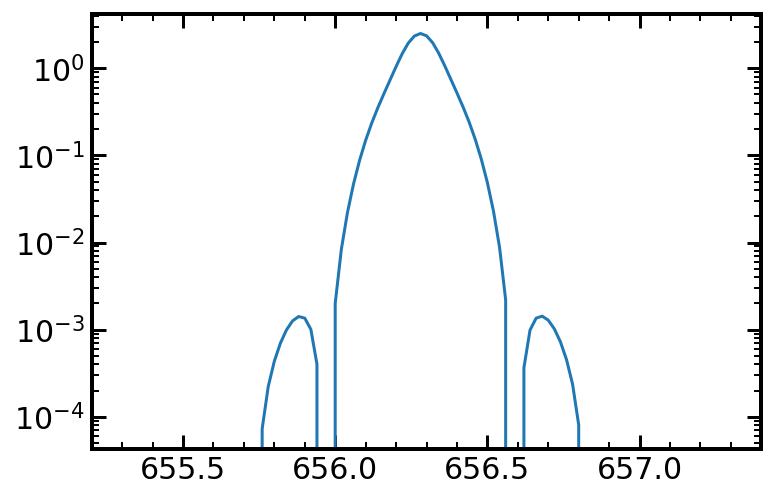

In [48]:
y = np.linspace(655.3, 657.3, 101)
x = t1(1, y) - t1(1-0.5, y)

plt.semilogy(y, x)

/data/home/sskang/.conda/envs/tf2/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


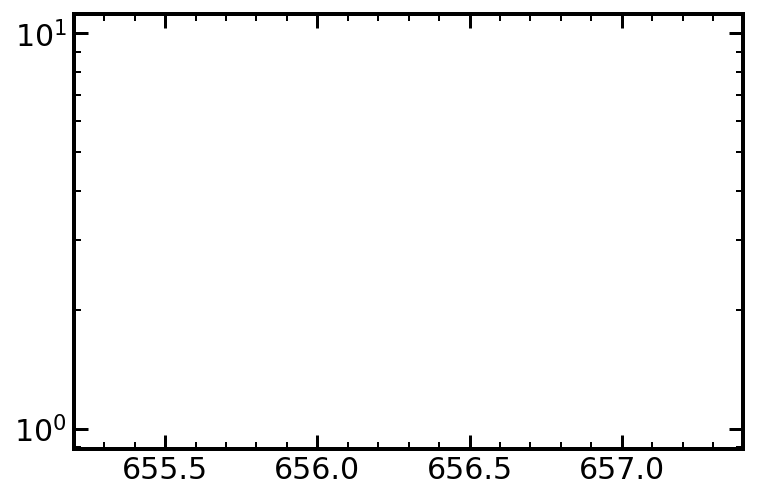

In [55]:
x = np.linspace(0, 1, 101)
y = np.linspace(655.3, 657.3, 101)

#plt.semilogy(y, r1(0,y))
#plt.semilogy(y, np.exp(-y**2), color='C1')

# Flux Calculator (old)
---
## Flux Calculator ver.1
Exact calculation based on the double integraion.

In [2]:
def flux_calculator(pars, line='Ha', epsabs=1.49e-8, epsrel=1.49e-8, int_bin_size=1, calc_option='bundle'):
    e2 = lambda x: special.expn(2,x)
    
    # [S] = ?
    S0 = 10**pars[13]
    S1 = 10**pars[12]
    S2 = 10**pars[5]
    Sp = 10**pars[4]

    s1 = lambda x: S0 + (-3*S0+4*S1-S2)/2 * x + (S0-2*S1+S2)/2 * x**2
    s2 = lambda x: S1 + (-S0+S2)/2 * x        + (S0-2*S1+S2)/2 * x**2
    s3 = lambda x: S2 + (Sp-S2) * x

    # [v] = km/s, [w] = nm, [a]&[eta]&[tau] = None
    v1 = pars[9]
    w1 = 10**(pars[11]-1)
    a1 = 0.0
    
    v2 = pars[8]
    w2 = 10**(pars[10]-1)
    a2 = 0.3
    
    vp = pars[0]
    wp = 10**(pars[2]-1)
    ap = 10**pars[3]
    eta = 10**pars[1]
    
    tau = 5.0
    c = 3e5 # km/s
    
    # different parameters of given line
    if line == 'Ha':
        wv0 = 656.3 # nm
        factor = 28.5/1.05 # kW m-2 sr-1 nm-1
    elif line == 'Ca':
        wv0 = 854.2 # nm
        factor = 17.6/1.05 # kW m-2 sr-1 nm-1
    else:
        raise NameError('Wrong line inputting.')
        
    # integration range [nm], default bin size = 1nm
    int_bin = [wv0-int_bin_size/2, wv0+int_bin_size/2]
    
    def u(wv, v, w):
        return (wv - (1+v/c)*wv0)/w

    h1 = lambda y: tau * wofz(u(y,v1,w1) + a1*1j).real / wofz(a1*1j).real
    h2 = lambda y: tau * wofz(u(y,v2,w2) + a2*1j).real / wofz(a2*1j).real
    hp = lambda y: eta * wofz(u(y,vp,wp) + ap*1j).real / wofz(ap*1j).real + 1

    # Flux_0
    f00 = lambda x,y: s1(x) * e2(x*h1(y)                ) * h1(y)
    f01 = lambda x,y: s2(x) * e2(h1(y) + x*h2(y)        ) * h2(y)
    f02 = lambda x,y: s3(x) * e2(h1(y) + h2(y) + x*hp(y)) * hp(y)
    
    # Flux_1
    f10 = lambda x,y: s1(x) * -e2((1-x)*h1(y)    ) * h1(y)
    f11 = lambda x,y: s2(x) *  e2(x*h2(y)        ) * h2(y)
    f12 = lambda x,y: s3(x) *  e2(h2(y) + x*hp(y)) * hp(y)
    
    # Flux_2
    f20 = lambda x,y: s1(x) * -e2((1-x)*h1(y) + h2(y)) * h1(y)
    f21 = lambda x,y: s2(x) * -e2(        (1-x)*h2(y)) * h2(y)
    f22 = lambda x,y: s3(x) *  e2(            x*hp(y)) * hp(y)

    # Calculation part
    FR, ERR = np.zeros((3,3)), np.zeros((3,3))
    opts = [{'epsabs':epsabs,'epsrel':epsrel},{'epsabs':epsabs,'epsrel':epsrel}]
   
    FR[0,0], ERR[0,0] = integrate.nquad(f00, [[0,1],int_bin], opts=opts)
    FR[0,1], ERR[0,1] = integrate.nquad(f01, [[0,1],int_bin], opts=opts) 
    FR[0,2], ERR[0,2] = integrate.nquad(f02, [[0,np.inf],int_bin], opts=opts)
    
    FR[1,0], ERR[1,0] = integrate.nquad(f10, [[0,1],int_bin], opts=opts)
    FR[1,1], ERR[1,1] = integrate.nquad(f11, [[0,1],int_bin], opts=opts)
    FR[1,2], ERR[1,2] = integrate.nquad(f12, [[0,np.inf],int_bin], opts=opts)

    FR[2,0], ERR[2,0] = integrate.nquad(f20, [[0,1],int_bin], opts=opts)
    FR[2,1], ERR[2,1] = integrate.nquad(f21, [[0,1],int_bin], opts=opts)
    FR[2,2], ERR[2,2] = integrate.nquad(f22, [[0,np.inf],int_bin], opts=opts)
    
    if calc_option == 'bundle':
        FR, ERR = FR @ np.ones(3), ERR @ np.ones(3)
    elif calc_option == 'each':
        pass
    else:
        raise NameError('Wrong calculation option iputted!')

    # [F_R] = kW/m^2
    FR = 2*np.pi * FR * factor
    ERR = 2*np.pi * ERR * factor
    
    return FR, ERR

### As a function of $\Delta\lambda$

In [6]:
# wavelength [nm]
integration_binsize = np.linspace(0.1,10, 100)
#print(integration_binsize)

params_Ha = db.parHa[:,195,74]
params_Ca = db.parCa[:,195,74]
FR_Ha = []
FR_Ca = []

for idx, int_binsize in enumerate(integration_binsize):
    print(idx)
    fr_Ha, err_Ha = flux_calculator(params_Ha, line='Ha', int_bin_size=int_binsize)
    fr_Ca, err_Ca = flux_calculator(params_Ca, line='Ca', int_bin_size=int_binsize)
    
    FR_Ha.append(fr_Ha)
    FR_Ca.append(fr_Ca)
    
FR_Ha = np.array(FR_Ha)
FR_Ca = np.array(FR_Ca)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [25]:
def fplot(dwv, fr, line='Ha'):
    fig, ax = plt.subplots(1,2, figsize=(10,6))

    ax[0].plot(dwv, fr[:,0], label='$F_0$')
    ax[0].plot(dwv, fr[:,1], label='$F_1$')
    ax[0].plot(dwv, fr[:,2], label='$F_2$')
    ax[0].set(xlabel='$\Delta\lambda$ [nm]', ylabel='Radiative Flux [kW/m$^2$]', yscale='log')
    ax[0].legend()


    ax[1].plot(dwv, fr[:,0]-fr[:,1], label='$F_0-F_1$')
    ax[1].plot(dwv, fr[:,1]-fr[:,2], label='$F_1-F_2$')
    ax[1].plot(dwv, fr[:,0]-fr[:,2], label='$F_0-F_2$')
    ax[1].set(xlabel='$\Delta\lambda$ [nm]', ylabel='Radiative Cooling [kW/m$^2$]')
    ax[1].legend()

    fig.suptitle(line)
    plt.tight_layout()
    plt.show()

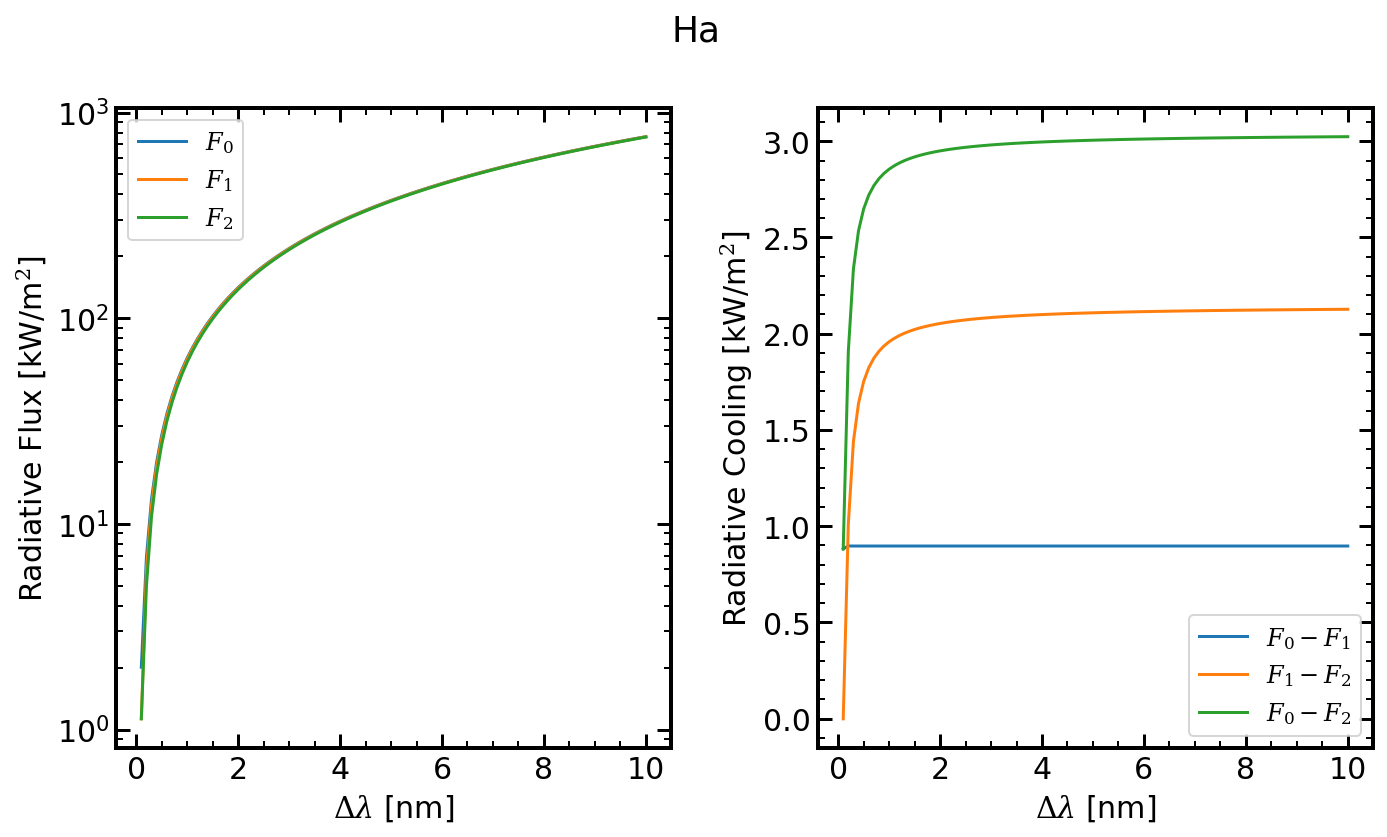

In [24]:
fplot(dwv=integration_binsize, fr=FR_Ha, line='Ha')

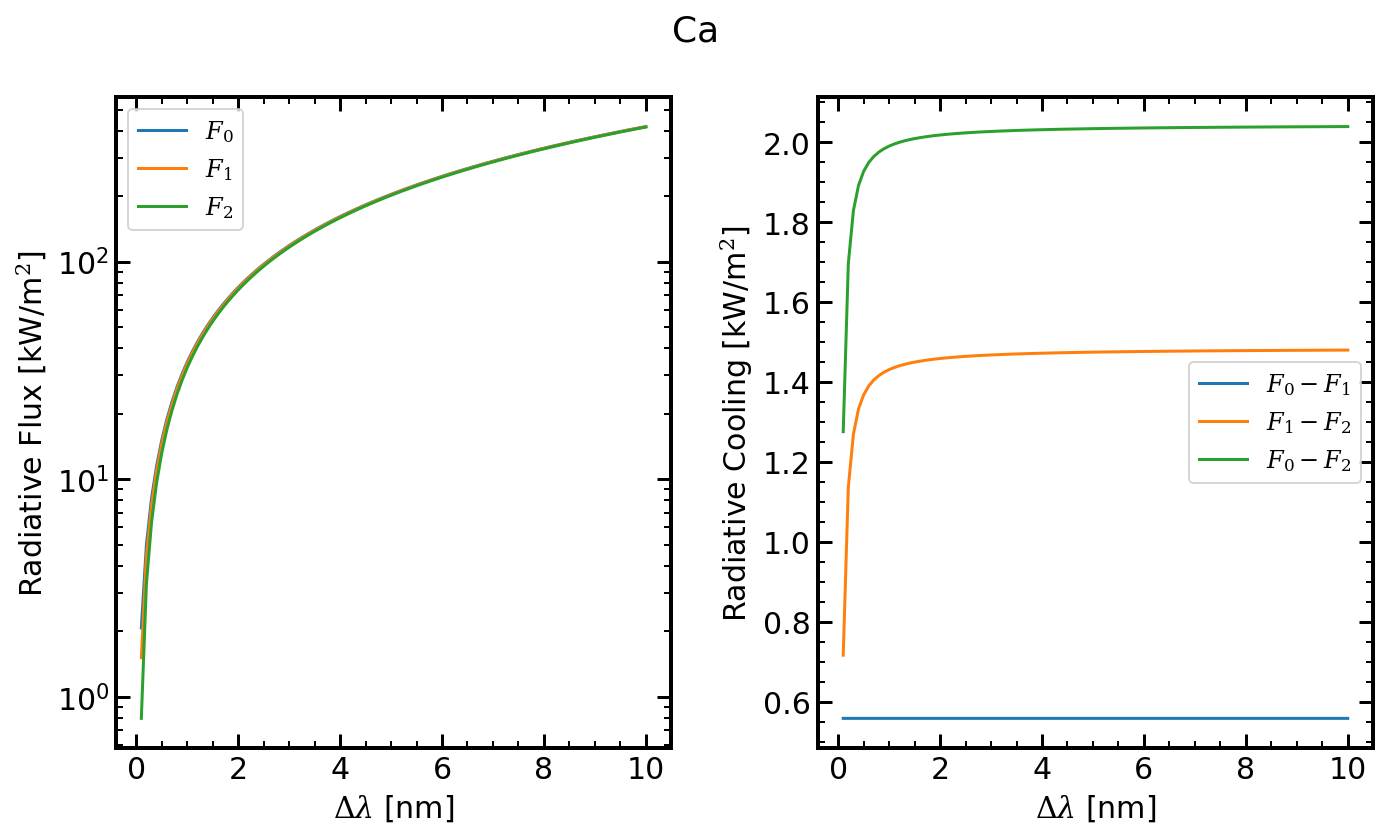

In [26]:
fplot(dwv=integration_binsize, fr=FR_Ca, line='Ca')

### Test

In [88]:
# typical parameters
params_Ha = db.parHa[:,195,74]
params_Ca = db.parCa[:,195,74]
print(params_Ha)
print(params_Ca)

t1 = time()
fr_Ha, err_Ha = flux_calculator(params_Ha, line='Ha')
t2 = time()
fr_Ca, err_Ca = flux_calculator(params_Ca, line='Ca')
t3 = time()

print(f'Flux and error of Ha line: Time for one calc. = {(t2-t1):.3f} [sec]\n', fr_Ha, err_Ha)
print(f'Flux and error of Ca II line: Time for one calc. = {(t3-t2):.3f} [sec]\n', fr_Ca, err_Ca)

[-0.23561827  0.51       -1.16        1.1         0.01623684 -0.17620977
  0.69897     0.69897    -0.04488366 -0.28742185 -0.45361545 -0.45479517
 -0.41356372 -0.75684617  1.01331481  0.0114648   0.2082937 ]
[-1.26005755e-01  4.30000000e-01 -1.27000000e+00  1.32000000e+00
  2.23460520e-03 -3.67490708e-01  6.98970004e-01  6.98970004e-01
 -2.77493924e-01 -4.64212929e-01 -6.93438776e-01 -7.92449403e-01
 -3.12704712e-01 -7.64941134e-01  4.13889635e+00  2.61559420e-01
  2.44994229e-01]
Flux and error of Ha line: Time for one calc. = 5.772 [sec]
 [64.05231037 63.1554922  61.1974298 ] [7.45991595e-06 7.45616235e-06 4.43967420e-06]
Flux and error of Ca II line: Time for one calc. = 6.767 [sec]
 [34.52193793 33.96302533 32.53202805] [4.52871635e-06 4.68694908e-06 2.69105673e-06]


In [15]:
db.parCa[:,0,1]

array([ 3.15908468e-03,  4.30000000e-01, -1.27000000e+00,  1.32000000e+00,
       -7.18105541e-03, -5.03346341e-01,  6.98970004e-01,  6.98970004e-01,
       -4.07569201e-01,  1.60883983e+00, -7.35534114e-01, -8.31962509e-01,
       -4.52915429e-01, -1.01851623e+00,  5.74394150e+00,  4.84160455e-01,
        1.70351881e-01])

In [14]:
fr_Ha, err_Ha = flux_calculator(db.parCa[:,0,1], line='Ca')

In [16]:
print(fr_Ha)

[30.51636498 30.21987038 29.50166376]


### Mining flux data with Multiprocessing

In [79]:
import multiprocessing as mp
from multiprocessing import Pool, Process, Queue, Manager

In [80]:
mp.cpu_count()

48

In [111]:
# Calculation by Multiprocessing
def worker(result_list, num1, num2):
    flux, err = flux_calculator(db.parHa[:,num1,num2], line='Ha')
    result = []
    result.append((num1,num2))
    result.append(flux)
    
    result_list.append(result)
    
if __name__ == '__main__':
    cols = range(250)
    rows = range(150)
    
    pool = Pool(8)
    manager = Manager()
    result_list = manager.list()

    t_start = time()
    pool.starmap(worker, [(result_list, i, j) for i in cols for j in rows])
    pool.close()
    pool.join()
    t_end = time()
    print(f'runtime for 8 calculations = {t_end-t_start:.2e} [sec] = {(t_end-t_start)/3600:.2f} [hr]')

runtime for 8 calculations = 2.78e+04 [sec] = 7.72 [hr]


In [119]:
FLUX_Ha = np.zeros((3,250,150))

for (i, j), flux in result_list:
    FLUX_Ha[:,i,j] = flux

In [121]:
np.save('FR_20170614_180941_Ha.npy', FLUX_Ha)

## Flux Calculator ver.1.1

In [73]:
def flux_calculator_1(pars, line='Ha', int_bin_size=1, optical_depth=0, calc_option='aggregate'):
    e2 = lambda x: special.expn(2,x)
    
    # [S] = ?
    S0 = 10**pars[13]
    S1 = 10**pars[12]
    S2 = 10**pars[5]
    Sp = 10**pars[4]

    s1 = lambda x: S0 + (-3*S0+4*S1-S2)/2 * x + (S0-2*S1+S2)/2 * x**2
    s2 = lambda x: S1 + (-S0+S2)/2 * x        + (S0-2*S1+S2)/2 * x**2
    s3 = lambda x: S2 + (Sp-S2) * x

    # [v] = km/s, [w] = nm, [a]&[eta]&[tau] = None
    v1 = pars[9]
    w1 = 10**(pars[11]-1)
    a1 = 0.0
    
    v2 = pars[8]
    w2 = 10**(pars[10]-1)
    a2 = 0.3
    
    vp = pars[0]
    wp = 10**(pars[2]-1)
    ap = 10**pars[3]
    eta = 10**pars[1]
    
    tau = 5.0
    c = 3e5 # km/s
    
    # different parameters of given line
    if line == 'Ha':
        wv0 = 656.3 # nm
        factor = 28.5/1.05 # kW m-2 sr-1 nm-1
    elif line == 'Ca':
        wv0 = 854.2 # nm
        factor = 17.6/1.05 # kW m-2 sr-1 nm-1
    else:
        raise NameError('Wrong line inputting.')
        
    # integration range [nm], default bin size = 1nm
    int_bin = [wv0-int_bin_size/2, wv0+int_bin_size/2]
    
    def u(wv, v, w):
        return (wv - (1+v/c)*wv0)/w

    h1 = lambda y: tau * wofz(u(y,v1,w1) + a1*1j).real / wofz(a1*1j).real
    h2 = lambda y: tau * wofz(u(y,v2,w2) + a2*1j).real / wofz(a2*1j).real
    hp = lambda y: eta * wofz(u(y,vp,wp) + ap*1j).real / wofz(ap*1j).real + 1

    # Flux by layer
    if optical_depth >= 0 and optical_depth < 1:
        xx = optical_depth
        f0 = lambda x,y: s1(x) * e2(abs(x-xx)*h1(y)                  ) * h1(y) * np.sign(x-xx)
        f1 = lambda x,y: s2(x) * e2(   (1-xx)*h1(y) + x*h2(y)        ) * h2(y)
        f2 = lambda x,y: s3(x) * e2(   (1-xx)*h1(y) + h2(y) + x*hp(y)) * hp(y)
        
    elif optical_depth >= 1 and optical_depth < 2:
        xx = optical_depth-1
        f0 = lambda x,y: s1(x) * -e2((1-x)*h1(y) + xx*h2(y)             ) * h1(y)
        f1 = lambda x,y: s2(x) *  e2(          abs(x-xx)*h2(y)          ) * h2(y) * np.sign(x-xx)
        f2 = lambda x,y: s3(x) *  e2(             (1-xx)*h2(y) + x*hp(y)) * hp(y)
    
    elif optical_depth >= 2:
        xx = optical_depth-2
        f0 = lambda x,y: s1(x) * -e2((1-x)*h1(y) + h2(y)      + xx*hp(y)   ) * h1(y)
        f1 = lambda x,y: s2(x) * -e2(             (1-x)*h2(y) + xx*hp(y)   ) * h2(y)
        f2 = lambda x,y: s3(x) *  e2(                       abs(x-xx)*hp(y)) * hp(y) * np.sign(x-xx)
    else:
        raise NameError('Wrong optical depth inputted!')

    # Calculation by layer
    num = 3
    FR, ERR = np.zeros(num), np.zeros(num)
    
    FR[0], ERR[0] = integrate.nquad(f0, [[0,1],int_bin])
    FR[1], ERR[1] = integrate.nquad(f1, [[0,1],int_bin]) 
    FR[2], ERR[2] = integrate.nquad(f2, [[0,np.inf],int_bin])
    
    if calc_option == 'aggregate':
        FR, ERR = FR @ np.ones(num), ERR @ np.ones(num)
    elif calc_option == 'separate':
        pass
    else:
        raise NameError('Wrong calculation option iputted!')

    # [F_R] = kW/m^2
    FR = 2*np.pi * FR * factor
    ERR = 2*np.pi * ERR * factor
    
    return FR, ERR

### Test

In [50]:
# typical parameters
params_Ha = db.parHa[:,195,74]
params_Ca = db.parCa[:,195,74]
optdepths = [0,1,2]

for optdepth in optdepths:
    t1 = time()
    fr_Ha, err_Ha = flux_calculator_1(params_Ha, line='Ha', optical_depth=optdepth)
    t2 = time()
    fr_Ca, err_Ca = flux_calculator_1(params_Ca, line='Ca', optical_depth=optdepth)
    t3 = time()

    print(f'Flux and error of Ha line: Time for one calc. = {(t2-t1):.3f} [sec]\n', fr_Ha, err_Ha)
    print(f'Flux and error of Ca II line: Time for one calc. = {(t3-t2):.3f} [sec]\n', fr_Ca, err_Ca)

Flux and error of Ha line: Time for one calc. = 2.264 [sec]
 64.05231037334485 7.459915952614864e-06
Flux and error of Ca II line: Time for one calc. = 3.104 [sec]
 34.52193792583937 4.528716350811497e-06
Flux and error of Ha line: Time for one calc. = 2.558 [sec]
 63.15549220281858 7.4561623485016486e-06
Flux and error of Ca II line: Time for one calc. = 2.766 [sec]
 33.963025330840544 4.686949082887351e-06
Flux and error of Ha line: Time for one calc. = 1.821 [sec]
 61.19742979768063 4.439674198846707e-06
Flux and error of Ca II line: Time for one calc. = 1.625 [sec]
 32.532028054191 2.6910567291011527e-06


In [51]:
FR_Ha[9]

array([64.05231037, 63.1554922 , 61.1974298 ])

In [74]:
fr_Ha, err_Ha = flux_calculator_1(params_Ha, line='Ha', optical_depth=0.5)
print(fr_Ha)

63.264201546500544


### As a function of $x=\tau/\tau_0$

In [105]:
# optical depth []
optical_depth_list = np.linspace(0,3, 3*20+1)
#print(optical_depth_list)

params_Ha = db.parHa[:,195,74]
params_Ca = db.parCa[:,195,74]
FR_Ha_x = []
FR_Ca_x = []

for idx, optical_depth in enumerate(optical_depth_list):
    print(idx)
    fr_Ha, err_Ha = flux_calculator_1(params_Ha, line='Ha', optical_depth=optical_depth)
    fr_Ca, err_Ca = flux_calculator_1(params_Ca, line='Ca', optical_depth=optical_depth)
    
    FR_Ha_x.append(fr_Ha)
    FR_Ca_x.append(fr_Ca)
    
FR_Ha_x = np.array(FR_Ha_x)
FR_Ca_x = np.array(FR_Ca_x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [106]:
def fplot(x, fr, params, line='Ha'):
    fig, ax = plt.subplots(1,3, figsize=(14,6))
    
    S0 = 10**params[13]
    S1 = 10**params[12]
    S2 = 10**params[5]
    Sp = 10**params[4]

    s1 = lambda x: S0 + (-3*S0+4*S1-S2)/2 * x + (S0-2*S1+S2)/2 * x**2
    s2 = lambda x: S1 + (-S0+S2)/2 * x        + (S0-2*S1+S2)/2 * x**2
    s3 = lambda x: S2 + (Sp-S2) * x

    # [v] = km/s, [w] = nm, [a]&[eta]&[tau] = None
    eta = 10**params[1]
    
    x_uc = x[x<=1]
    x_lc = x[np.logical_and(x<=2, x>=1)]
    x_ph = (x[x>=2]-2)*(1+eta) + 2
    
    # Source function graph
    ax[0].plot(x_uc, s1(x_uc), label='upper chromosphere')
    ax[0].plot(x_lc, s2(x_lc-1), label='lower chromosphere')
    ax[0].plot(x_ph, s3(x[x>=2]-2), label='photosphere')
    ax[0].set(xlabel=r'$t/\tau$', ylabel='Source Function', title=r'$S$')
    ax[0].legend()
    
    # Radiative Flux graph
    ax[1].plot(x_uc, fr[x<=1])
    ax[1].plot(x_lc, fr[np.logical_and(x<=2, x>=1)])
    ax[1].plot(x_ph, fr[x>=2])
    ax[1].set(xlabel=r'$t/\tau$', ylabel=r'Radiative Flux [kW/m$^2$]', title=r'$F_R$')
    
    # Radiative Loss graph
    loss = fr.copy()
    loss[:-1] += -fr[1:].copy()
    loss[-1] = 0
    
    ax[2].step(x_uc, loss[x<=1])
    ax[2].step(x_lc, loss[np.logical_and(x<=2, x>=1)])
    ax[2].step(x_ph, loss[x>=2])
    ax[2].set(xlabel=r'$t/\tau$', ylabel=r'Radiative Loss [kW/m$^2$]', title=r'$\Delta F_R$')
    ax[2].grid(ls=':')

    fig.suptitle(line)
    plt.tight_layout()
    #plt.savefig('.pdf', format='pdf', dpi=300)
    plt.show()

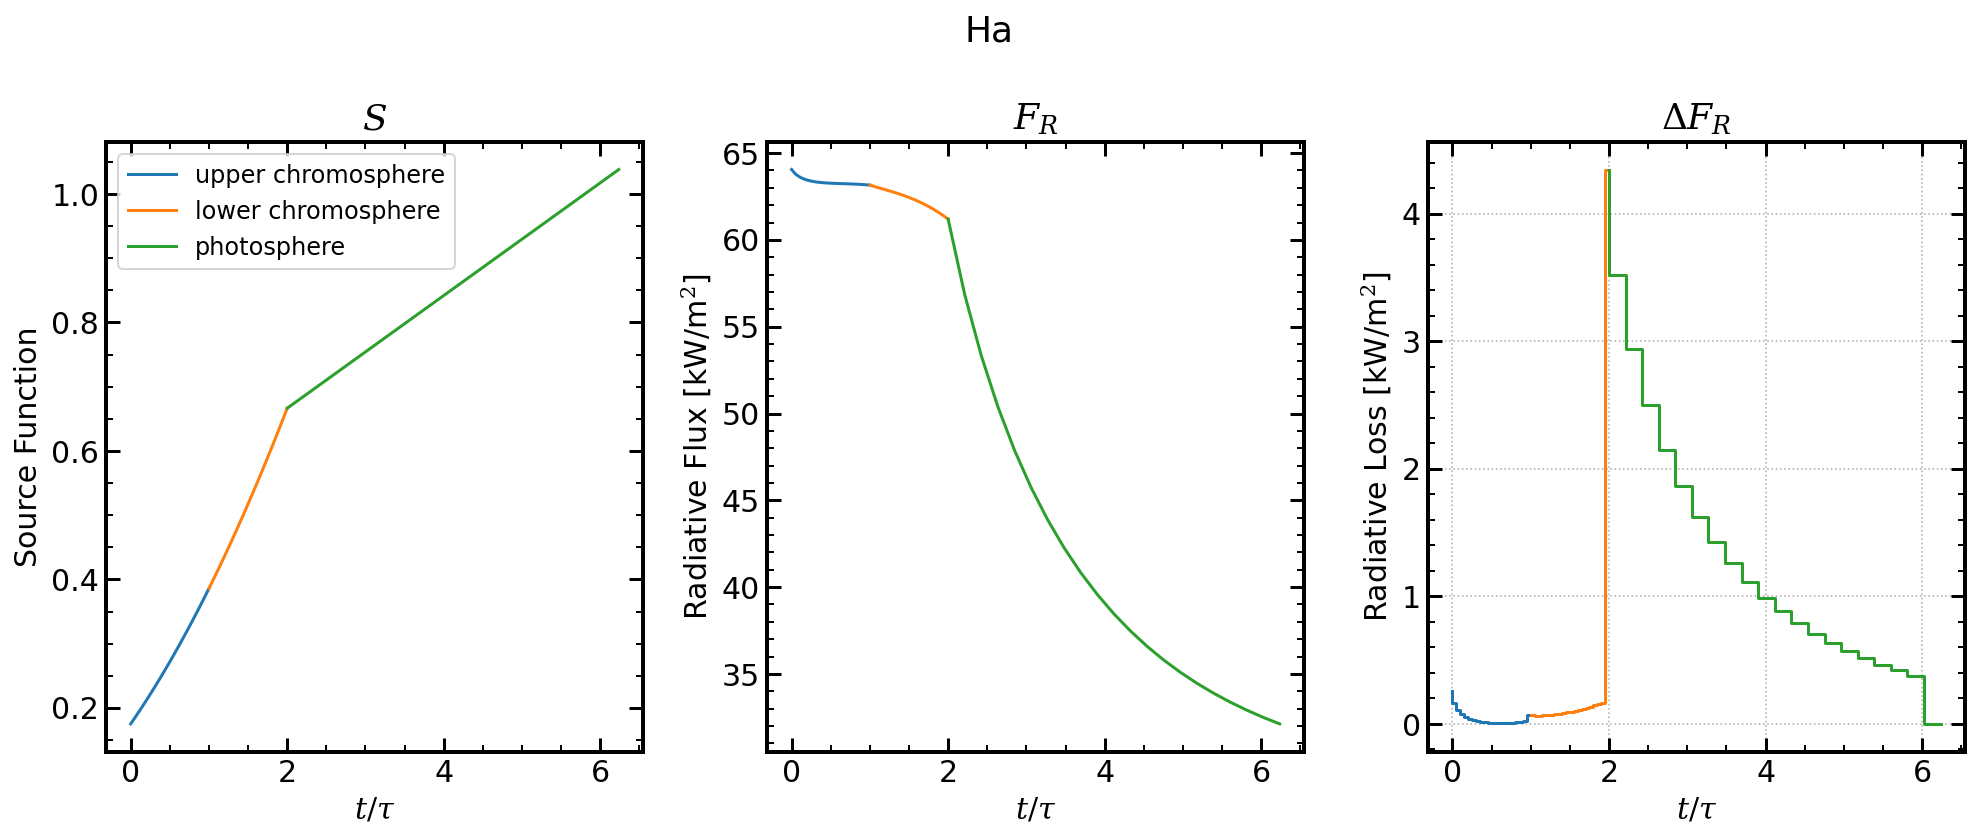

In [107]:
fplot(x=optical_depth_list, fr=FR_Ha_x, params=params_Ha, line='Ha')

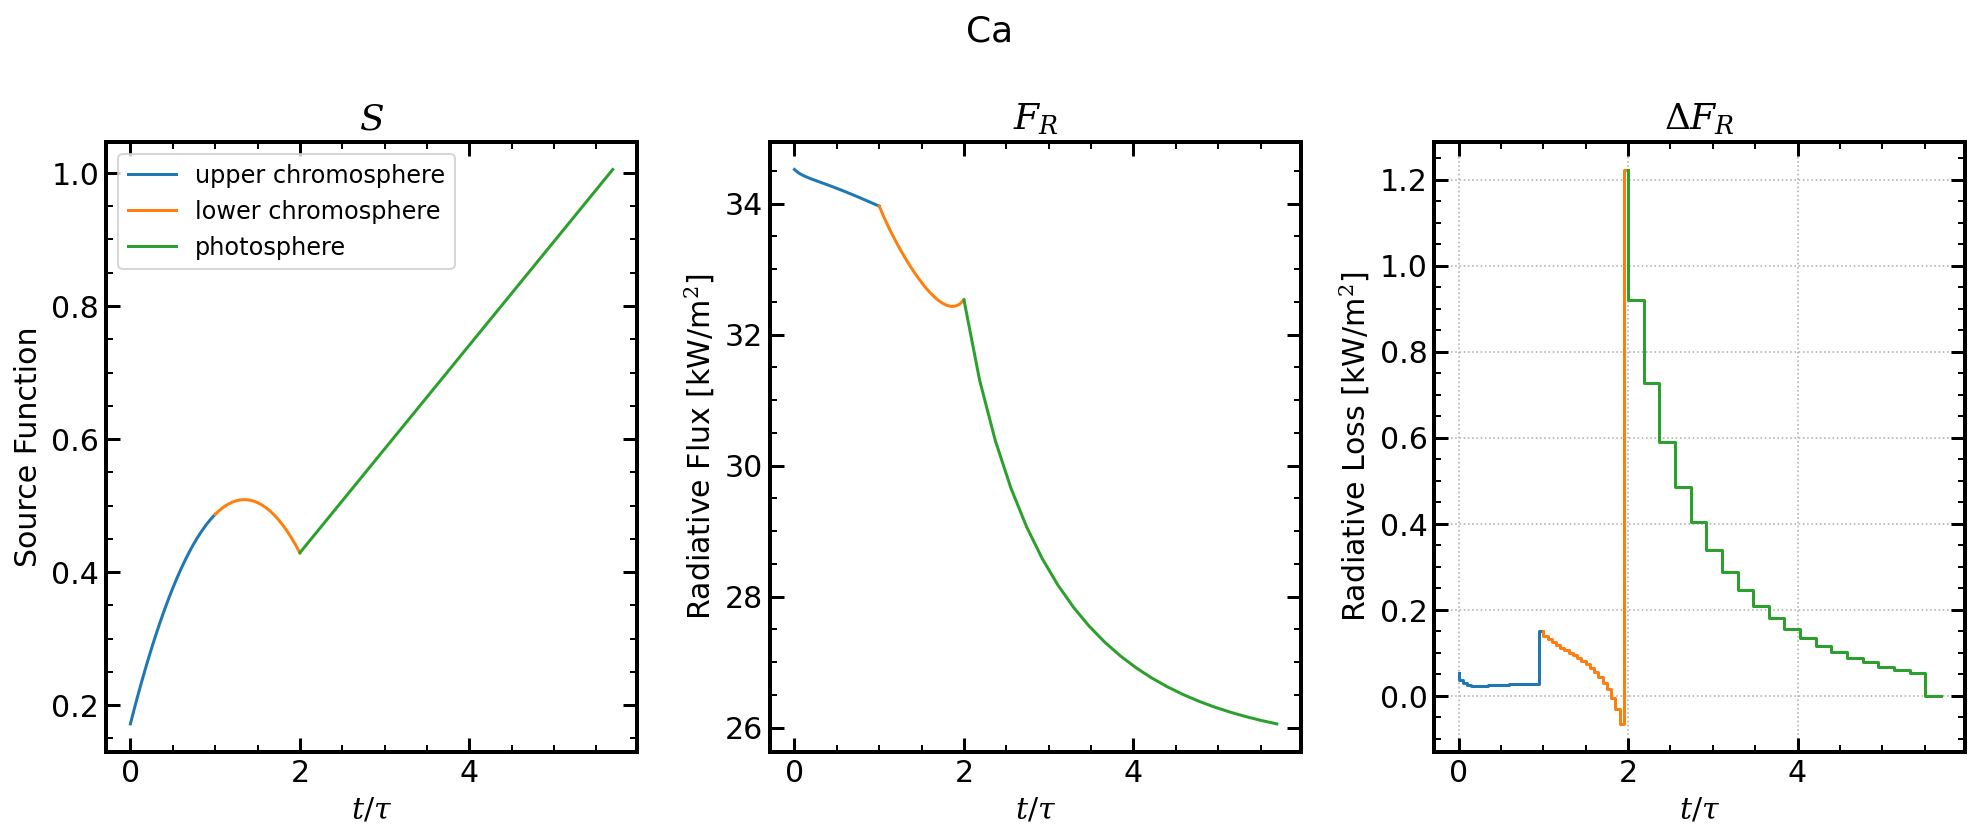

In [108]:
fplot(x=optical_depth_list, fr=FR_Ca_x, params=params_Ca, line='Ca')

## Flux Calculator ver.1.2 (Chae et al. 2021 in prep.)

In [2]:
def flux_calculator_2(pars, line='Ha', int_bin_size=2, calc_option='bundle'):  
    # source function, [S] = ?
    s0 = 10**pars[13]
    s1 = 10**pars[12]
    s2 = 10**pars[5]
    sp = 10**pars[4]

    S1 = lambda x: s0 + (-3*s0+4*s1-s2)/2 * x + (s0-2*s1+s2)/2 * x**2
    S2 = lambda x: s1 + (-s0+s2)/2 * x        + (s0-2*s1+s2)/2 * x**2
    S3 = lambda x: s2 + (sp-s2) * x

    # Doppler shift, [v] = km/s
    v0 = pars[9]
    v1 = pars[8]
    v2 = pars[0]
    vp = v2
    
    V1 = lambda x: v0 + (v1-v0)*x
    V2 = lambda x: v1 + (v2-v1)*x
    V3 = lambda x: v2
    
    # Doppelr width, [w] = nm
    w0 = 10**(pars[11]-1)
    w1 = 10**(pars[10]-1)
    w2 = 10**(pars[2]-1)
    wp = w2
    
    W1 = lambda x: w0 + (w1-w0)*x
    W2 = lambda x: w1 + (w2-w1)*x
    W3 = lambda x: w2
    
    # Other parameters, [a]&[eta]&[tau] = None
    a1 = 0.0
    a2 = lambda x: 10**(pars[14]-1)*x/W2(x)
    ap = 10**pars[3]
    eta = 10**pars[1]
    tau = 5.0
    c = 3e5 # km/s
    
    # different parameters of given line
    if line == 'Ha':
        line_center = 656.2817 # nm
        flux_factor = 28.5/1.05 # kW m-2 sr-1 nm-1
    elif line == 'Ca':
        line_center = 854.2091 # nm
        flux_factor = 17.6/1.05 # kW m-2 sr-1 nm-1
    else:
        raise NameError('Wrong line inputting.')
    
    # Line profiles & optical depth
    def u(wavelength, velocity, width):
        return (wavelength - (1+velocity/c)*line_center)/width
    
    r1 = lambda x, y: wofz(u(y,V1(x),W1(x)) + a1*1j).real    / wofz(a1*1j).real
    r2 = lambda x, y: wofz(u(y,V2(x),W2(x)) + a2(x)*1j).real / wofz(a2(x)*1j).real
    rp = lambda x, y: wofz(u(y,V3(x),W3(x)) + ap*1j).real    / wofz(ap*1j).real * eta + 1
    
    t1 = lambda x, y: tau * x/2 * (5/9*r1(x*(1-np.sqrt(3/5))/2,y) + 8/9*r1(x/2,y) + 5/9*r1(x*(1+np.sqrt(3/5))/2,y))
    t2 = lambda x, y: tau * x/2 * (5/9*r2(x*(1-np.sqrt(3/5))/2,y) + 8/9*r2(x/2,y) + 5/9*r2(x*(1+np.sqrt(3/5))/2,y))
    tp = lambda x, y: x * rp(x,y)

    E2 = lambda x: special.expn(2,x)
    
    # integration range [nm], default bin size = 2nm
    int_bin = [line_center-int_bin_size/2, line_center+int_bin_size/2]

    # Flux_0
    f00 = lambda x, y: S1(x) * E2(t1(x,y)                    ) * r1(x,y) * tau
    f01 = lambda x, y: S2(x) * E2(t1(1,y) + t2(x,y)          ) * r2(x,y) * tau
    f02 = lambda x, y: S3(x) * E2(t1(1,y) + t2(1,y) + tp(x,y)) * rp(x,y)
    
    # Flux_1
    f10 = lambda x, y: S1(x) * -E2(t1(1-x,y)                 ) * r1(1-x,y) * tau
    f11 = lambda x, y: S2(x) *  E2(         t2(x,y)          ) * r2(x,y)   * tau
    f12 = lambda x, y: S3(x) *  E2(         t2(1,y) + tp(x,y)) * rp(x,y)
    
    # Flux_2
    f20 = lambda x, y: S1(x) * -E2(t1(1-x,y) + t2(1,y)         ) * r1(1-x,y) * tau
    f21 = lambda x, y: S2(x) * -E2(            t2(1-x,y)       ) * r2(1-x,y) * tau
    f22 = lambda x, y: S3(x) *  E2(                     tp(x,y)) * rp(x,y)

    # Calculation part
    FR, ERR = np.zeros((3,3)), np.zeros((3,3))
   
    FR[0,0], ERR[0,0] = integrate.nquad(f00, [[0,1],int_bin])
    FR[0,1], ERR[0,1] = integrate.nquad(f01, [[0,1],int_bin]) 
    FR[0,2], ERR[0,2] = integrate.nquad(f02, [[0,np.inf],int_bin])
    
    FR[1,0], ERR[1,0] = integrate.nquad(f10, [[0,1],int_bin])
    FR[1,1], ERR[1,1] = integrate.nquad(f11, [[0,1],int_bin])
    FR[1,2], ERR[1,2] = integrate.nquad(f12, [[0,np.inf],int_bin])

    FR[2,0], ERR[2,0] = integrate.nquad(f20, [[0,1],int_bin])
    FR[2,1], ERR[2,1] = integrate.nquad(f21, [[0,1],int_bin])
    FR[2,2], ERR[2,2] = integrate.nquad(f22, [[0,np.inf],int_bin])
    
    if calc_option == 'bundle':
        FR, ERR = FR @ np.ones(3), ERR @ np.ones(3)
    elif calc_option == 'each':
        pass
    else:
        raise NameError('Wrong calculation option iputted!')

    # [F_R] = kW/m^2
    FR = 2*np.pi * FR * flux_factor
    ERR = 2*np.pi * ERR * flux_factor
    
    return FR, ERR

### Test

In [5]:
print(db.parHa.shape, db.parCa.shape)

(17, 250, 150) (17, 250, 150)


In [6]:
db.parHa[:,10,11]

array([ 0.43537463,  0.5117362 , -0.6465525 ,  0.53778269, -0.00416036,
       -0.24600326,  0.69897   ,  0.69897   , -1.94284752,  2.4122754 ,
       -0.44945142, -0.56162425, -0.3919701 , -0.82363146,  0.14271902,
        1.01203401,  0.74659271])

In [7]:
t1 = time()
fr_Ha, err_Ha = flux_calculator_2(db.parHa[:,10,11], line='Ha')
t2 = time()
fr_Ca, err_Ca = flux_calculator_2(db.parCa[:,10,11], line='Ca')
t3 = time()

print(f'Flux and error of Ha line: Time for one calc. = {(t2-t1):.3f} [sec]\n', fr_Ha)
print(f'Flux and error of Ca II line: Time for one calc. = {(t3-t2):.3f} [sec]\n', fr_Ca)

Flux and error of Ha line: Time for one calc. = 10.968 [sec]
 [121.13677725 120.06063361 107.4828755 ]
Flux and error of Ca II line: Time for one calc. = 10.290 [sec]
 [60.97875755 60.56158633 51.90369576]


In [9]:
db.fissHa.data.shape

(250, 150, 512)

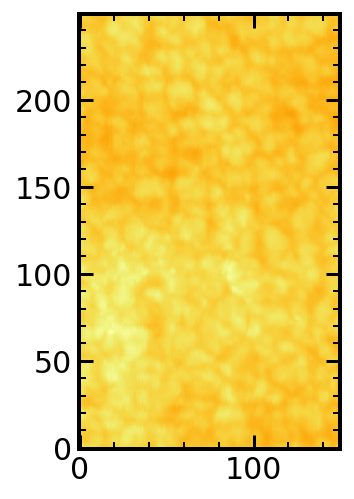

In [13]:
plt.imshow(db.fissHa.data[:,:,20], origin='lower', cmap='inferno')

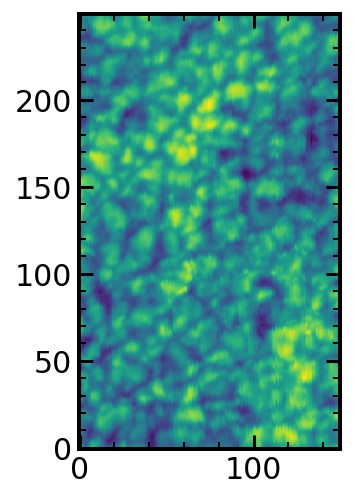

In [16]:
plt.imshow(db.parHa[4,:,:], origin='lower')

### Mining data

In [8]:
mp.cpu_count()

48

In [17]:
# Calculation by Multiprocessing
def worker(result_list, num1, num2):
    lines = ['Ha', 'Ca']
    for line in lines:
        flux, err = flux_calculator_2(db.parHa[:,num1,num2], line=line)
        result = []
        result.append((num1,num2))
        result.append(flux)
        result.append(line)
        
        result_list.append(result)
    
if __name__ == '__main__':    
    num_cpu = 32
    pool = Pool(num_cpu)
    manager = Manager()
    result_list = manager.list()

    npar, rows, cols = db.parHa.shape
    
    t_start = time()
    pool.starmap(worker, [(result_list, i, j) for i in range(rows) for j in range(cols)])
    pool.close()
    pool.join()
    t_end = time()
    print(f'runtime with {num_cpu} CPUs = {t_end-t_start:.2e} [sec] = {(t_end-t_start)/3600:.2f} [hr]')
    
    FLUX_Ha = np.zeros((3,rows,cols))
    FLUX_Ca = np.zeros((3,rows,cols))

    for (i, j), flux, line in result_list:
        if line=='Ha':
            FLUX_Ha[:,i,j] = flux
        elif line=='Ca':
            FLUX_Ca[:,i,j] = flux
        else:
            raise NameError('wrong line name saved..')
    
    if np.any(FLUX_Ha == None):
        print((FLUX_Ha == None).sum())
    else:
        np.save('FR_20130717_185221_Ha.npy', FLUX_Ha)
        
    if np.any(FLUX_Ca == None):
        print((FLUX_Ca == None).sum())
    else:
        np.save('FR_20130717_185222_Ca.npy', FLUX_Ca)

runtime with 32 CPUs = 3.19e+04 [sec] = 8.86 [hr]


In [92]:
np.save('FR_20200730_171326_Ha.npy', FLUX_Ha)
np.save('FR_20200730_171326_Ca.npy', FLUX_Ca)

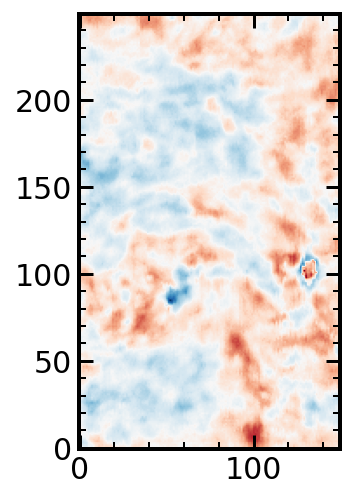

In [19]:
plt.imshow(FLUX_Ha[0,:,:]-FLUX_Ha[2,:,:], origin='lower', cmap='RdBu',  )

(array([3.0000e+00, 1.1300e+02, 1.3040e+03, 5.7850e+03, 1.4117e+04,
        1.2560e+04, 3.4390e+03, 1.5300e+02, 2.1000e+01, 5.0000e+00]),
 array([ 5.7427644 ,  7.19399991,  8.64523541, 10.09647091, 11.54770641,
        12.99894191, 14.45017741, 15.90141291, 17.35264841, 18.80388391,
        20.25511942]),
 <BarContainer object of 10 artists>)

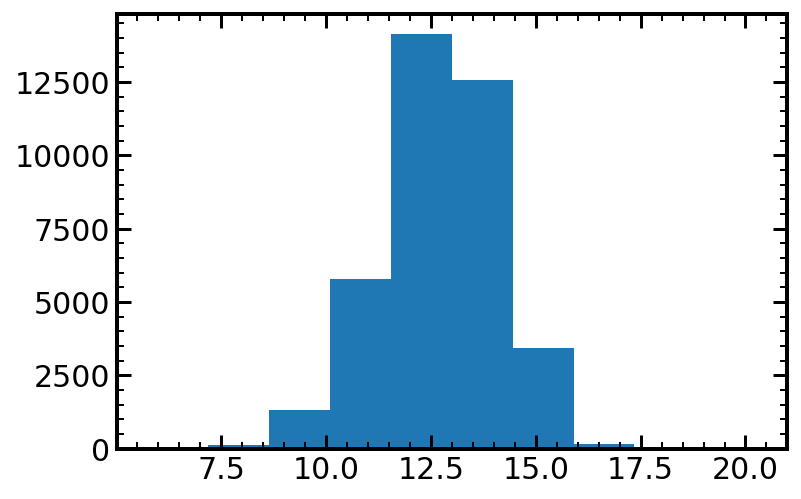

In [21]:
plt.hist((FLUX_Ha[0,:,:]-FLUX_Ha[2,:,:]).reshape(-1))

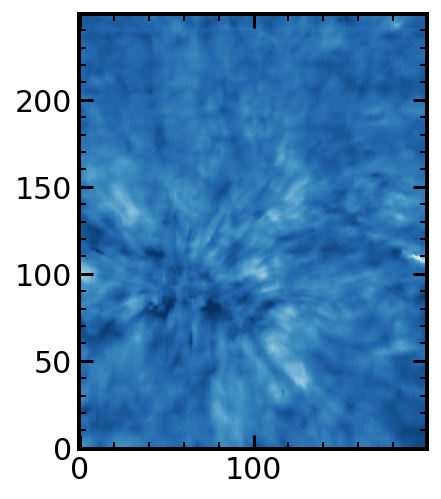

In [89]:
plt.imshow(FLUX_Ca[0,:,:]-FLUX_Ca[2,:,:], origin='lower', cmap='RdBu',  norm=colors.Normalize(vmin=-10, vmax=10))

## Flux Calculator ver.2
Apply single integration with generated Kernel function in order to make flux calculation faster than before.
$$\begin{align}
K_{0,0}(x) &= \int E_2(H_{\lambda,1}x) H_{\lambda,1}d\lambda, &K_{0,0}(x) &= \int E_2(H_{\lambda,1}x) H_{\lambda,1}d\lambda,\\
K_{0,1}(x) &= \int E_2(H_{\lambda,1}+H_{\lambda,2}x) H_{\lambda,2}d\lambda, &K_{1,0}(x) &= -\int E_2(H_{\lambda,1}(1-x)) H_{\lambda,1}d\lambda\\
K_{0,2}(x) &= \int E_2(H_{\lambda,1}+H_{\lambda,2}+H_{\lambda,p}x) H_{\lambda,p}d\lambda, &K_{2,0}(x) &= -\int E_2(H_{\lambda,1}(1-x)+H_{\lambda,2}) H_{\lambda,1}d\lambda\\ \\
K_{1,0}(x) &= -\int E_2(H_{\lambda,1}(1-x)) H_{\lambda,1}d\lambda, &K_{0,1}(x) &= \int E_2(H_{\lambda,1}+H_{\lambda,2}x) H_{\lambda,2}d\lambda\\
K_{1,1}(x) &= \int E_2(H_{\lambda,2}x) H_{\lambda,2}d\lambda, &K_{1,1}(x) &= \int E_2(H_{\lambda,2}x) H_{\lambda,2}d\lambda\\
K_{1,2}(x) &= \int E_2(H_{\lambda,2}+H_{\lambda,p}x) H_{\lambda,p}d\lambda, &K_{2,1}(x) &= -\int E_2(H_{\lambda,2}(1-x)) H_{\lambda,2}d\lambda\\ \\
K_{2,0}(x) &= -\int E_2(H_{\lambda,1}(1-x)+H_{\lambda,2}) H_{\lambda,1}d\lambda, &K_{0,2}(x) &= \int E_2(H_{\lambda,1}+H_{\lambda,2}+H_{\lambda,p}x) H_{\lambda,p}d\lambda\\
K_{2,1}(x) &= -\int E_2(H_{\lambda,2}(1-x)) H_{\lambda,2}d\lambda, &K_{1,2}(x) &= \int E_2(H_{\lambda,2}+H_{\lambda,p}x) H_{\lambda,p}d\lambda\\
K_{2,2}(x) &= \int E_2(H_{\lambda,p}x) H_{\lambda,p}d\lambda. &K_{2,2}(x) &= \int E_2(H_{\lambda,p}x) H_{\lambda,p}d\lambda.
\end{align}
$$

### Kernel

In [3]:
def gen_kernel(line='Ha'):
    e2 = lambda x: special.expn(2,x)
    x = np.linspace(0,1, 101)
    kernel = []
    
    # [v] = km/s, [w] = nm, [a]&[eta]&[tau] = None
    a1 = 0.0
    a2 = 0.3
    tau = 5.0
    c = 3e5 # km/s
    
    # different parameters of given line
    if line == 'Ha':
        ap = 10**1.1
        eta = 10**0.51
        int_bin = [-80,80] # integration range [dimensionless] 
        
    elif line == 'Ca':
        ap = 10**1.32
        eta = 10**0.43
        int_bin = [-120,120] # integration range [dimensionless]
        
    else:
        raise NameErorr('Wrong line inputting.')

    h1 = lambda y: tau * wofz(y + a1*1j).real / wofz(a1*1j).real
    h2 = lambda y: tau * wofz(y + a2*1j).real / wofz(a2*1j).real
    hp = lambda y: eta * wofz(y + ap*1j).real / wofz(ap*1j).real + 1
    
    for i in range(3):
        for j in range(3):
            ker = np.zeros(len(x))
            for k, xx in enumerate(x):
                if j==0:
                    if i==0:   f = lambda y:  e2(xx*h1(y)            ) * h1(y)
                    elif i==1: f = lambda y: -e2((1-xx)*h1(y)        ) * h1(y)
                    elif i==2: f = lambda y: -e2((1-xx)*h1(y) + h2(y)) * h1(y)
                elif j==1:
                    if i==0:   f = lambda y:  e2(h1(y) + xx*h2(y)) * h2(y)
                    elif i==1: f = lambda y:  e2(        xx*h2(y)) * h2(y)
                    elif i==2: f = lambda y: -e2(    (1-xx)*h2(y)) * h2(y)
                elif j==2:
                    if i==0:   f = lambda y: e2(h1(y) + h2(y) + xx*hp(y)) * hp(y)
                    elif i==1: f = lambda y: e2(        h2(y) + xx*hp(y)) * hp(y)
                    elif i==2: f = lambda y: e2(                xx*hp(y)) * hp(y)
                ker[k] = integrate.quad(f, int_bin[0],int_bin[1], epsrel=1e-5)[0]
            kernel.append(interpolate.interp1d(x, ker, kind='linear', fill_value='extrapolate'))
    
    return kernel

### Modified Kernel-wavelength issue

In [4]:
def gen_kernel2(line='Ha'):
    e2 = lambda x: special.expn(2,x)
    x = np.linspace(0,1, 101)
    kernel = []
    
    # [v] = km/s, [w] = nm, [a]&[eta]&[tau] = None
    a1 = 0.0
    a2 = 0.3
    tau = 5.0
    c = 3e5 # km/s
    
    # different parameters of given line
    if line == 'Ha':
        ap = 10**1.1
        eta = 10**0.51
        int_bin = [-500,500] # [pm], integration range = 1nm
        w1, w2, wp = 10**1.55, 10**1.55, 10**0.84 # [w] = pm
        
    elif line == 'Ca':
        ap = 10**1.32
        eta = 10**0.43
        int_bin = [-500,500] # [pm], integration range = 1nm
        w1, w2, wp = 10**1.21, 10**1.31, 10**0.73 # [w] = pm
        
    else:
        raise NameErorr('Wrong line inputting.')

    h1 = lambda y: tau * wofz(y/w1 + a1*1j).real / wofz(a1*1j).real
    h2 = lambda y: tau * wofz(y/w2 + a2*1j).real / wofz(a2*1j).real
    hp = lambda y: eta * wofz(y/wp + ap*1j).real / wofz(ap*1j).real + 1
    
    for i in range(3):
        for j in range(3):
            ker = np.zeros(len(x))
            for k, xx in enumerate(x):
                if j==0:
                    if i==0:   f = lambda y:  e2(xx*h1(y)            ) * h1(y) / w1
                    elif i==1: f = lambda y: -e2((1-xx)*h1(y)        ) * h1(y) / w1
                    elif i==2: f = lambda y: -e2((1-xx)*h1(y) + h2(y)) * h1(y) / w1
                elif j==1:
                    if i==0:   f = lambda y:  e2(h1(y) + xx*h2(y)) * h2(y) / w2
                    elif i==1: f = lambda y:  e2(        xx*h2(y)) * h2(y) / w2
                    elif i==2: f = lambda y: -e2(    (1-xx)*h2(y)) * h2(y) / w2
                elif j==2:
                    if i==0:   f = lambda y: e2(h1(y) + h2(y) + xx*hp(y)) * hp(y) / wp
                    elif i==1: f = lambda y: e2(        h2(y) + xx*hp(y)) * hp(y) / wp
                    elif i==2: f = lambda y: e2(                xx*hp(y)) * hp(y) / wp
                ker[k] = integrate.quad(f, int_bin[0],int_bin[1], epsrel=1e-5)[0]
            kernel.append(interpolate.interp1d(x, ker, kind='linear', fill_value='extrapolate'))
    
    return kernel

### Modified Kernel-optical depth issue

In [5]:
def gen_kernel3(line='Ha'):
    e2 = lambda x: special.expn(2,x)
    x = np.linspace(0,1, 101)
    N = 10
    kernel = []
    
    # [v] = km/s, [w] = nm, [a]&[eta]&[tau] = None
    a1 = 0.0
    a2 = 0.3
    tau = 5.0
    c = 3e5 # km/s
    
    # different parameters of given line
    if line == 'Ha':
        ap = 10**1.1
        eta = 10**0.51
        int_bin = [-500,500] # [pm], integration range = 1nm
        w1, w2, wp = 10**1.55, 10**1.55, 10**0.84 # [w] = pm
        
    elif line == 'Ca':
        ap = 10**1.32
        eta = 10**0.43
        int_bin = [-500,500] # [pm], integration range = 1nm
        w1, w2, wp = 10**1.21, 10**1.31, 10**0.73 # [w] = pm
        
    else:
        raise NameErorr('Wrong line inputting.')

    h1 = lambda y: tau * wofz(y/w1 + a1*1j).real / wofz(a1*1j).real
    h2 = lambda y: tau * wofz(y/w2 + a2*1j).real / wofz(a2*1j).real
    hp = lambda y: eta * wofz(y/wp + ap*1j).real / wofz(ap*1j).real + 1
    
    for i in range(3):
        for j in range(3):
            ker = np.zeros(len(x))
            for k, xx in enumerate(x):
                if j==0:
                    if i==0:   f = lambda y:  e2(xx*h1(y)            ) * h1(y) / w1
                    elif i==1: f = lambda y: -e2((1-xx)*h1(y)        ) * h1(y) / w1
                    elif i==2: f = lambda y: -e2((1-xx)*h1(y) + h2(y)) * h1(y) / w1
                elif j==1:
                    if i==0:   f = lambda y:  e2(h1(y) + xx*h2(y)) * h2(y) / w2
                    elif i==1: f = lambda y:  e2(        xx*h2(y)) * h2(y) / w2
                    elif i==2: f = lambda y: -e2(    (1-xx)*h2(y)) * h2(y) / w2
                elif j==2:
                    if i==0:   f = lambda y: e2(h1(y) + h2(y) + N*xx*hp(y)) * hp(y) / wp
                    elif i==1: f = lambda y: e2(        h2(y) + N*xx*hp(y)) * hp(y) / wp
                    elif i==2: f = lambda y: e2(                N*xx*hp(y)) * hp(y) / wp
                ker[k] = integrate.quad(f, int_bin[0],int_bin[1], epsrel=1e-5)[0]
            if j==2:
                kernel.append(interpolate.interp1d(N*x, ker, kind='linear', fill_value='extrapolate'))
            else:
                kernel.append(interpolate.interp1d(x, ker, kind='linear', fill_value='extrapolate'))
    
    return kernel

In [6]:
# Obtain kernel for the Ca II line
t1 = time()
KERNEL = gen_kernel(line='Ca')
t2 = time()
KERNEL2 = gen_kernel2(line='Ca')
t3 = time()
KERNEL3 = gen_kernel3(line='Ca')
t4 = time()
print(f'Time for obtaining a kernel function of ver.1 = {(t2-t1):.2e} [sec]')
print(f'Time for obtaining a kernel function of ver.2 = {(t3-t2):.2e} [sec]\n')
print(f'Time for obtaining a kernel function of ver.3 = {(t3-t2):.2e} [sec]\n')

print('Kernels are all set!')

Time for obtaining a kernel function of ver.1 = 3.38e+00 [sec]
Time for obtaining a kernel function of ver.2 = 2.26e+00 [sec]

Time for obtaining a kernel function of ver.3 = 2.26e+00 [sec]

Kernels are all set!


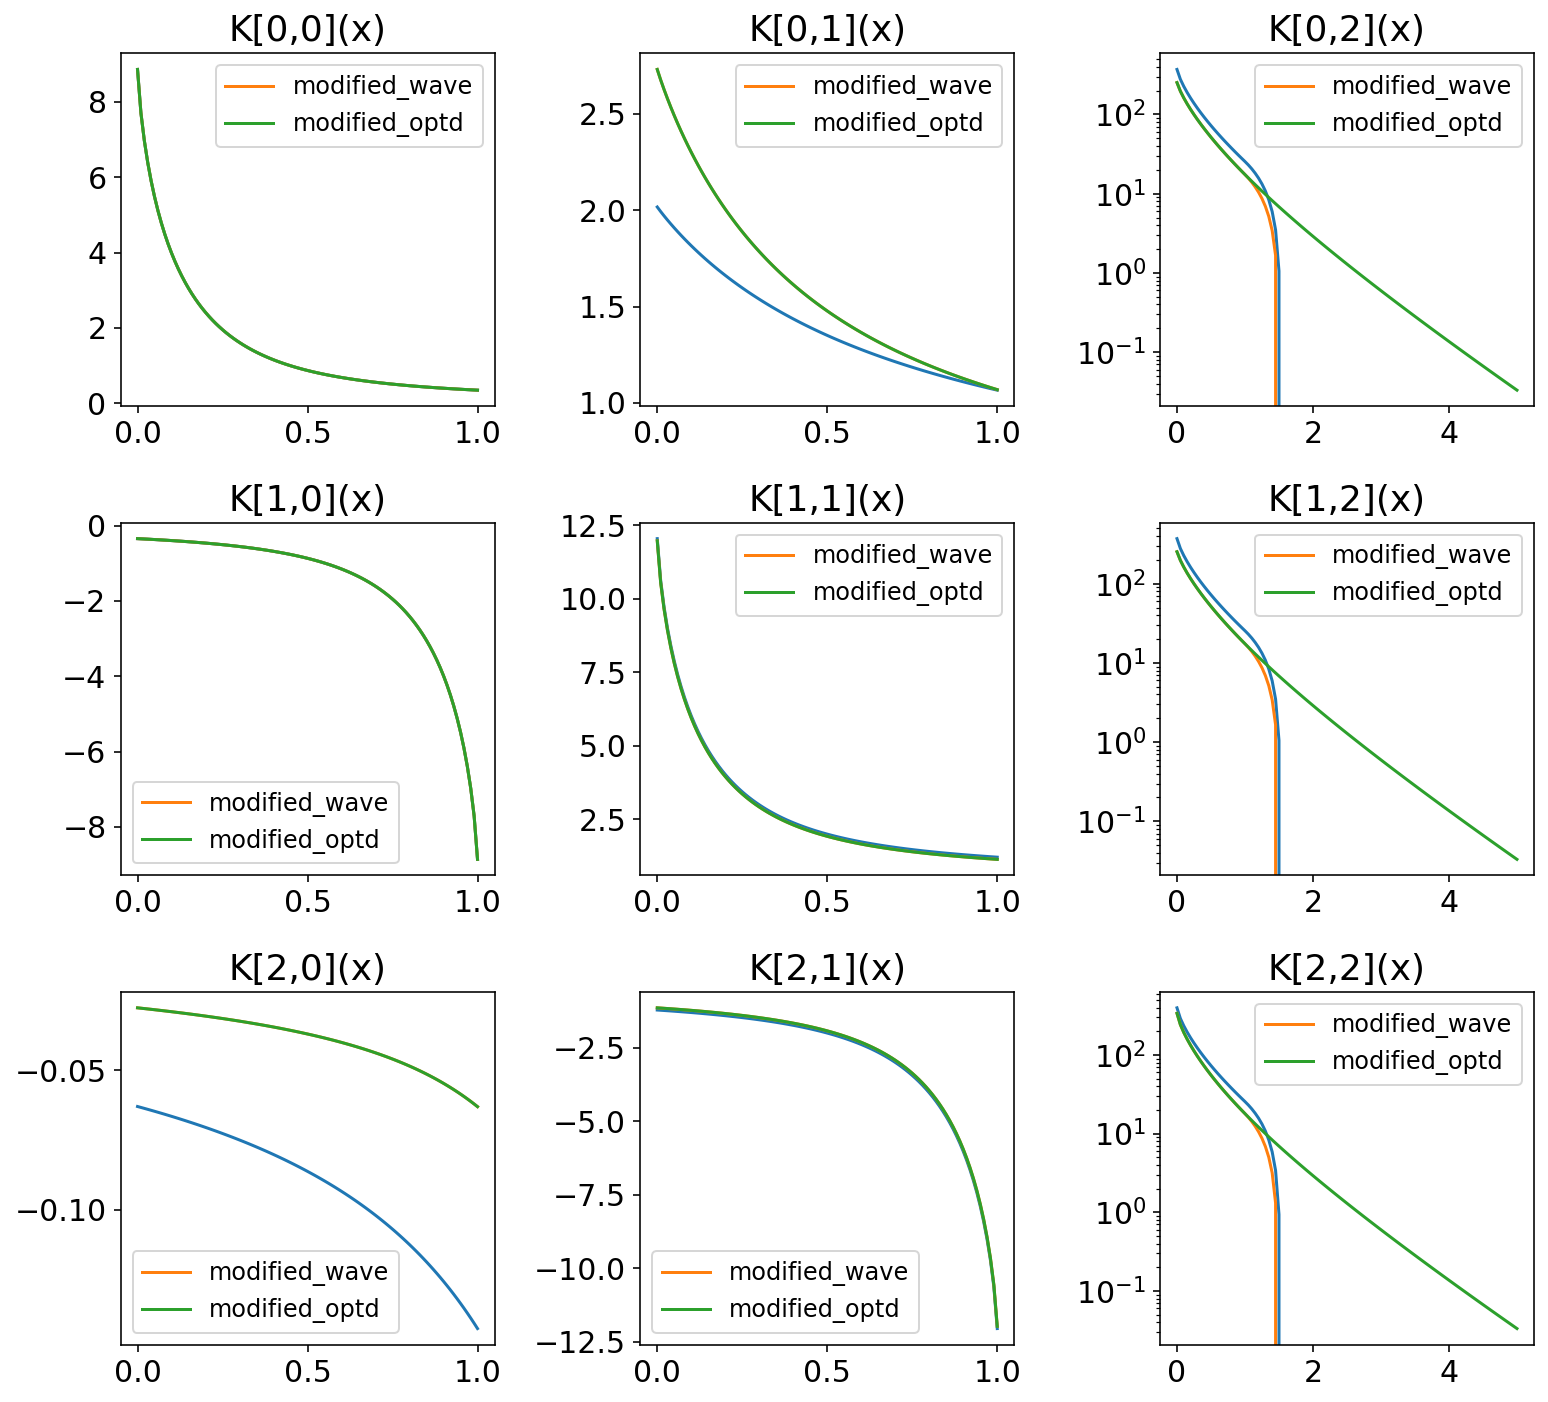

In [12]:
xc = np.linspace(0,1,101)
xp = np.linspace(0,5,101)

fig,ax = plt.subplots(3,3,figsize=(11,10))

for i in range(3):
    for j in range(3):
        if j==2:
            x = xp
        else:
            x = xc
        ax[i,j].plot(x,KERNEL[3*i+j](x))
        ax[i,j].plot(x,KERNEL2[3*i+j](x), label='modified_wave')
        ax[i,j].plot(x,KERNEL3[3*i+j](x), label='modified_optd')
        
        if j==2:
            ax[i,j].set_yscale('log')
        ax[i,j].set_title(f'K[{i},{j}](x)')
        ax[i,j].legend()
        #ax[i,j].tick_params(which='both', direction='in')
        #ax[i,j].tick_params(which='major', length=5)
        
plt.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=500)
plt.show()

In [13]:
def flux_calculator2(pars, line='Ha', kernel=None, criterion=False):
    e2 = lambda x: special.expn(2,x)
    
    # [S] = ?
    S0 = 10**pars[13]
    S1 = 10**pars[12]
    S2 = 10**pars[5]
    Sp = 10**pars[4]

    s1 = lambda x: S0 + (-3*S0+4*S1-S2)/2 * x + (S0-2*S1+S2)/2 * x**2
    s2 = lambda x: S1 + (-S0+S2)/2 * x        + (S0-2*S1+S2)/2 * x**2
    s3 = lambda x: S2 + (Sp-S2) * x
    
    # [w] = nm
    w1 = 10**(pars[11]-1)
    w2 = 10**(pars[10]-1)
    wp = 10**(pars[2]-1)
    
    # different parameters of given line
    if line == 'Ha':
        factor = 2.85e4/1.05 # W m-2 sr-1 nm-1
    elif line == 'Ca':
        factor = 1.76e4/1.05 # W m-2 sr-1 nm-1

    if kernel is None:
        raise NameError('Kernel is none.')
    f00 = lambda x: s1(x) * w1 * kernel[0](x)
    f10 = lambda x: s1(x) * w1 * kernel[3](x)
    f20 = lambda x: s1(x) * w1 * kernel[6](x)
    
    f01 = lambda x: s2(x) * w2 * kernel[1](x)
    f11 = lambda x: s2(x) * w2 * kernel[4](x)
    f21 = lambda x: s2(x) * w2 * kernel[7](x)
    
    f02 = lambda x: s3(x) * wp * kernel[2](x)
    f12 = lambda x: s3(x) * wp * kernel[5](x)
    f22 = lambda x: s3(x) * wp * kernel[8](x)

    FR = np.zeros((3,3))
    N = 13
    
    FR[0,0] = integrate.fixed_quad(f00, 0,1, n=N)[0]
    FR[1,0] = integrate.fixed_quad(f10, 0,1, n=N)[0]
    FR[2,0] = integrate.fixed_quad(f20, 0,1, n=N)[0]
    
    FR[0,1] = integrate.fixed_quad(f01, 0,1, n=N)[0]
    FR[1,1] = integrate.fixed_quad(f11, 0,1, n=N)[0]
    FR[2,1] = integrate.fixed_quad(f21, 0,1, n=N)[0]
    
    if criterion:
        FR[0,2] = integrate.fixed_quad(f02, 0,10, n=N)[0]
        FR[1,2] = integrate.fixed_quad(f12, 0,10, n=N)[0]
        FR[2,2] = integrate.fixed_quad(f22, 0,10, n=N)[0]
    else:
        FR[0,2] = integrate.fixed_quad(f02, 0,1, n=N)[0]
        FR[1,2] = integrate.fixed_quad(f12, 0,1, n=N)[0]
        FR[2,2] = integrate.fixed_quad(f22, 0,1, n=N)[0]

    # [F_R] = W/m^2
    FR = 2*np.pi * FR * factor
    
    return FR.reshape(9)

### Comparison between each versions and observed data

In [17]:
# Caculation from Calculator ver.1
t1 = time()
fr0,err = flux_calculator(db.parCa[:,195,74], line='Ca')
t2 = time()
print(f'Time for one point = {(t2-t1):.3f} [sec]\n')
fr = fr0

print(f'Radiative Flux matrix \n{fr.reshape((3,3))}\n')
print(f'Uncertainty matrix \n{err.reshape((3,3))}\n')

print(f'F_0 = {(fr[0] + fr[1] + fr[2]):.3e} +/- {(err[0]**2 + err[1]**2 + err[2]**2)**0.5:.3e} [W/m^2]')
print(f'F_1 = {(fr[3] + fr[4] + fr[5]):.3e} +/- {(err[3]**2 + err[4]**2 + err[5]**2)**0.5:.3e} [W/m^2]')
print(f'F_2 = {(fr[6] + fr[7] + fr[8]):.3e} +/- {(err[6]**2 + err[7]**2 + err[8]**2)**0.5:.3e} [W/m^2]\n')

print(f'F_0 - F_2 = {(fr[0] + fr[1] + fr[2])-(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]')
print(f'F_0 - F_1 = {(fr[0] + fr[1] + fr[2])-(fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_1 - F_2 = {(fr[3] + fr[4] + fr[5])-(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]')

Time for one point = 6.401 [sec]

Radiative Flux matrix 
[[ 7.41292128e+02  1.67835854e+03  3.21022873e+04]
 [-1.15921219e+03  2.98209357e+03  3.21401440e+04]
 [-2.58582180e+01 -2.85619103e+03  3.54140773e+04]]

Uncertainty matrix 
[[1.41547359e-03 1.54625434e-03 1.56698843e-03]
 [1.56037815e-03 1.55926769e-03 1.56730324e-03]
 [5.02910557e-07 1.56800926e-03 1.12254456e-03]]

F_0 = 3.452e+04 +/- 2.617e-03 [W/m^2]
F_1 = 3.396e+04 +/- 2.706e-03 [W/m^2]
F_2 = 3.253e+04 +/- 1.928e-03 [W/m^2]

F_0 - F_2 = 1.990e+03 [W/m^2]
F_0 - F_1 = 5.589e+02 [W/m^2]
F_1 - F_2 = 1.431e+03 [W/m^2]


In [18]:
# Calculation from Calculator ver.2
t1 = time()
fr2 = flux_calculator2(db.parCa[:,195,74], line='Ca', kernel=KERNEL)
t2 = time()
print(f'Time for one point = {(t2-t1):.2e} [sec]\n')
fr = fr2

print(f'Radiative Flux matrix \n{fr.reshape((3,3))}\n')

print(f'F_0 = {(fr[0] + fr[1] + fr[2]):.3e} [W/m^2]')
print(f'F_1 = {(fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_2 = {(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]\n')

print(f'F_0 - F_2 = {(fr[0] + fr[1] + fr[2])-(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]')
print(f'F_0 - F_1 = {(fr[0] + fr[1] + fr[2])-(fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_1 - F_2 = {(fr[3] + fr[4] + fr[5])-(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]')

Time for one point = 1.50e-03 [sec]

Radiative Flux matrix 
[[  741.70459556  1476.64126583 34672.22518929]
 [-1160.22575081  3060.86948736 34699.85115574]
 [  -59.02993653 -2934.78984979 35553.77229003]]

F_0 = 3.689e+04 [W/m^2]
F_1 = 3.660e+04 [W/m^2]
F_2 = 3.256e+04 [W/m^2]

F_0 - F_2 = 4.331e+03 [W/m^2]
F_0 - F_1 = 2.901e+02 [W/m^2]
F_1 - F_2 = 4.041e+03 [W/m^2]


In [19]:
# Single Point Calculation from Calculator ver.3 - wavelength issue solved!
t1 = time()
fr3 = flux_calculator2(db.parCa[:,195,74], line='Ca', kernel=KERNEL2)
t2 = time()
print(f'Time for one point = {(t2-t1):.2e} [sec]\n')
fr = fr3

print(f'Radiative Flux matrix \n{fr.reshape((3,3))}\n')

print(f'F_0 = {(fr[0] + fr[1] + fr[2]):.3e} [W/m^2]')
print(f'F_1 = {(fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_2 = {(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]\n')

print(f'F_0 - F_2 = {(fr[0] + fr[1] + fr[2])-(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]')
print(f'F_0 - F_1 = {(fr[0] + fr[1] + fr[2])-(fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_1 - F_2 = {(fr[3] + fr[4] + fr[5])-(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]')

Time for one point = 1.62e-03 [sec]

Radiative Flux matrix 
[[ 7.41704596e+02  1.68020518e+03  2.46272618e+04]
 [-1.16022575e+03  2.98292002e+03  2.46638449e+04]
 [-2.55621422e+01 -2.85684916e+03  2.78530133e+04]]

F_0 = 2.705e+04 [W/m^2]
F_1 = 2.649e+04 [W/m^2]
F_2 = 2.497e+04 [W/m^2]

F_0 - F_2 = 2.079e+03 [W/m^2]
F_0 - F_1 = 5.626e+02 [W/m^2]
F_1 - F_2 = 1.516e+03 [W/m^2]


In [20]:
# Single Point Calculation from Calculator ver.3 - optical depth solved!
t1 = time()
fr4 = flux_calculator2(db.parCa[:,195,74], line='Ca', kernel=KERNEL3, criterion=True)
t2 = time()
print(f'Time for one point = {(t2-t1):.2e} [sec]\n')
fr = fr4

print(f'Radiative Flux matrix \n{fr.reshape((3,3))}\n')

print(f'F_0 = {(fr[0] + fr[1] + fr[2]):.3e} [W/m^2]')
print(f'F_1 = {(fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_2 = {(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]\n')

print(f'F_0 - F_2 = {(fr[0] + fr[1] + fr[2])-(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]')
print(f'F_0 - F_1 = {(fr[0] + fr[1] + fr[2])-(fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_1 - F_2 = {(fr[3] + fr[4] + fr[5])-(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]')

Time for one point = 1.37e-03 [sec]

Radiative Flux matrix 
[[ 7.41704596e+02  1.68020518e+03  3.24068241e+04]
 [-1.16022575e+03  2.98292002e+03  3.24451684e+04]
 [-2.55621422e+01 -2.85684916e+03  3.60284612e+04]]

F_0 = 3.483e+04 [W/m^2]
F_1 = 3.427e+04 [W/m^2]
F_2 = 3.315e+04 [W/m^2]

F_0 - F_2 = 1.683e+03 [W/m^2]
F_0 - F_1 = 5.609e+02 [W/m^2]
F_1 - F_2 = 1.122e+03 [W/m^2]


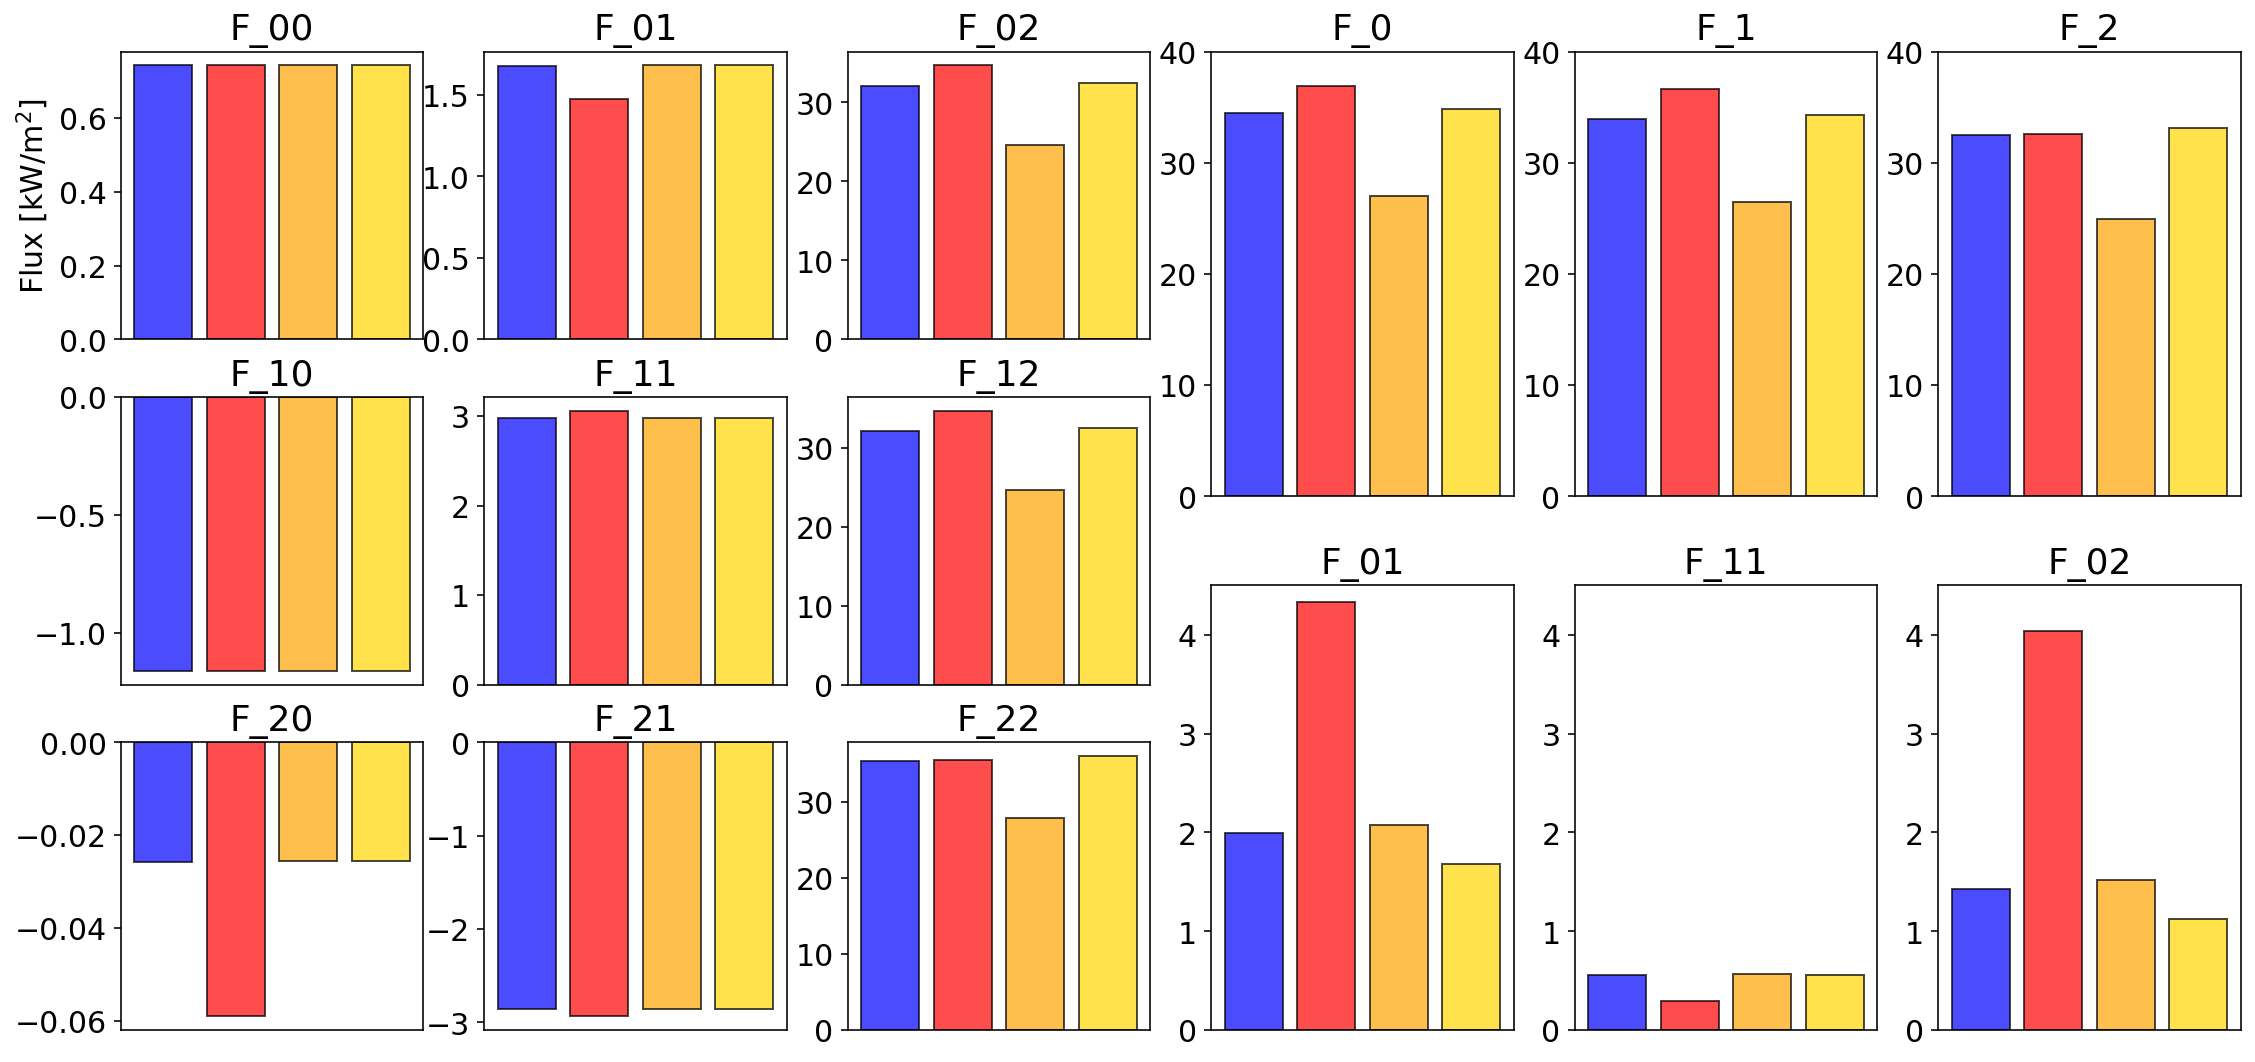

In [62]:
# Comparision btw. results
label = ['2-int', '1-int', '1-int-wave', '1-int-optd']
frs = [fr0/1e3, fr2/1e3, fr3/1e3, fr4/1e3]

fig = plt.figure(figsize=(19,9))
colors = ['blue', 'red', 'orange', 'gold']

ax1, ax2, ax3 = fig.add_subplot(3,6,1), fig.add_subplot(3,6,2), fig.add_subplot(3,6,3)
ax4, ax5, ax6 = fig.add_subplot(3,6,7), fig.add_subplot(3,6,8), fig.add_subplot(3,6,9)
ax7, ax8, ax9 = fig.add_subplot(3,6,13), fig.add_subplot(3,6,14), fig.add_subplot(3,6,15)
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

ax11, ax12, ax13 = fig.add_subplot(2,6,4), fig.add_subplot(2,6,5), fig.add_subplot(2,6,6)
ax21, ax22, ax23 = fig.add_subplot(2,6,10), fig.add_subplot(2,6,11), fig.add_subplot(2,6,12)
axes1 = [ax11, ax12, ax13]
axes2 = [ax21, ax22, ax23]

for i, ax in enumerate(axes):
    data = []
    for fr in frs:
        data.append(fr[i])
    ax.bar(label, data, color=colors, alpha=0.7, edgecolor='black')
    ax.set_title(f'F_{i//3}{i%3}')
    ax.get_xaxis().set_visible(False)
ax1.set_ylabel(r'Flux [kW/m$^2$]')

for j, ax in enumerate(axes1):
    data = []
    for i, fr in enumerate(frs):
        if j == 0:
            data.append(fr[0] + fr[1] + fr[2])
        elif j == 1:
            data.append(fr[3] + fr[4] + fr[5])
        elif j == 2 :
            data.append(fr[6] + fr[7] + fr[8])
    ax.bar(label, data, color=colors, alpha=0.7, edgecolor='black')    
    ax.get_xaxis().set_visible(False)
    ax.set_title(f'F_{j}')
    ax.set_ylim(0,40)

for j, ax in enumerate(axes2):
    data = []
    for i, fr in enumerate(frs):
        if j == 0:
            data.append(fr[0] + fr[1] + fr[2] - (fr[6] + fr[7] + fr[8]))
        elif j == 1:
            data.append(fr[0] + fr[1] + fr[2] - (fr[3] + fr[4] + fr[5]))
        elif j == 2 :
            data.append(fr[3] + fr[4] + fr[5] - (fr[6] + fr[7] + fr[8]))
    ax.bar(label, data, color=colors, alpha=0.7, edgecolor='black')    
    ax.get_xaxis().set_visible(False)
    ax.set_title(f'F_{j%2}{round(j/2)+1}')
    ax.set_ylim(0,4.5)
        
#plt.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=500)
plt.show()

# FISS data (Chae et al. 2021 in prep.)
---

In [3]:
# import a FISS file and its corresponding parameters file.
db = None
Initialized = False

# Active Region
fiss_path = '/data/home/sskang/Documents/Data/FISS_20130717_AR_/fiss_data'
pars_path = '/data/home/sskang/Documents/Data/FISS_20130717_AR_/pars'

fHa = '/FISS_20130717_185221_A1_c.fts'
fCa = '/FISS_20130717_185222_B1_c.fts'
fHapars = '/FISS_20130717_185221_A1_par.fts'
fCapars = '/FISS_20130717_185222_B1_par.fts'

# Quiet Sun
fiss_path = '/data/home/sskang/Documents/Data/FISS_20170614_QS_/fiss_data'
pars_path = '/data/home/sskang/Documents/Data/FISS_20170614_QS_/pars'

fHa = '/FISS_20170614_171833_A1_c.fts'
fCa = '/FISS_20170614_171833_B1_c.fts'
fHapars = '/FISS_20170614_171833_A1_par.fts'
fCapars = '/FISS_20170614_171833_B1_par.fts'

fHa, fCa = fiss_path + fHa, fiss_path + fCa
fHapars, fCapars = pars_path + fHapars, pars_path + fCapars
print(fHa, fCa)
print(fHapars, fCapars)

if (db is None) and not Initialized:
    fissHa = FISS(fHa, absScale=False)   # 6562.82
    fissCa = FISS(fCa, absScale=False)   # 8542.09
    
    fissHa.data = np.flip(fissHa.data,1)
    fissCa.data = np.flip(fissCa.data,1)
    
    icont = fissHa.data[:,:,50]
    qs = icont > (icont.max()*0.7)
    fissHa.refProfile = fissHa.data[qs,:].mean(0)
    icont = fissCa.data[:,:, 50]
    qs = icont > (icont.max()*0.7)
    fissCa.refProfile = fissCa.data[qs,:].mean(0)
    
    del icont, qs
    Initialized = True

Fitted = True
if Fitted:
    db = fissDB(fissHa, fissCa, Aparfile=fHapars, Bparfile=fCapars)
else:
    db = fissDB(fissHa, fissCa)

/data/home/sskang/Documents/Data/FISS_20170614_QS_/fiss_data/FISS_20170614_171833_A1_c.fts /data/home/sskang/Documents/Data/FISS_20170614_QS_/fiss_data/FISS_20170614_171833_B1_c.fts
/data/home/sskang/Documents/Data/FISS_20170614_QS_/pars/FISS_20170614_171833_A1_par.fts /data/home/sskang/Documents/Data/FISS_20170614_QS_/pars/FISS_20170614_171833_B1_par.fts


[-499.994573414427, 474.93858502141296, -14.5, 14.5]
[-703.6267240474143, 580.1378778875855, -14.5, 14.5]


AttributeError: 'FigureManagerBase' object has no attribute 'window'

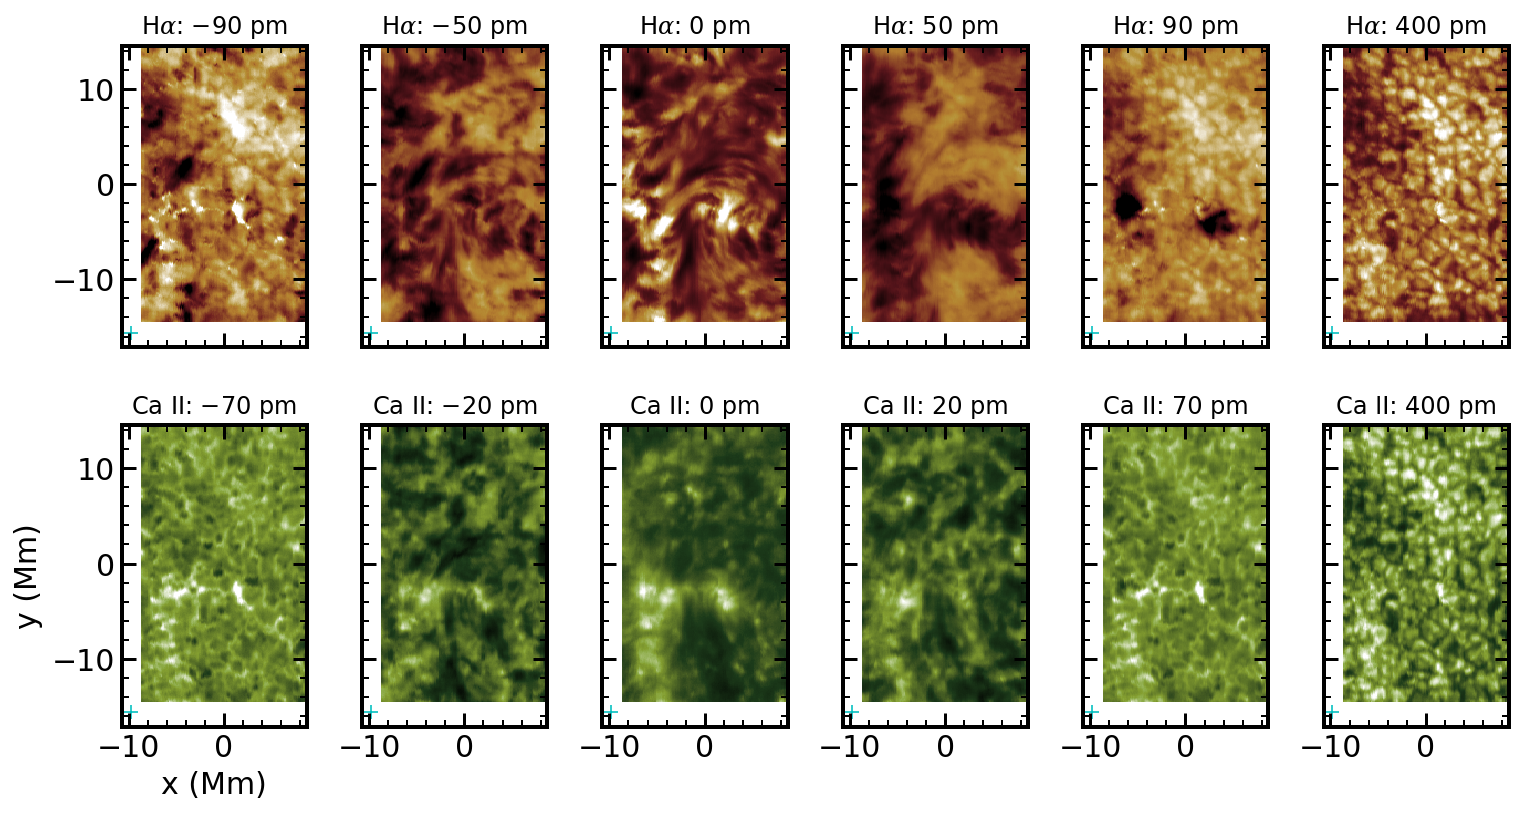

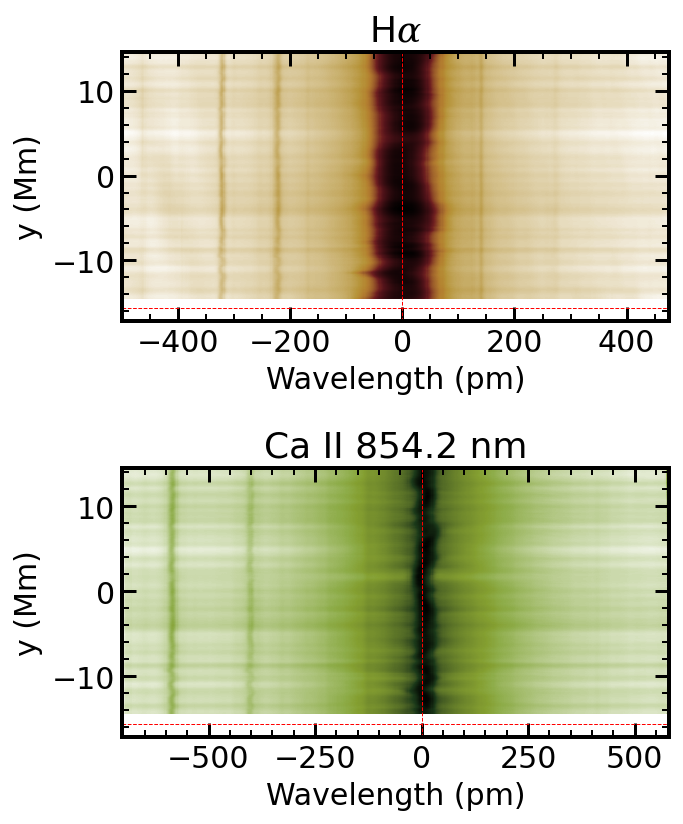

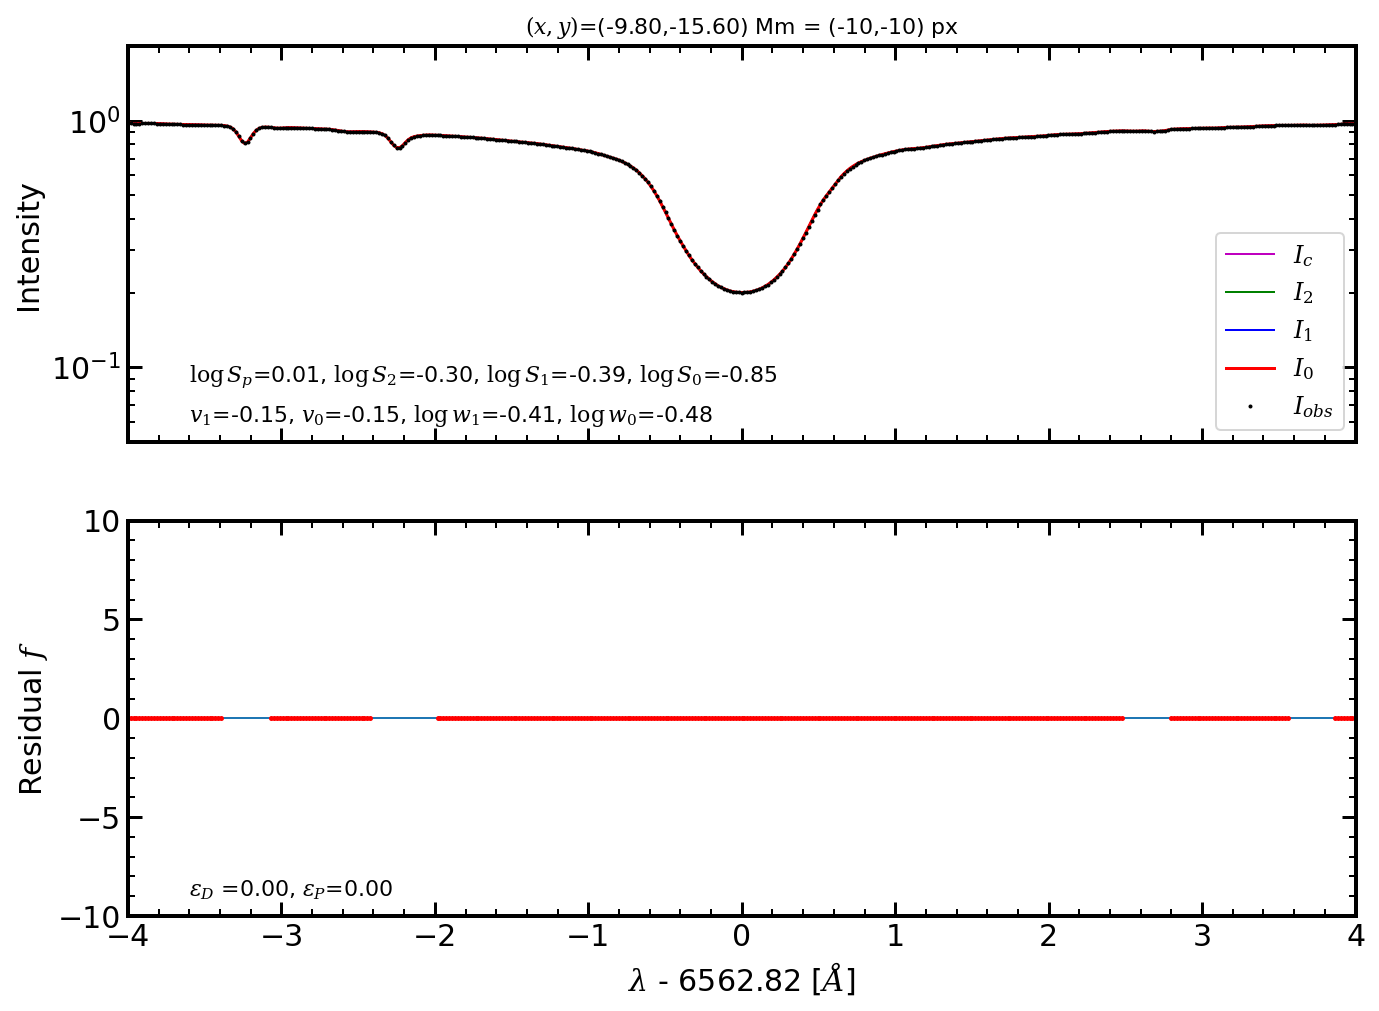

In [4]:
db.imshow(0,0)

## Flux direct calculation from FISS

In [4]:
db.parCa[:,195,74]

array([-1.26005755e-01,  4.30000000e-01, -1.27000000e+00,  1.32000000e+00,
        2.23460520e-03, -3.67490708e-01,  6.98970004e-01,  6.98970004e-01,
       -2.77493924e-01, -4.64212929e-01, -6.93438776e-01, -7.92449403e-01,
       -3.12704712e-01, -7.64941134e-01,  4.13889635e+00,  2.61559420e-01,
        2.44994229e-01])

In [108]:
# flux calculation of Ca II 8542 within [853.7 nm, 854.7nm]
wv_crit_Ca = 854.2 + 4.5 #nm

# refered to the Allen's Astrophysical Quantities
Ic_Ca = 1.94 * 0.403 + 1.58 * 0.597
Fc_Ca = Ic_Ca * np.pi * 10  # [kW/m^2/nm]
print(f"Ic_Ca = {Ic_Ca}, Fc_Ca = {Fc_Ca}")

i = 0
while db.fissCa.wave[i] > 4.5:
    i += 1
    if db.fissCa.wave[i] <= 4.5:
        m = db.fissCa.wave[i-1] - 4.5
        n = 4.5 - db.fissCa.wave[i]
        print(m, n)
        inten_ref_Ca = (m * db.fissCa.refProfile[i] + n * db.fissCa.refProfile[i-1])/(m+n)
        inten_tar_Ca = (m * db.fissCa.data[195,74,i] + n * db.fissCa.data[195,74,i-1])/(m+n)
print(f"intensity of reference = {inten_ref_Ca}, intensity of target = {inten_tar_Ca}")

#k_Ca = 0.85 * Fc_Ca/inten_ref_Ca
k_Ca = Fc_Ca/inten_ref_Ca
print(f'k value of Ca = {k_Ca}')

fluxdensity = db.fissCa.data[195,74,:] * k_Ca

f_fluxdensity = interpolate.interp1d(854.2 + db.fissCa.wave, fluxdensity, kind='linear', fill_value='extrapolate')
int_bin = [853.7, 854.7]
result, error = integrate.quad(f_fluxdensity, int_bin[0],int_bin[1])
print(f"Flux = {result} +- {error} [kW/m^2]")

Ic_Ca = 1.7250800000000002, Fc_Ca = 54.19498654854681
0.003280738320099452 0.022394553718600996
intensity of reference = 7709.116869844798, intensity of target = 7862.249022248943
k value of Ca = 0.007029986373735942
Flux = 26.071187848545403 +- 0.0009612731575359606 [kW/m^2]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


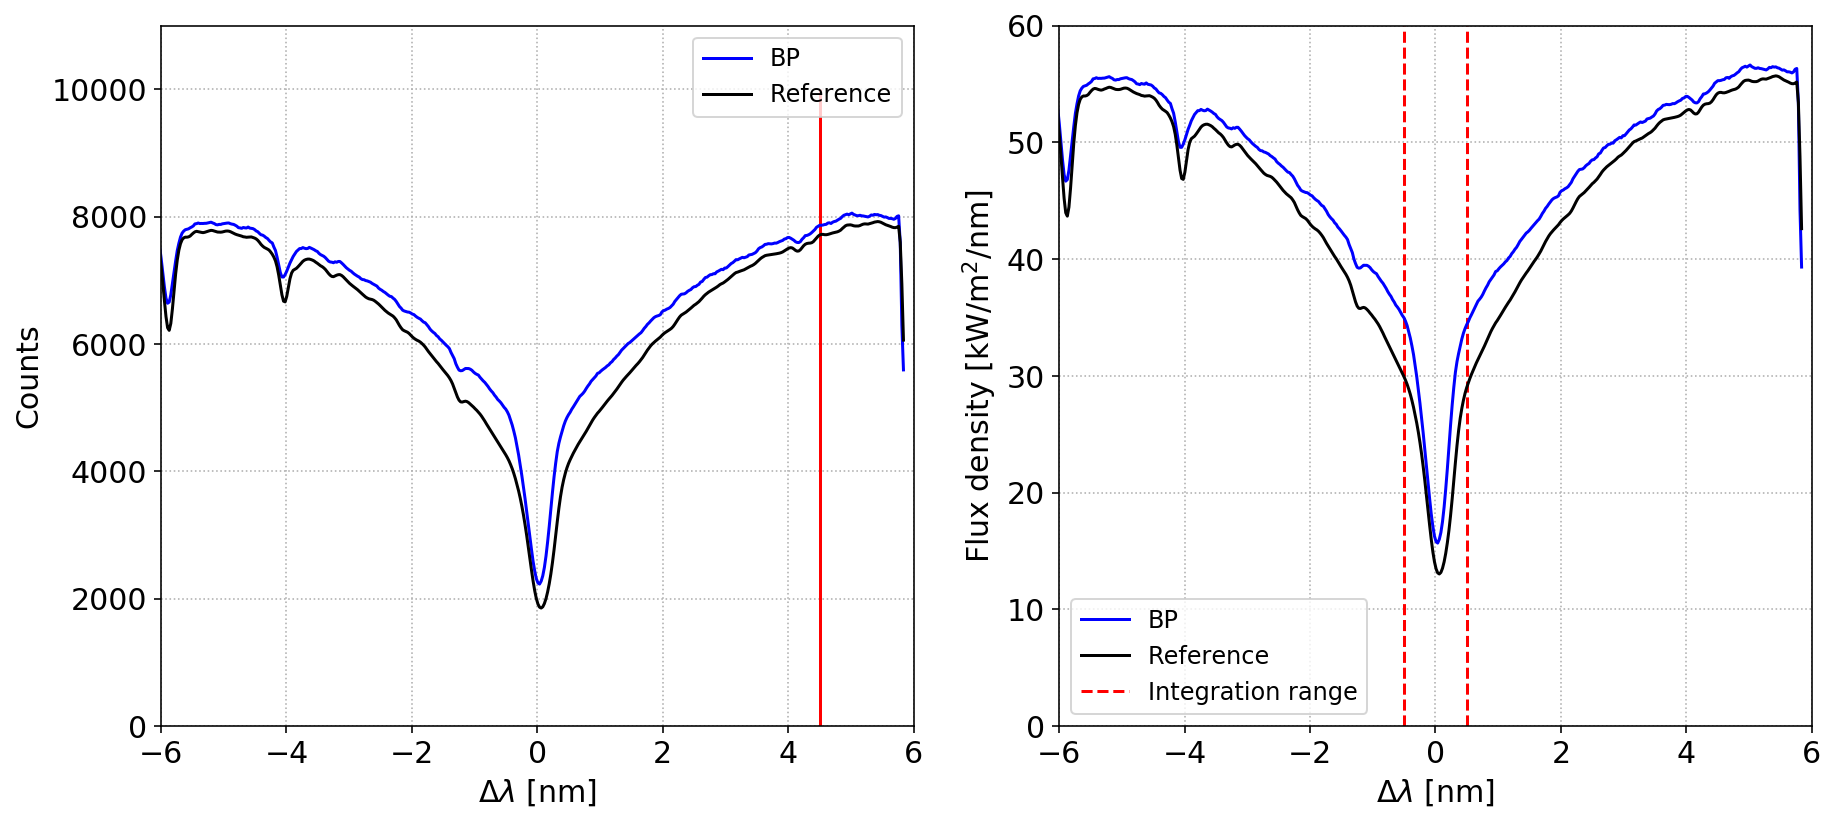

In [135]:
fig, ax = plt.subplots(1,2, figsize=(13, 6))

ax[0].plot(db.fissCa.wave, db.fissCa.data[195,74,:], color='blue', label='BP')
ax[0].plot(db.fissCa.wave, db.fissCa.refProfile, color='black', label='Reference')
ax[0].vlines(4.5, ymin=0, ymax=1e4, color='red')

ax[0].set_xlabel(r'$\Delta\lambda$ [nm]')
ax[0].set_ylabel('Counts')
ax[0].set_xlim(-6,6)
ax[0].set_ylim(0,1.1e4)
ax[0].legend()
ax[0].grid(ls=':')

ax[1].plot(db.fissCa.wave, k_Ca * db.fissCa.data[195,74,:], color='blue', label='BP')
ax[1].plot(db.fissCa.wave, k_Ca * db.fissCa.refProfile, color='black', label='Reference')
ax[1].vlines(-0.5, ymin=0, ymax=60, color='red', linestyle='--', label='Integration range')
ax[1].vlines(0.5, ymin=0, ymax=60, color='red', linestyle='--')

ax[1].set_xlabel(r'$\Delta\lambda$ [nm]')
ax[1].set_ylabel(r'Flux density [kW/m$^2$/nm]')
ax[1].set_xlim(-6,6)
ax[1].set_ylim(0,60)
ax[1].legend()
ax[1].grid(ls=':')

plt.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=500)
plt.show()

In [5]:
np.save('parCa.npy', db.parCa)

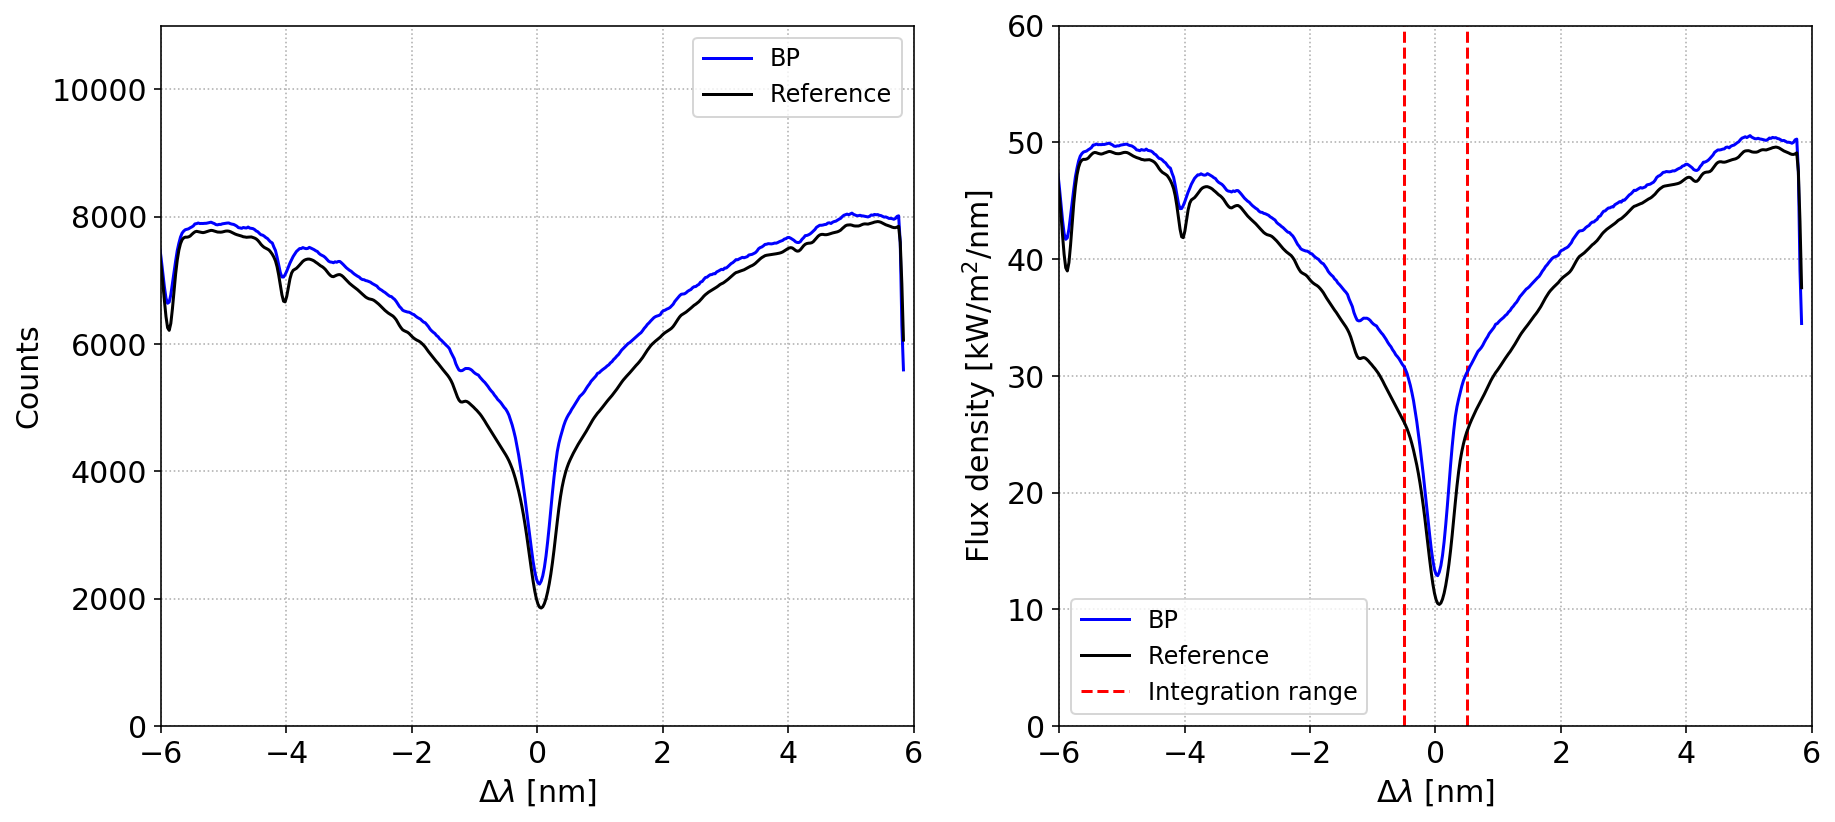

In [140]:
def fpure(wv, line='Ha'):
    if line == 'Ha':
        hw = 0.15
        pure = (abs(wv-6558.149) > hw) * (abs(wv-6559.580) > hw)  \
             * (abs(wv-6560.555) > hw) * (abs(wv-6560.68 ) > hw) \
             * (abs(wv-6561.097) > hw) * (abs(wv-6564.206) > hw)  \
             * (abs(wv-6564.1) > hw) * (abs(wv-6565.545 ) > hw)  
    if line == 'Ca':
        hw = 0.15
        pure =  (abs(wv-853.6165) > hw) * (abs(wv-853.645 ) > hw) \
            * (abs(wv-853.668 ) > hw) * (abs(wv-853.8015) > hw) \
            * (abs(wv-853.825 ) > hw)  \
            * (abs(wv-854.0817) > hw) * (abs(wv-854.6222) > hw) \
            * (abs(wv-854.8079) > hw)
    return pure

pure_Ca = fpure(854.2 + db.fissCa.wave, line='Ca')

def FissStray(pure, wv1, prof0, ref):
    ## Pre-processing
    epsilon=0.027
    prof0=(prof0-epsilon*ref) /((1-epsilon)*ref.max())
    
    zeta=0.03 #0.055
    prof0 = (prof0 -zeta*prof0.max())/(1.-zeta)
    
    con = pure * (abs(wv1) > 4.0)
    p1model=np.poly1d(np.polyfit(wv1[con], prof0[con], 1))
    p=p1model(wv1)
    intc=p.mean()
    if intc < 0.03: intc=0.03
    prof=prof0/p*intc
    
    return prof

prof_tar = FissStray(pure_Ca, db.fissCa.wave, db.fissCa.data[195,74,:], db.fissCa.refProfile)
prof_ref = FissStray(pure_Ca, db.fissCa.wave, db.fissCa.refProfile, db.fissCa.refProfile)

# Ca II 8542 line
factor = 17.6/1.05 # kW m-2 sr-1 nm-1
factor = factor * np.pi
prof_tar = prof_tar * factor
prof_ref = prof_ref * factor

fig, ax = plt.subplots(1,2, figsize=(13, 6))

ax[0].plot(db.fissCa.wave, db.fissCa.data[195,74,:], color='blue', label='BP')
ax[0].plot(db.fissCa.wave, db.fissCa.refProfile, color='black', label='Reference')

ax[0].set_xlabel(r'$\Delta\lambda$ [nm]')
ax[0].set_ylabel('Counts')
ax[0].set_xlim(-6,6)
ax[0].set_ylim(0,1.1e4)
ax[0].legend()
ax[0].grid(ls=':')

ax[1].plot(db.fissCa.wave, prof_tar, color='blue', label='BP')
ax[1].plot(db.fissCa.wave, prof_ref, color='black', label='Reference')
ax[1].vlines(-0.5, ymin=0, ymax=60, color='red', linestyle='--', label='Integration range')
ax[1].vlines(0.5, ymin=0, ymax=60, color='red', linestyle='--')

ax[1].set_xlabel(r'$\Delta\lambda$ [nm]')
ax[1].set_ylabel(r'Flux density [kW/m$^2$/nm]')
ax[1].set_xlim(-6,6)
ax[1].set_ylim(0,60)
ax[1].legend()
ax[1].grid(ls=':')

plt.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=500)
plt.show()

## Parameter space
Present the whole parameters ranges using a corner plot.

{'data': (140388209397760, False), 'strides': None, 'descr': [('', '<f8')], 'typestr': '<f8', 'shape': (37500, 4), 'version': 3}


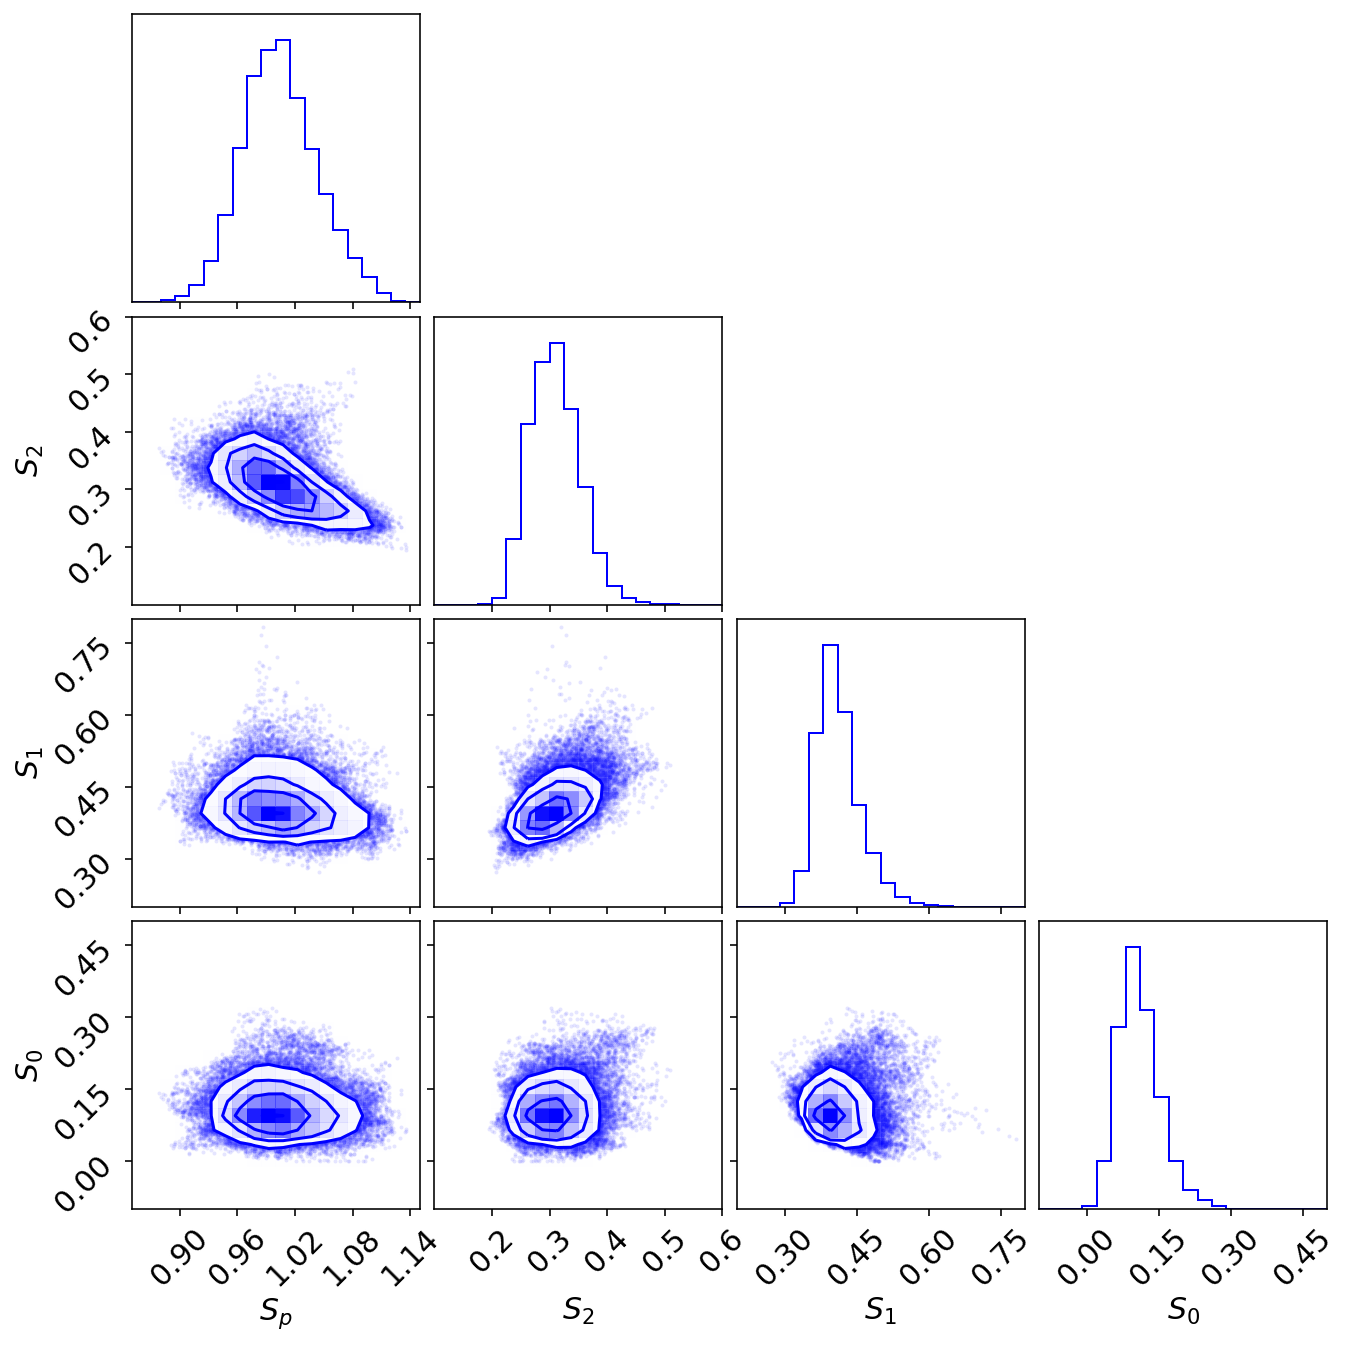

In [61]:
#ndim, nsamples = 3, 5000
#np.random.seed(1)
#samples = np.random.randn(ndim * nsamples).reshape([nsamples, ndim])

samples = 10**db.parCa[4,:,:].reshape(-1,1)
samples = np.append(samples, 10**db.parCa[5,:,:].reshape(-1,1), axis=1)
samples = np.append(samples, 10**db.parCa[12,:,:].reshape(-1,1), axis=1)
samples = np.append(samples, 10**db.parCa[13,:,:].reshape(-1,1), axis=1)
print(samples.__array_interface__)

ranges = [(0.85,1.15), (0.1,0.6), (0.2,0.8), (-0.1,0.5)]
labels = [r'$S_p$', r'$S_2$', r'$S_1$', r'$S_0$']

fig = corner.corner(samples, range=ranges, labels=labels, color='blue')

{'data': (140481750044672, False), 'strides': None, 'descr': [('', '<f8')], 'typestr': '<f8', 'shape': (37500, 8), 'version': 3}


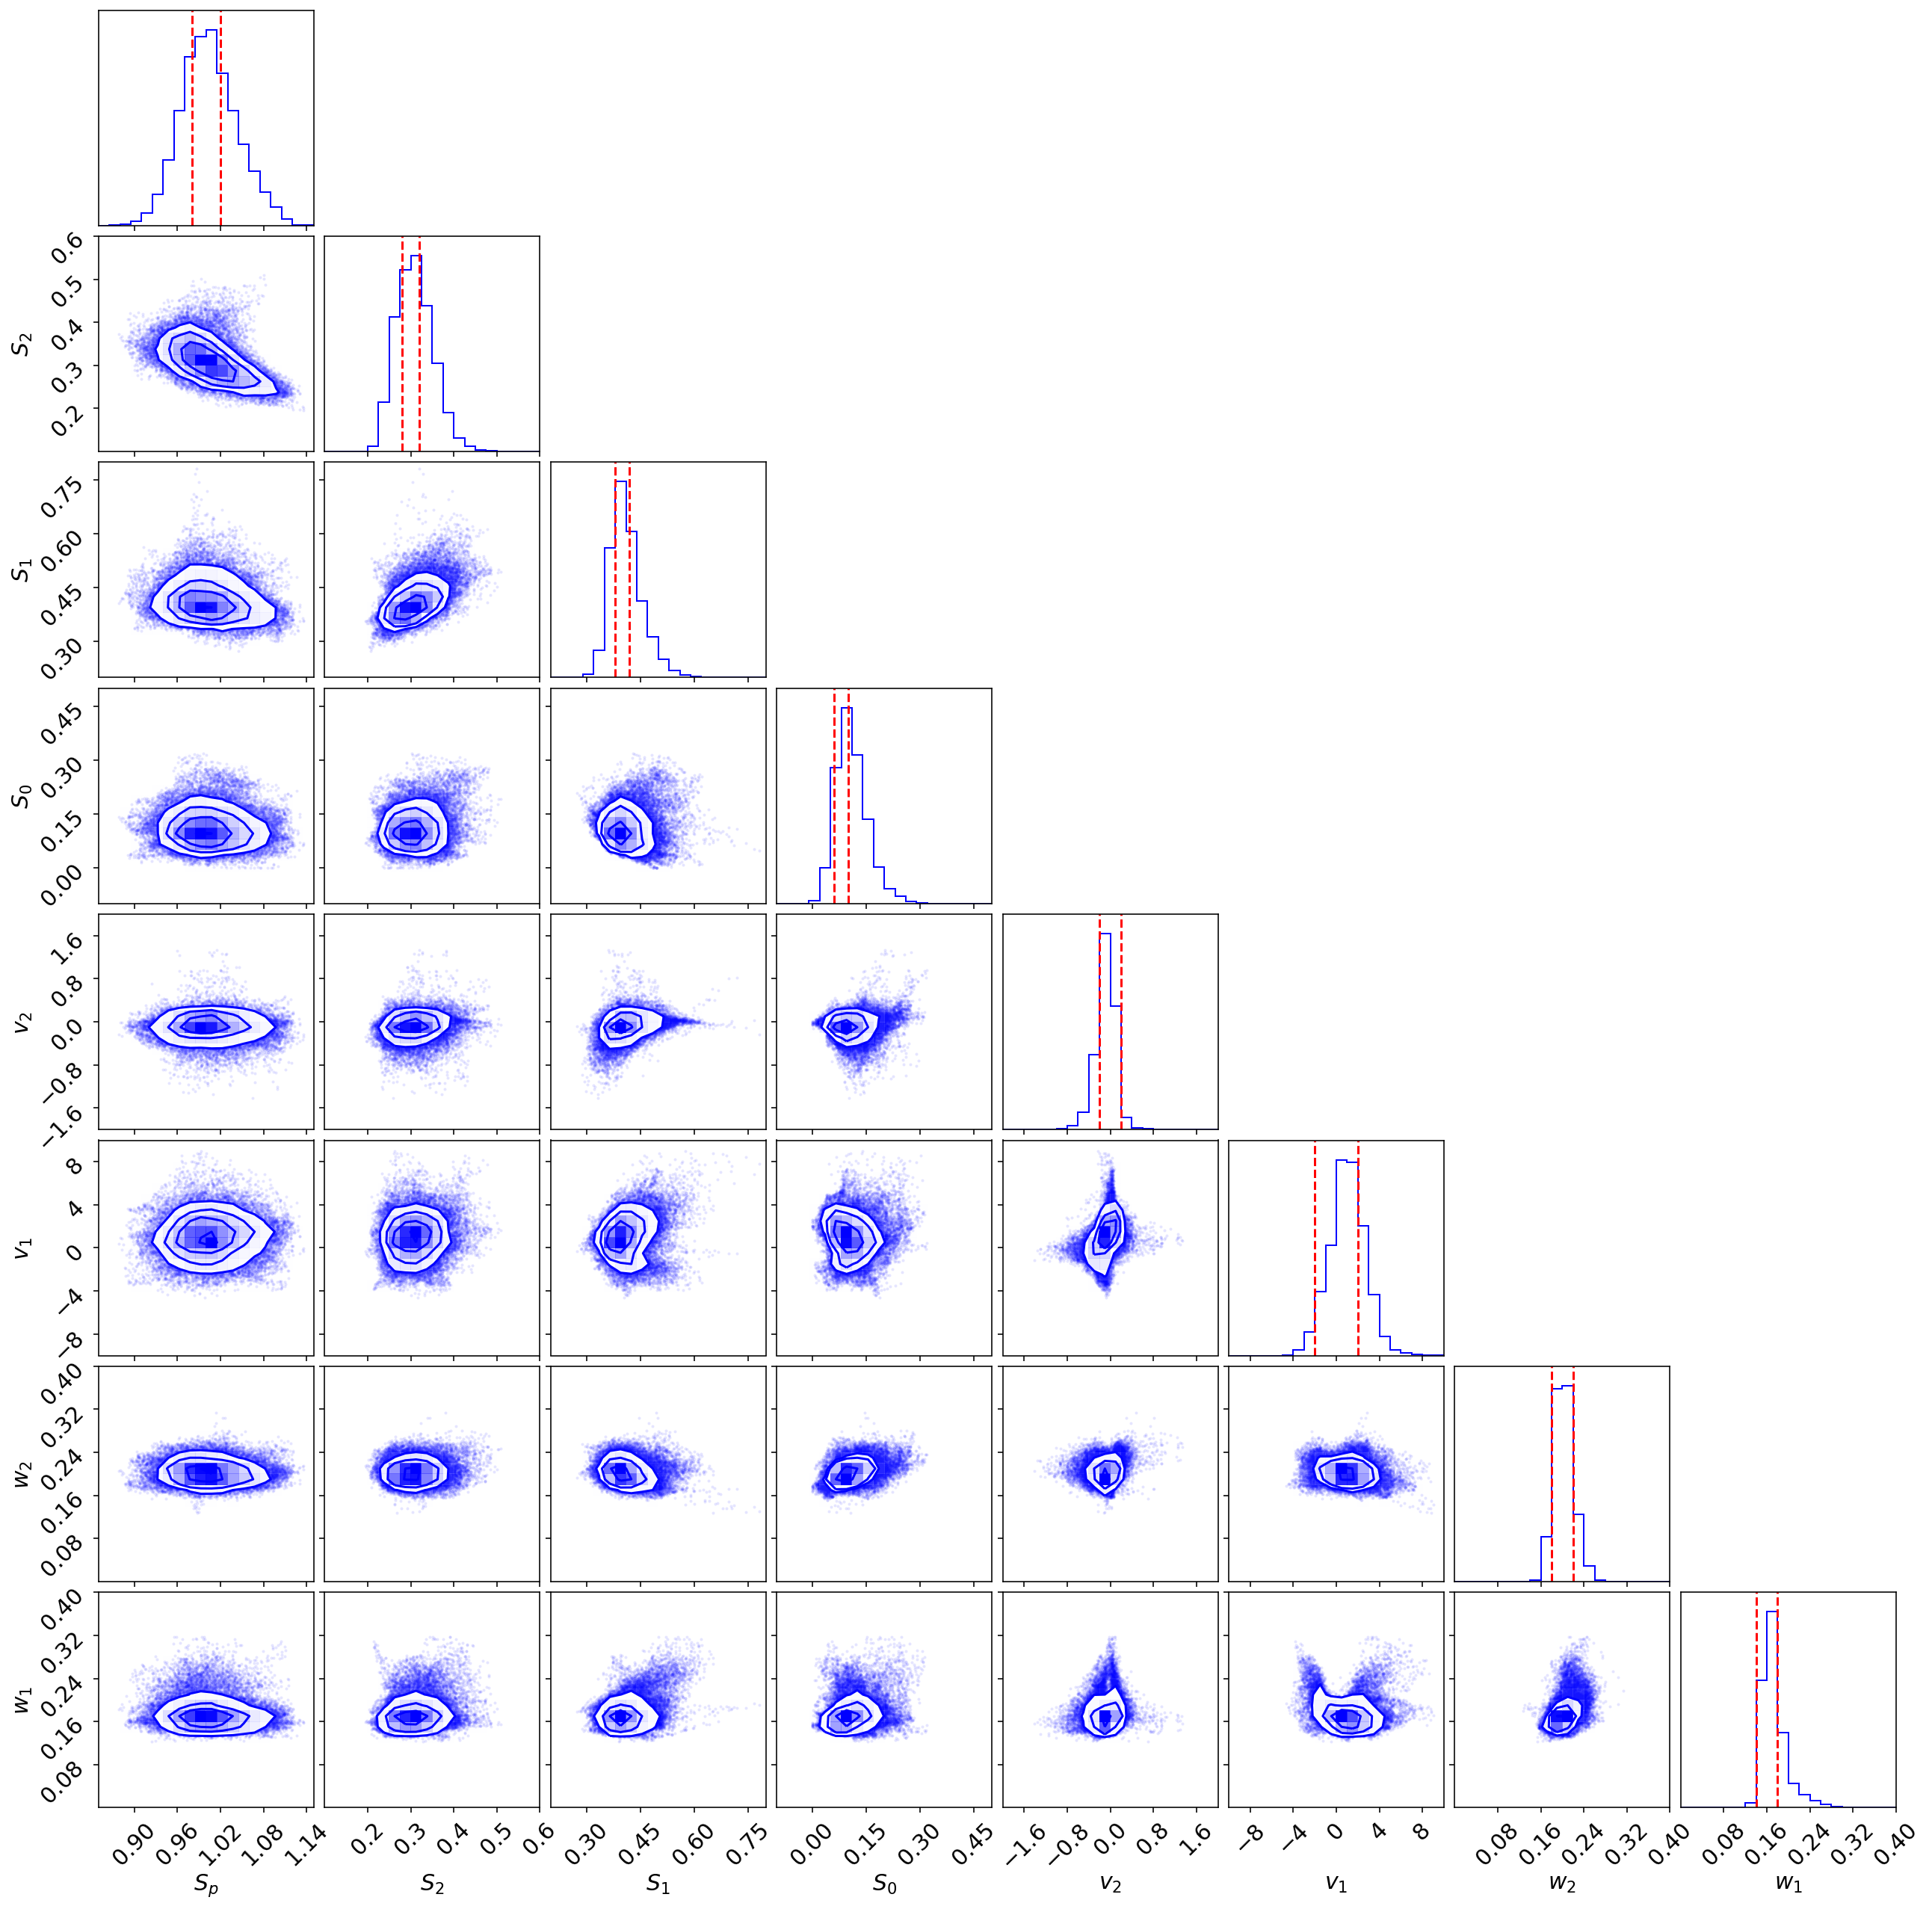

In [148]:
samples = 10**db.parCa[4,:,:].reshape(-1,1)
samples = np.append(samples, 10**db.parCa[5,:,:].reshape(-1,1), axis=1)
samples = np.append(samples, 10**db.parCa[12,:,:].reshape(-1,1), axis=1)
samples = np.append(samples, 10**db.parCa[13,:,:].reshape(-1,1), axis=1)

samples = np.append(samples, db.parCa[8,:,:].reshape(-1,1), axis=1)
samples = np.append(samples, db.parCa[9,:,:].reshape(-1,1), axis=1)
samples = np.append(samples, 10**db.parCa[10,:,:].reshape(-1,1), axis=1)
samples = np.append(samples, 10**db.parCa[11,:,:].reshape(-1,1), axis=1)
print(samples.__array_interface__)

ranges = [(0.85,1.15), (0.1,0.6), (0.2,0.8), (-0.1,0.5), (-2,2), (-10,10), (0,0.4), (0,0.4)]
labels = [r'$S_p$', r'$S_2$', r'$S_1$', r'$S_0$', r'$v_2$', r'$v_1$', r'$w_2$', r'$w_1$']
pars_supr = [1.02, 0.32, 0.42, 0.10,  0.2,  2, 0.22, 0.18]
pars_infm = [0.98, 0.28, 0.38, 0.06, -0.2, -2, 0.18, 0.14]

fig = corner.corner(samples, range=ranges, labels=labels, color='blue')

ndim = 8
axes = np.array(fig.axes).reshape((ndim, ndim))
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(pars_supr[i], color="r", linestyle='--')
    ax.axvline(pars_infm[i], color="r", linestyle='--')

## Parameter geometry

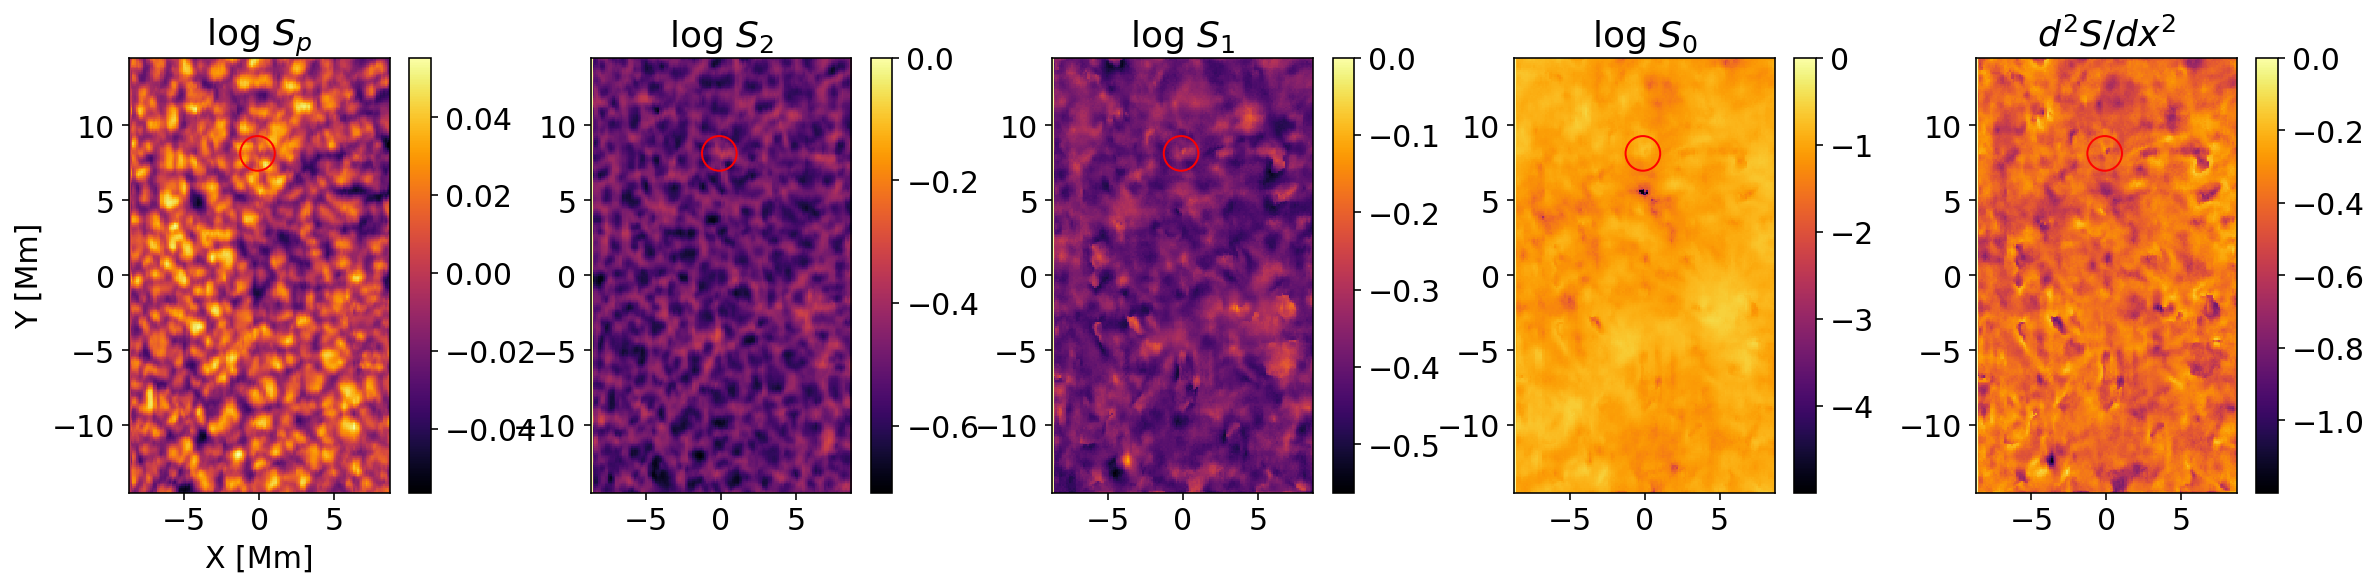

In [72]:
nx = np.shape(db.parCa)[-1]
ny = np.shape(db.parCa)[-2]
extent = np.array([-nx/2., nx/2., -ny/2., ny/2.])*0.16*0.725 # Mm

# position of the Bright Grain
pos_BG = [74,195]
pos_BG[0] = (2*pos_BG[0]/nx - 1) * extent[1]
pos_BG[1] = (2*pos_BG[1]/ny - 1) * extent[3]

fig, ax = plt.subplots(1, 5, figsize=(20,4))

# parameters map
params = [r'$\log\ S_p$', r'$\log\ S_2$', r'$\log\ S_1$', r'$\log\ S_0$', r'$d^2S/dx^2$']
number = [4,5,12,13,-1]

for i, par, num in zip(range(5), params, number):
    if num is -1:
        data = 10**db.parCa[5] - 2*10**db.parCa[12] + 10**db.parCa[13]
        im = ax[i].imshow(data, origin='lower', cmap='inferno', interpolation='nearest', extent=extent)
    else:
        im = ax[i].imshow(db.parCa[num], origin='lower', cmap='inferno', interpolation='nearest', extent=extent)
    fig.colorbar(im, ax=ax[i], shrink=1)
    ax[i].scatter(pos_BG[0],pos_BG[1], s=300, facecolor='none', edgecolor='r')
    ax[i].set_title(par)
    

# figure layout
ax[0].set_xlabel('X [Mm]')
ax[0].set_ylabel('Y [Mm]')

#plt.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=500)
plt.show()

# Ca II Bright Grains
---

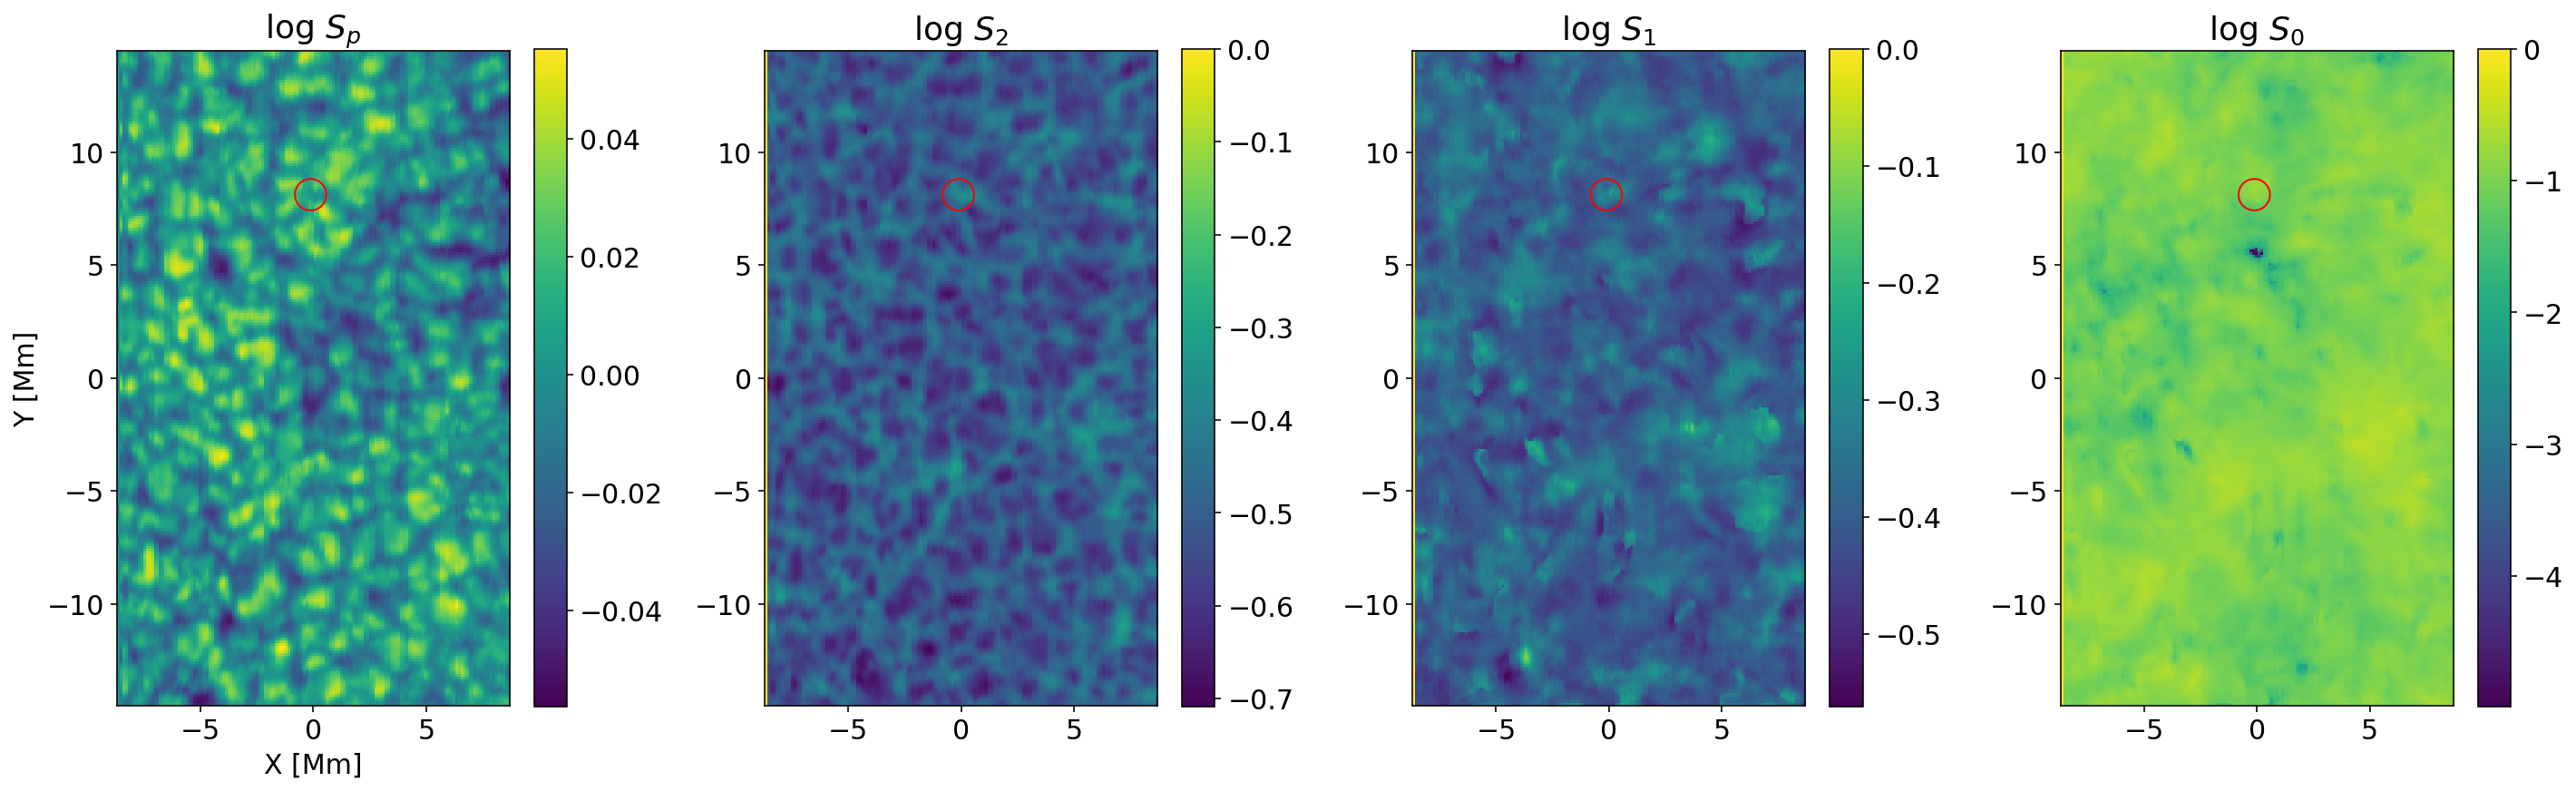

In [30]:
nx = np.shape(db.parCa)[-1]
ny = np.shape(db.parCa)[-2]
extent = np.array([-nx/2., nx/2., -ny/2., ny/2.])*0.16*0.725 # Mm

# position of the Bright Grain
pos_BG = [74,195]
pos_BG[0] = (2*pos_BG[0]/nx - 1) * extent[1]
pos_BG[1] = (2*pos_BG[1]/ny - 1) * extent[3]

fig, ax = plt.subplots(1, 4, figsize=(20,7))

# parameters map
params = [r'$\log\ S_p$', r'$\log\ S_2$', r'$\log\ S_1$', r'$\log\ S_0$']
number = [4,5,12,13]

for i, par, num in zip(range(4), params, number):
    im = ax[i].imshow(db.parCa[num], origin='lower', cmap='viridis', interpolation='nearest', extent=extent)
    fig.colorbar(im, ax=ax[i], shrink=0.79)
    ax[i].scatter(pos_BG[0],pos_BG[1], s=300, facecolor='none', edgecolor='r')
    ax[i].set_title(par)
    

# figure layout
ax[0].set_xlabel('X [Mm]')
ax[0].set_ylabel('Y [Mm]')

plt.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=500)
plt.show()

In [134]:
# Calculation Time depending on epsabs/epsrel
epsabss = [1e3, 3e1, 1e0, 3e-2, 1e-3, 3e-5, 1e-6, 1.49e-8]
caltime = []
fr1, fr2, fr3 = [], [], []
err1, err2, err3 = [], [], []

for epsabs in epsabss:
    t1 = time()
    fr,err = flux_calculator(db.parCa[:,195,74], line='Ca', epsabs=epsabs)
    t2 = time()
    caltime.append(t2-t1)
    fr1.append(fr[0] + fr[1] + fr[2])
    fr2.append(-fr[3] + fr[4] + fr[5])
    fr3.append(-fr[6] - fr[7] + fr[8])
    err1.append((err[0]**2 + err[1]**2 + err[2]**2)**0.5)
    err2.append((err[3]**2 + err[4]**2 + err[5]**2)**0.5)
    err3.append((err[6]**2 + err[7]**2 + err[8]**2)**0.5)

fr1, fr2, fr3 = np.array(fr1)/1e3, np.array(fr2)/1e3, np.array(fr3)/1e3

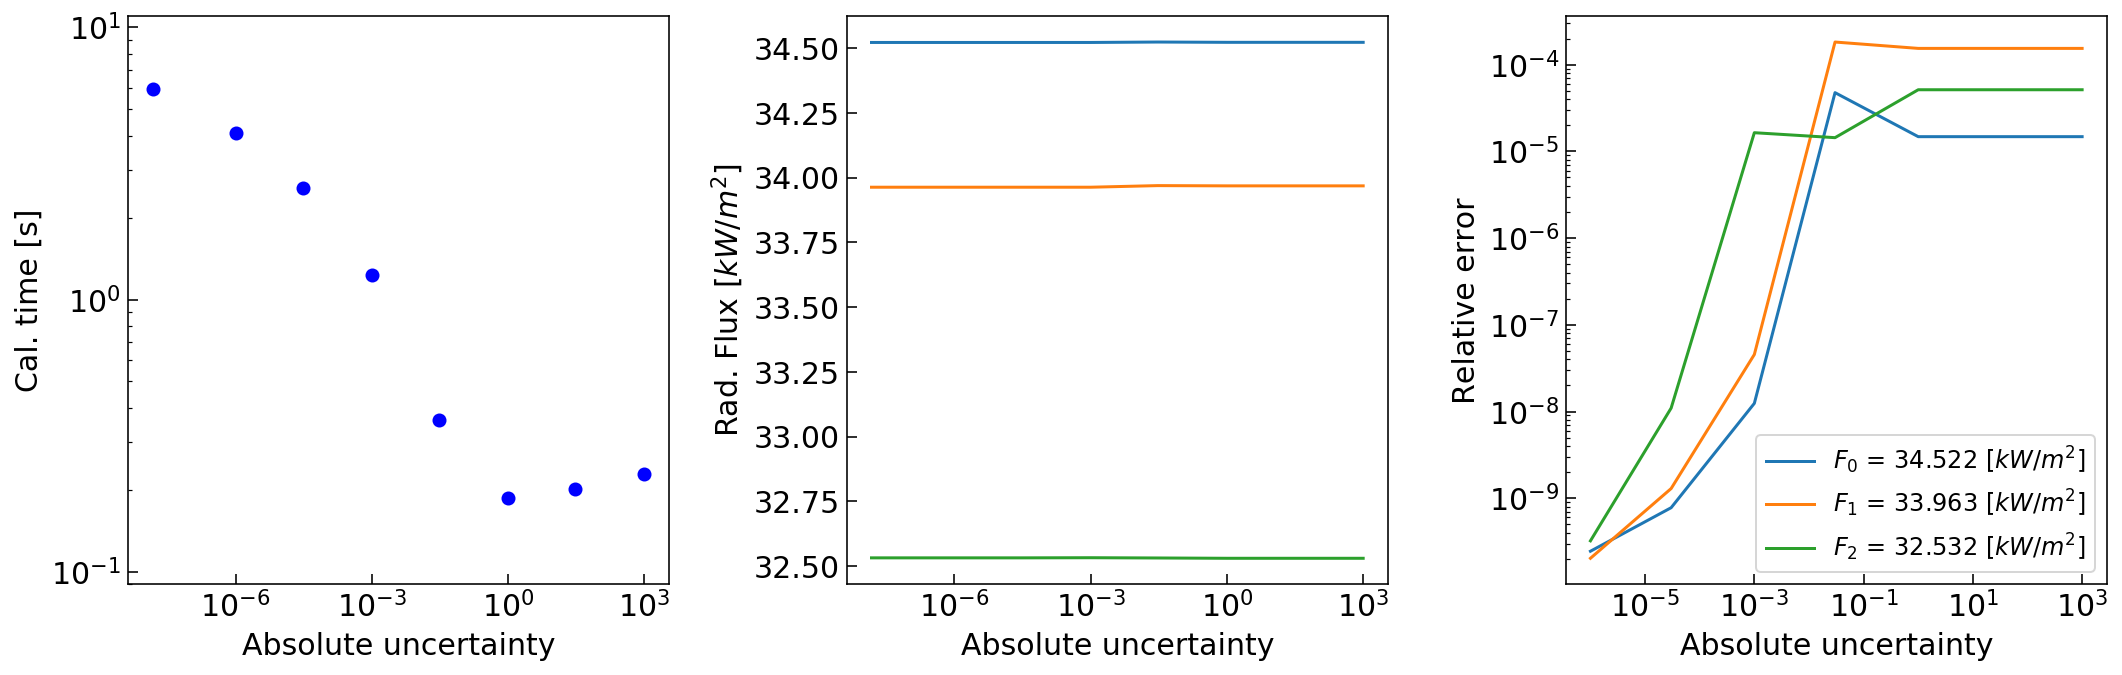

In [135]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].loglog(epsabss, caltime, 'bo')
ax[0].set_ylim(0.9e-1,1.1e1)
ax[0].set_xlabel('Absolute uncertainty')
ax[0].set_ylabel('Cal. time [s]')
ax[0].tick_params(which='both', direction='in')
ax[0].tick_params(which='major', length=5)

ax[1].semilogx(epsabss, fr1)
ax[1].semilogx(epsabss, fr2)
ax[1].semilogx(epsabss, fr3)
ax[1].set_ylim()
ax[1].set_xlabel('Absolute uncertainty')
ax[1].set_ylabel(r'Rad. Flux [$kW/m^2$]')
ax[1].tick_params(which='both', direction='in')
ax[1].tick_params(which='major', length=5)

ax[2].loglog(epsabss[:-1], abs(fr1/fr1[-1]-1)[:-1], label=rf'$F_0$ = {fr1[-1]:.3f} $[kW/m^2]$')
ax[2].loglog(epsabss[:-1], abs(fr2/fr2[-1]-1)[:-1], label=rf'$F_1$ = {fr2[-1]:.3f} $[kW/m^2]$')
ax[2].loglog(epsabss[:-1], abs(fr3/fr3[-1]-1)[:-1], label=rf'$F_2$ = {fr3[-1]:.3f} $[kW/m^2]$')
ax[2].set_xlabel('Absolute uncertainty')
ax[2].set_ylabel('Relative error')
ax[2].legend()
ax[2].tick_params(which='both', direction='in')
ax[2].tick_params(which='major', length=5)

plt.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=500)
plt.show()

In [136]:
# Calculation Time depending on epsabs/epsrel
epsrels = [5e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1.49e-8]
caltime = []
fr4, fr5, fr6 = [], [], []
err4, err5, err6 = [], [], []

for epsabs in epsabss:
    t1 = time()
    fr,err = flux_calculator(db.parCa[:,195,74], line='Ca', epsabs=epsabs)
    t2 = time()
    caltime.append(t2-t1)
    fr4.append(fr[0] + fr[1] + fr[2])
    fr5.append(-fr[3] + fr[4] + fr[5])
    fr6.append(-fr[6] - fr[7] + fr[8])
    err4.append((err[0]**2 + err[1]**2 + err[2]**2)**0.5)
    err5.append((err[3]**2 + err[4]**2 + err[5]**2)**0.5)
    err6.append((err[6]**2 + err[7]**2 + err[8]**2)**0.5)

fr4, fr5, fr6 = np.array(fr4)/1e3, np.array(fr5)/1e3, np.array(fr6)/1e3

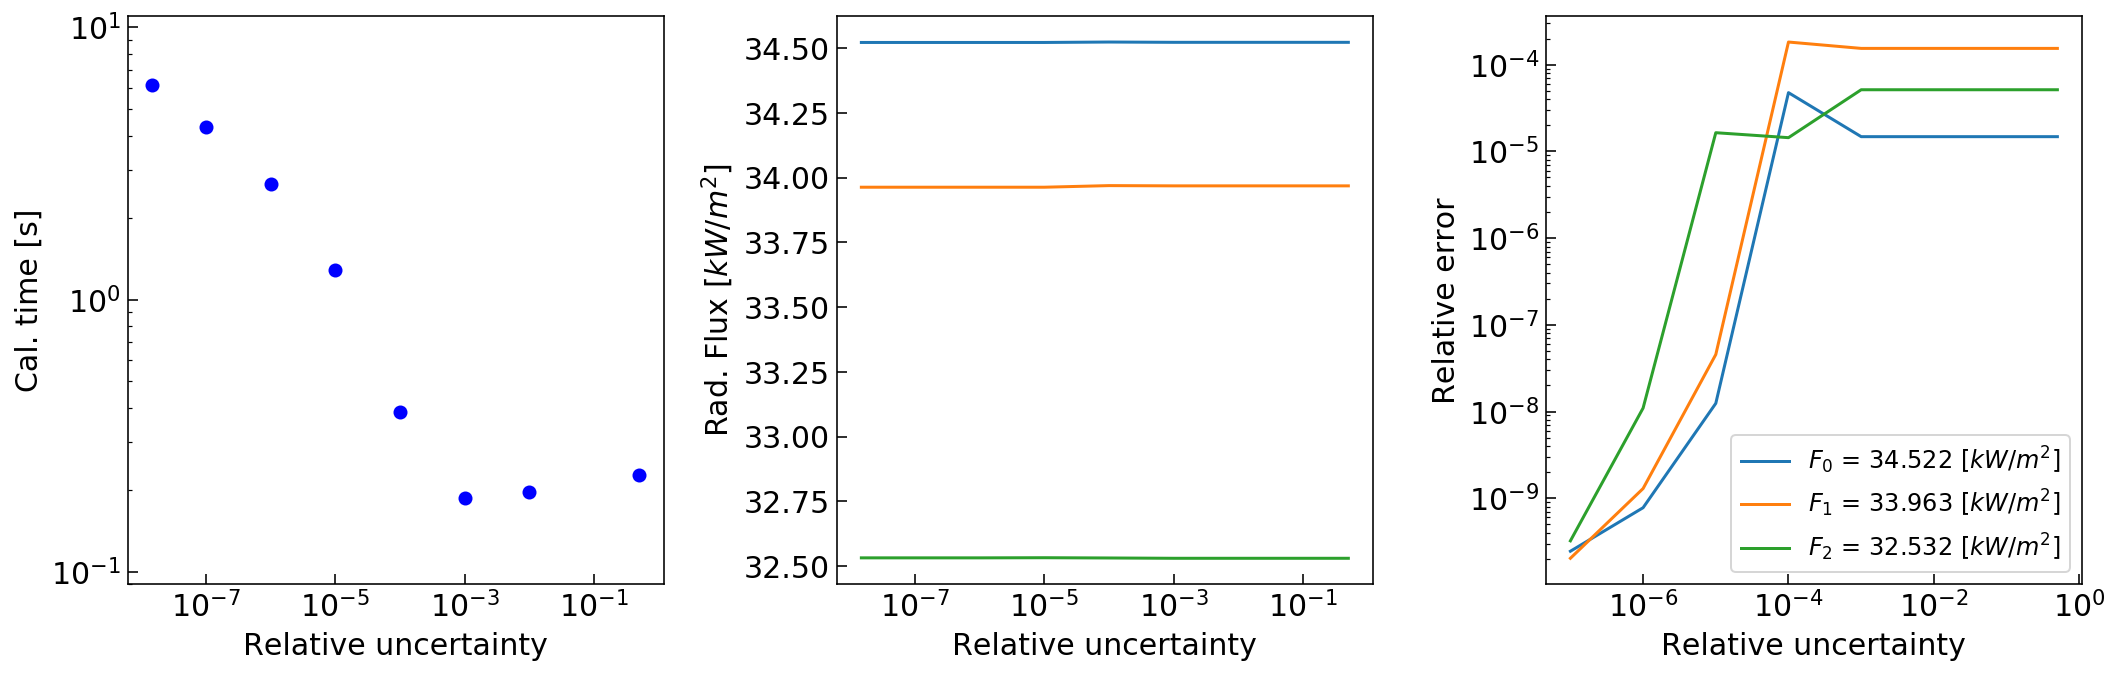

In [137]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].loglog(epsrels, caltime, 'bo')
ax[0].set_ylim(0.9e-1,1.1e1)
ax[0].set_xlabel('Relative uncertainty')
ax[0].set_ylabel('Cal. time [s]')
ax[0].tick_params(which='both', direction='in')
ax[0].tick_params(which='major', length=5)

ax[1].semilogx(epsrels, fr4)
ax[1].semilogx(epsrels, fr5)
ax[1].semilogx(epsrels, fr6)
ax[1].set_ylim()
ax[1].set_xlabel('Relative uncertainty')
ax[1].set_ylabel(r'Rad. Flux [$kW/m^2$]')
ax[1].tick_params(which='both', direction='in')
ax[1].tick_params(which='major', length=5)

ax[2].loglog(epsrels[:-1], abs(fr4/fr4[-1]-1)[:-1], label=rf'$F_0$ = {fr1[-1]:.3f} $[kW/m^2]$')
ax[2].loglog(epsrels[:-1], abs(fr5/fr5[-1]-1)[:-1], label=rf'$F_1$ = {fr2[-1]:.3f} $[kW/m^2]$')
ax[2].loglog(epsrels[:-1], abs(fr6/fr6[-1]-1)[:-1], label=rf'$F_2$ = {fr3[-1]:.3f} $[kW/m^2]$')
ax[2].set_xlabel('Relative uncertainty')
ax[2].set_ylabel('Relative error')
ax[2].legend()
ax[2].tick_params(which='both', direction='in')
ax[2].tick_params(which='major', length=5)

plt.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=500)
plt.show()

In [10]:
# Single Point Calculation from Calculator ver.2 with considering width of each layers
t1 = time()
fr = flux_calculator2(db.parCa[:,195,74], line='Ca')
t2 = time()
print(f'Time for one point = {(t2-t1):.2e} [sec]\n')

print(f'Radiative Flux matrix \n{fr.reshape((3,3))}\n')

print(f'F_0 = {(fr[0] + fr[1] + fr[2]):.3e} [W/m^2]')
print(f'F_1 = {(fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_2 = {(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]\n')

print(f'F_0 - F_2 = {(fr[0] + fr[1] + fr[2])-(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]')
print(f'F_0 - F_1 = {(fr[0] + fr[1] + fr[2])-(fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_1 - F_2 = {(fr[3] + fr[4] + fr[5])-(fr[6] + fr[7] + fr[8]):.3e} [W/m^2]')

Time for one point = 2.04e-03 [sec]

Radiative Flux matrix 
[[  740.9598204   1476.63683334 34661.66818813]
 [-1157.95873719  3057.44293712 34689.29480619]
 [  -59.02995064 -2931.78943667 35537.40947666]]

F_0 = 3.688e+04 [W/m^2]
F_1 = 3.659e+04 [W/m^2]
F_2 = 3.255e+04 [W/m^2]

F_0 - F_2 = 4.333e+03 [W/m^2]
F_0 - F_1 = 2.905e+02 [W/m^2]
F_1 - F_2 = 4.042e+03 [W/m^2]


In [179]:
# Single Point Calculation from Calculator ver.2 without considering width of each layers
t1 = time()
fr = flux_calculator2(db.parCa[:,195,74], line='Ca')
t2 = time()
print(f'Time for one point = {(t2-t1):.2e} [sec]\n')

print(f'Radiative Flux matrix \n{fr.reshape((3,3))}\n')

print(f'F_0 = {(fr[0] + fr[1] + fr[2]):.3e} [W/m^2]')
print(f'F_1 = {(-fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_2 = {(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]\n')

print(f'F_0 - F_2 = {(fr[0] + fr[1] + fr[2])-(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]')
print(f'F_0 - F_1 = {(fr[0] + fr[1] + fr[2])-(-fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_1 - F_2 = {(-fr[3] + fr[4] + fr[5])-(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]')

Time for one point = 1.43e-03 [sec]

Radiative Flux matrix 
[[  740.9598204   1476.63683334 34662.62194858]
 [ 1157.95873718  3057.44293274 34689.29363218]
 [   59.02995064  2931.78943259 35537.4094767 ]]

F_0 = 3.688e+04 [W/m^2]
F_1 = 3.659e+04 [W/m^2]
F_2 = 3.255e+04 [W/m^2]

F_0 - F_2 = 4.334e+03 [W/m^2]
F_0 - F_1 = 2.914e+02 [W/m^2]
F_1 - F_2 = 4.042e+03 [W/m^2]


In [182]:
# Single Point Calculation from Calculator ver.2 with less wavelength range without considering width of each layers
t1 = time()
fr = flux_calculator2(db.parCa[:,195,74], line='Ca')
t2 = time()
print(f'Time for one point = {(t2-t1):.2e} [sec]\n')

print(f'Radiative Flux matrix \n{fr.reshape((3,3))}\n')

print(f'F_0 = {(fr[0] + fr[1] + fr[2]):.3e} [W/m^2]')
print(f'F_1 = {(-fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_2 = {(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]\n')

print(f'F_0 - F_2 = {(fr[0] + fr[1] + fr[2])-(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]')
print(f'F_0 - F_1 = {(fr[0] + fr[1] + fr[2])-(-fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_1 - F_2 = {(-fr[3] + fr[4] + fr[5])-(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]')

Time for one point = 1.09e-03 [sec]

Radiative Flux matrix 
[[  740.9598204   1456.62150567 17316.6703196 ]
 [ 1157.95873718  3037.42760647 17344.29693496]
 [   59.02995064  2911.77475134 18186.86537277]]

F_0 = 1.951e+04 [W/m^2]
F_1 = 1.922e+04 [W/m^2]
F_2 = 1.522e+04 [W/m^2]

F_0 - F_2 = 4.298e+03 [W/m^2]
F_0 - F_1 = 2.905e+02 [W/m^2]
F_1 - F_2 = 4.008e+03 [W/m^2]


In [185]:
# Single Point Calculation from Calculator ver.2 without considering width of each layers, changing larger order of Gaussian quadrature
t1 = time()
fr = flux_calculator2(db.parCa[:,195,74], line='Ca')
t2 = time()
print(f'Time for one point = {(t2-t1):.2e} [sec]\n')

print(f'Radiative Flux matrix \n{fr.reshape((3,3))}\n')

print(f'F_0 = {(fr[0] + fr[1] + fr[2]):.3e} [W/m^2]')
print(f'F_1 = {(-fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_2 = {(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]\n')

print(f'F_0 - F_2 = {(fr[0] + fr[1] + fr[2])-(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]')
print(f'F_0 - F_1 = {(fr[0] + fr[1] + fr[2])-(-fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_1 - F_2 = {(-fr[3] + fr[4] + fr[5])-(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]')

Time for one point = 1.77e-03 [sec]

Radiative Flux matrix 
[[  741.44591851  1476.642005   34669.48210421]
 [ 1159.47059835  3059.72136322 34697.20409512]
 [   59.03006943  2933.7806378  35548.31902308]]

F_0 = 3.689e+04 [W/m^2]
F_1 = 3.660e+04 [W/m^2]
F_2 = 3.256e+04 [W/m^2]

F_0 - F_2 = 4.332e+03 [W/m^2]
F_0 - F_1 = 2.901e+02 [W/m^2]
F_1 - F_2 = 4.042e+03 [W/m^2]


In [188]:
# Single Point Calculation from Calculator ver.2 without considering width of each layers, changing much smaller epsrel of kernel
t1 = time()
fr = flux_calculator2(db.parCa[:,195,74], line='Ca')
t2 = time()
print(f'Time for one point = {(t2-t1):.2e} [sec]\n')

print(f'Radiative Flux matrix \n{fr.reshape((3,3))}\n')

print(f'F_0 = {(fr[0] + fr[1] + fr[2]):.3e} [W/m^2]')
print(f'F_1 = {(-fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_2 = {(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]\n')

print(f'F_0 - F_2 = {(fr[0] + fr[1] + fr[2])-(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]')
print(f'F_0 - F_1 = {(fr[0] + fr[1] + fr[2])-(-fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_1 - F_2 = {(-fr[3] + fr[4] + fr[5])-(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]')

Time for one point = 1.09e-03 [sec]

Radiative Flux matrix 
[[  740.9598204   1476.63683334 34661.66818813]
 [ 1157.95873719  3057.44293712 34689.29480619]
 [   59.02995064  2931.78943667 35537.40947666]]

F_0 = 3.688e+04 [W/m^2]
F_1 = 3.659e+04 [W/m^2]
F_2 = 3.255e+04 [W/m^2]

F_0 - F_2 = 4.333e+03 [W/m^2]
F_0 - F_1 = 2.905e+02 [W/m^2]
F_1 - F_2 = 4.042e+03 [W/m^2]


In [192]:
# modified kernel module
def gen_kernel(line='Ha'):
    x = np.linspace(0,1, 101)
    kernel = []
    
    # [v] = km/s, [w] = nm, [a]&[eta]&[tau] = None
    a1 = 0.0
    a2 = 0.3
    tau = 5.0
    c = 3e5 # km/s
    
    # different parameters of given line
    if line == 'Ha':
        ap = 10**1.1
        eta = 10**0.51
        int_bin = [-80,80] # integration range [dimensionless] 
        
    elif line == 'Ca':
        ap = 10**1.32
        eta = 10**0.43
        int_bin = [-120,120] # integration range [dimensionless]
        
    else:
        raise NameErorr('Wrong line inputting.')

    h1 = lambda y: tau * wofz(y-0.08196 + a1*1j).real / wofz(a1*1j).real
    h2 = lambda y: tau * wofz(y-0.01623 + a2*1j).real / wofz(a2*1j).real
    hp = lambda y: eta * wofz(y-0.06680 + ap*1j).real / wofz(ap*1j).real + 1
    
    for i in range(3):
        for j in range(3):
            ker = np.zeros(len(x))
            for k, xx in enumerate(x):
                if j==0:
                    if i==0:   f = lambda y: e2(xx*h1(y)            ) * h1(y)
                    elif i==1: f = lambda y: e2((1-xx)*h1(y)        ) * h1(y)
                    elif i==2: f = lambda y: e2((1-xx)*h1(y) + h2(y)) * h1(y)
                elif j==1:
                    if i==0:   f = lambda y: e2(h1(y) + xx*h2(y)) * h2(y)
                    elif i==1: f = lambda y: e2(        xx*h2(y)) * h2(y)
                    elif i==2: f = lambda y: e2(    (1-xx)*h2(y)) * h2(y)
                elif j==2:
                    if i==0:   f = lambda y: e2(h1(y) + h2(y) + xx*hp(y)) * hp(y)
                    elif i==1: f = lambda y: e2(        h2(y) + xx*hp(y)) * hp(y)
                    elif i==2: f = lambda y: e2(                xx*hp(y)) * hp(y)
                ker[k] = integrate.quad(f, int_bin[0],int_bin[1], epsrel=1e-3)[0]
            kernel.append(interpolate.interp1d(x, ker, kind='linear', fill_value='extrapolate'))
    
    return kernel

# Obtain kernel for the Ca II line
t1 = time()
KERNEL = gen_kernel(line='Ca')
t2 = time()
print(f'Time for obtaining one kernel = {(t2-t1):.2e} [sec]\n')
if KERNEL is not None:
    print('Kernel is all set!')

Time for obtaining one kernel = 2.86e+00 [sec]

Kernel is all set!


In [194]:
# Single Point Calculation from Calculator ver.2 with considering velocity of each layers 
t1 = time()
fr = flux_calculator2(db.parCa[:,195,74], line='Ca')
t2 = time()
print(f'Time for one point = {(t2-t1):.2e} [sec]\n')

print(f'Radiative Flux matrix \n{fr.reshape((3,3))}\n')

print(f'F_0 = {(fr[0] + fr[1] + fr[2]):.3e} [W/m^2]')
print(f'F_1 = {(-fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_2 = {(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]\n')

print(f'F_0 - F_2 = {(fr[0] + fr[1] + fr[2])-(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]')
print(f'F_0 - F_1 = {(fr[0] + fr[1] + fr[2])-(-fr[3] + fr[4] + fr[5]):.3e} [W/m^2]')
print(f'F_1 - F_2 = {(-fr[3] + fr[4] + fr[5])-(-fr[6] - fr[7] + fr[8]):.3e} [W/m^2]')

Time for one point = 1.57e-03 [sec]

Radiative Flux matrix 
[[  740.95982057  1477.5758048  34662.0285289 ]
 [ 1157.95873763  3057.44292906 34690.35356278]
 [   59.63399334  2931.78942906 35537.40928538]]

F_0 = 3.688e+04 [W/m^2]
F_1 = 3.659e+04 [W/m^2]
F_2 = 3.255e+04 [W/m^2]

F_0 - F_2 = 4.335e+03 [W/m^2]
F_0 - F_1 = 2.907e+02 [W/m^2]
F_1 - F_2 = 4.044e+03 [W/m^2]


In [147]:
# Boxed Area Calculation
FRR = np.zeros((30,30,9))
ERR = np.zeros((30,30,9))

t1 = time()
for i in range(30):
    if i%2 == 0: print(i)
    for j in range(30):
        FRR[i,j], ERR[i,j] = flux_calculator(db.parCa[:,195-15+i,74-15+j])
t2 = time()
print(f'Time for calculation = {(t2-t1):.3e} [sec] = {(t2-t1)/60:.1f} [min]')
print(f'Time for one point = {(t2-t1)/900:.3f} [sec]')

0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
Time for calculation = 1.465e+03 [sec] = 24.4 [min]


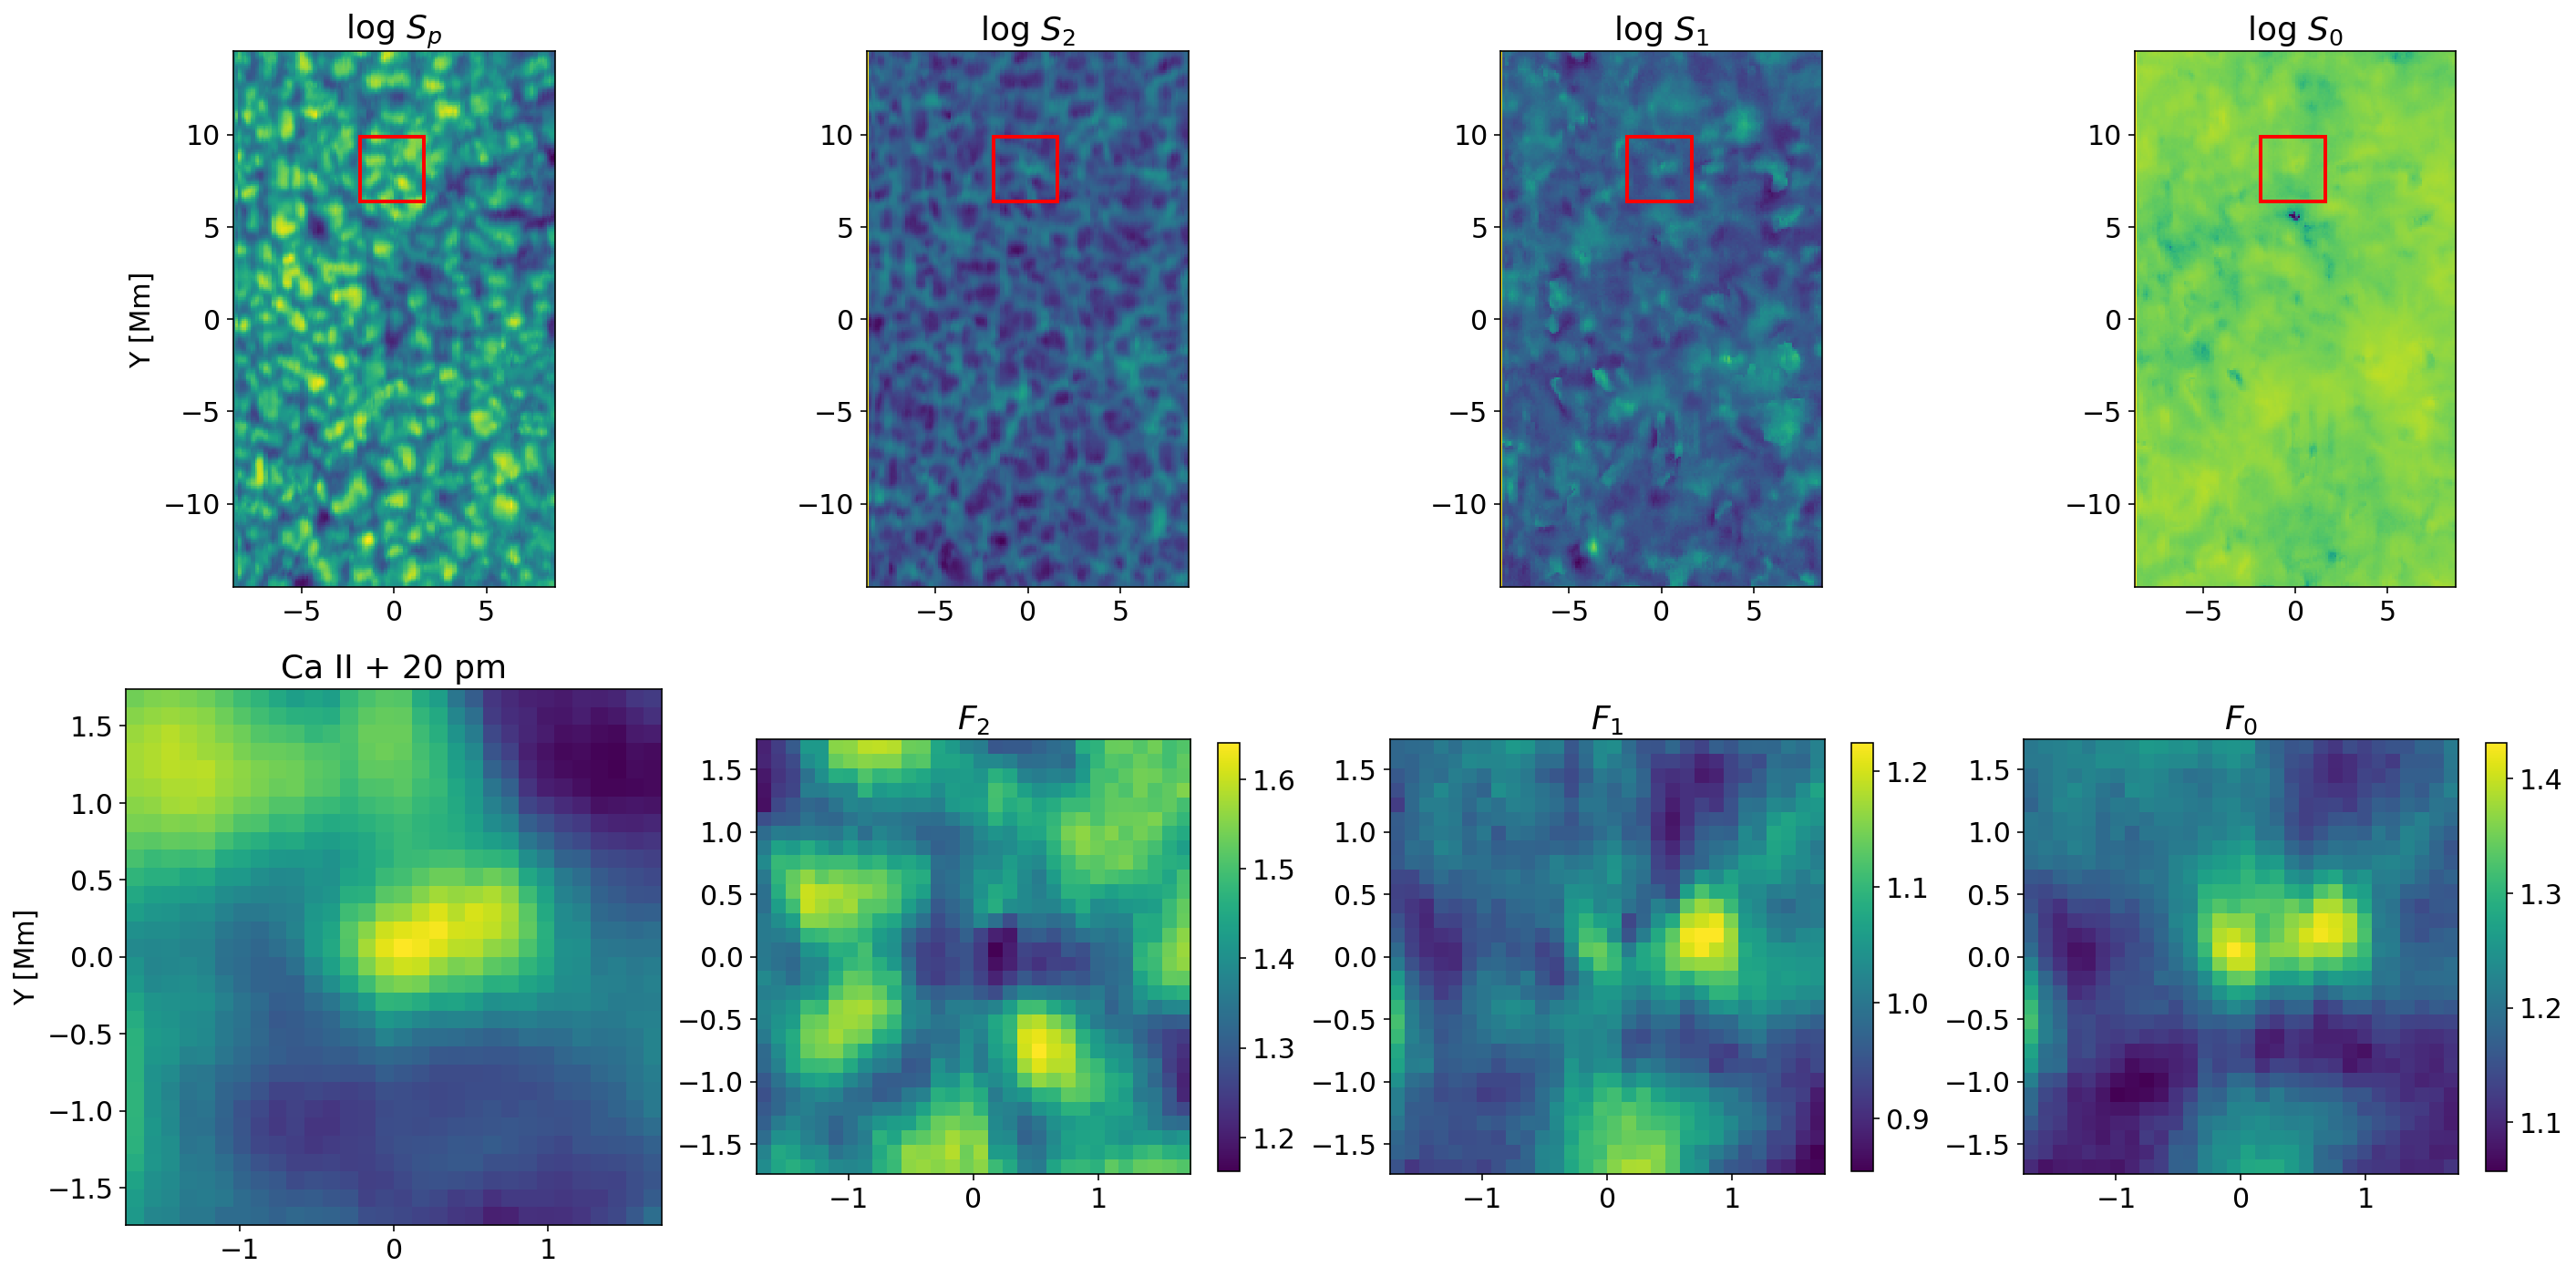

In [189]:
import matplotlib.patches as patches

nx = np.shape(db.parCa)[-1]
ny = np.shape(db.parCa)[-2]
nb = 30
extent1 = np.array([-nx/2., nx/2., -ny/2., ny/2.])*0.16*0.725
extent2 = np.array([-nb/2, nb/2, -nb/2, nb/2])*0.16*0.725

# position of the flux-calculated region
pos_fr = np.array([74-nx/2,195-ny/2]) * 0.16 * 0.725 
wid_fr = nb * 0.16 * 0.725

fig, ax = plt.subplots(2, 4, figsize=(20,10))

# parameter map
params = [r'$\log\ S_p$', r'$\log\ S_2$', r'$\log\ S_1$', r'$\log\ S_0$']
number = [4,5,12,13]

for i, par, num in zip(range(4), params, number):
    ax[0,i].imshow(db.parCa[num], origin='lower', interpolation='nearest', extent=extent1)
    ax[0,i].set_title(par)
    ax[0,i].add_patch(patches.Rectangle(pos_fr-wid_fr/2, wid_fr,wid_fr, color='r', fill=False, lw=2))

# flux map
titles = [r'Ca II + 20 pm', r'$F_2$', r'$F_1$', r'$F_0$']
raster = db.fissCa.getRaster(0.2, hw=0.05)[195-15:195+15,74-15:74+15]
flux2 = -FRRs[:,:,6]-FRRs[:,:,7]+FRRs[:,:,8]
flux1 = -FRRs[:,:,3]+FRRs[:,:,4]+FRRs[:,:,5]
flux0 = FRRs[:,:,0]+FRRs[:,:,1]+FRRs[:,:,2]
fluxes = [np.log10(raster), flux2, flux1, flux0]

for i, title, flux in zip(range(4), titles, fluxes):
    im = ax[1,i].imshow(flux, origin='lower', interpolation='nearest', extent=extent2)
    if i != 0:
        fig.colorbar(im, ax=ax[1,i], shrink=0.8)
    ax[1,i].set_title(title)

    
# figure layout
ax[0,0].set_ylabel('Y [Mm]')
ax[1,0].set_ylabel('Y [Mm]')

plt.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=500)
plt.show()

In [179]:
print(flux0[15,15]-flux1[15,15], flux1[15,15]-flux2[15,15])

0.30937239718827936 -0.146791471860499


In [1]:
import matplotlib.colors as colors
import matplotlib.patches as patches

nx = np.shape(db.parCa)[-1]
ny = np.shape(db.parCa)[-2]
nb = 30
extent1 = np.array([-nx/2., nx/2., -ny/2., ny/2.])*0.16*0.725
extent2 = np.array([-nb/2, nb/2, -nb/2, nb/2])*0.16*0.725

# position of the flux-calculated region
pos_fr = np.array([74-nx/2,195-ny/2]) * 0.16 * 0.725 
wid_fr = nb * 0.16 * 0.725

fig, ax = plt.subplots(1,2, figsize=(10,5))

# flux map
titles = [r'$F_1 - F_2$', r'$F_0 - F_1$']

flux2 = -FRRs[:,:,6]-FRRs[:,:,7]+FRRs[:,:,8]
flux1 = -FRRs[:,:,3]+FRRs[:,:,4]+FRRs[:,:,5]
flux0 = FRRs[:,:,0]+FRRs[:,:,1]+FRRs[:,:,2]
fluxes = [flux1-flux2, flux0-flux1]

for i, title, flux in zip(range(2), titles, fluxes):
    ax[i].imshow(flux, origin='lower', interpolation='nearest', extent=extent2, cmap='bwr')
    #ax[i].imshow(flux, origin='lower', interpolation='nearest', extent=extent2, cmap='bwr', norm=colors.Normalize(vmin=-0.5, vmax=0.5))
    ax[i].set_title(title)

    
# figure layout
ax[0].set_ylabel('Y [Mm]')
ax[0].set_xlabel('X [Mm]')

plt.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=500)
plt.show()

NameError: name 'np' is not defined

In [182]:
print(fluxes[0][15,15], fluxes[1][15,15])

-0.146791471860499 0.30937239718827936


# Pearson correlation coefficient
---

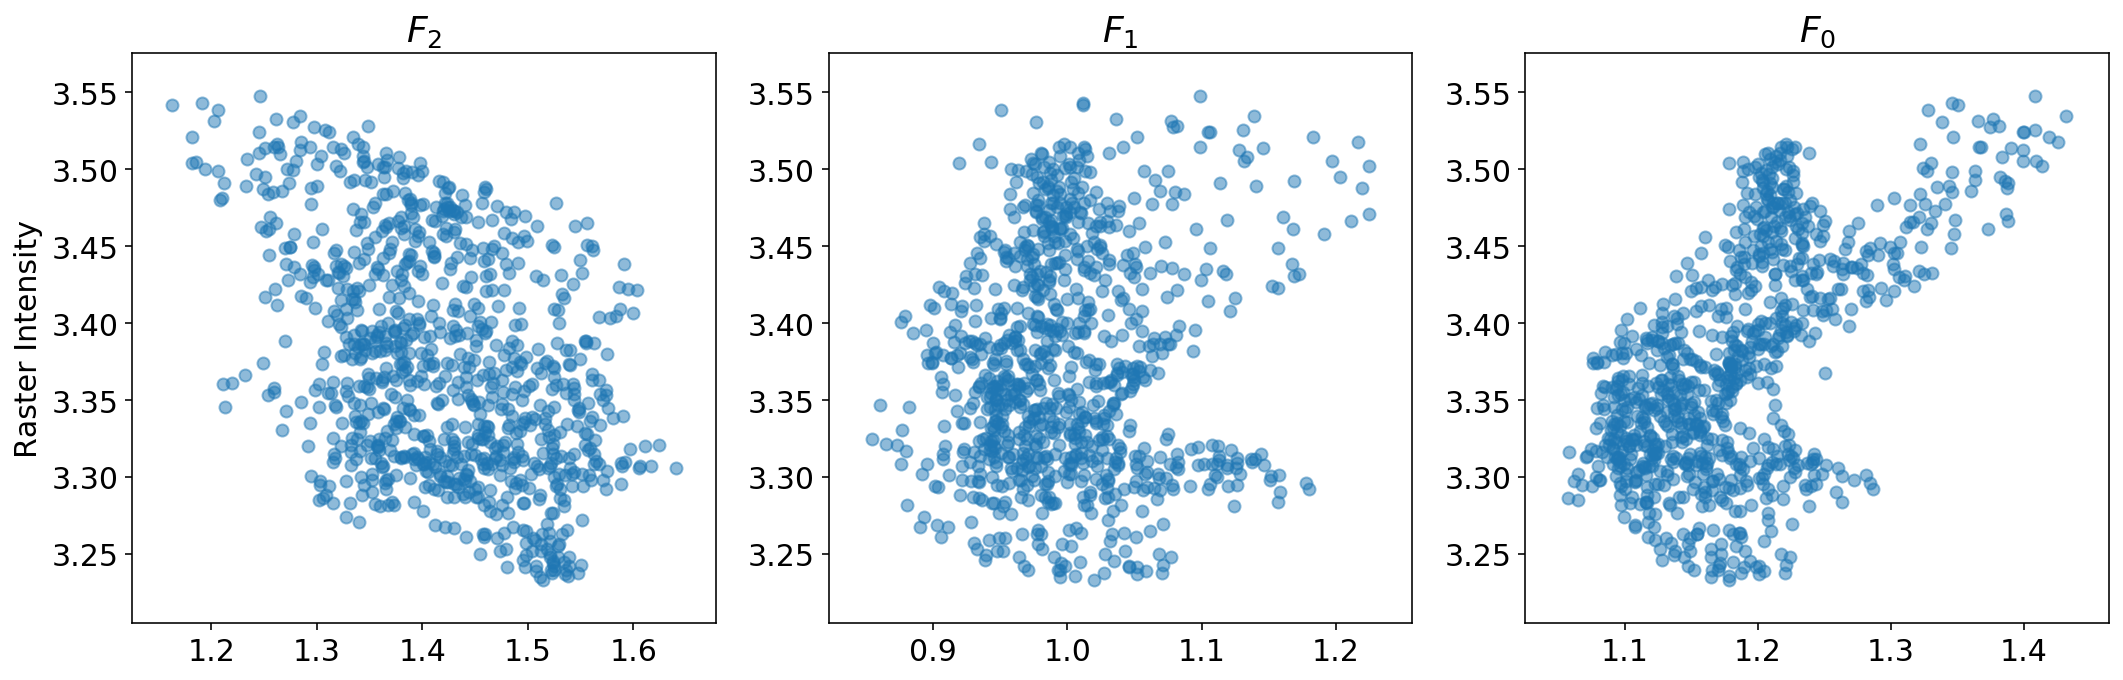

In [171]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

titles = [r'$F_2$', r'$F_1$', r'$F_0$']
fluxes = [flux2, flux1, flux0]

for i, flux, title in zip(range(3), fluxes, titles):
    ax[i].scatter(flux,np.log10(raster), alpha=0.5)
    ax[i].set_title(title)

ax[0].set_ylabel(r'Raster Intensity')

plt.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=500)
plt.show()

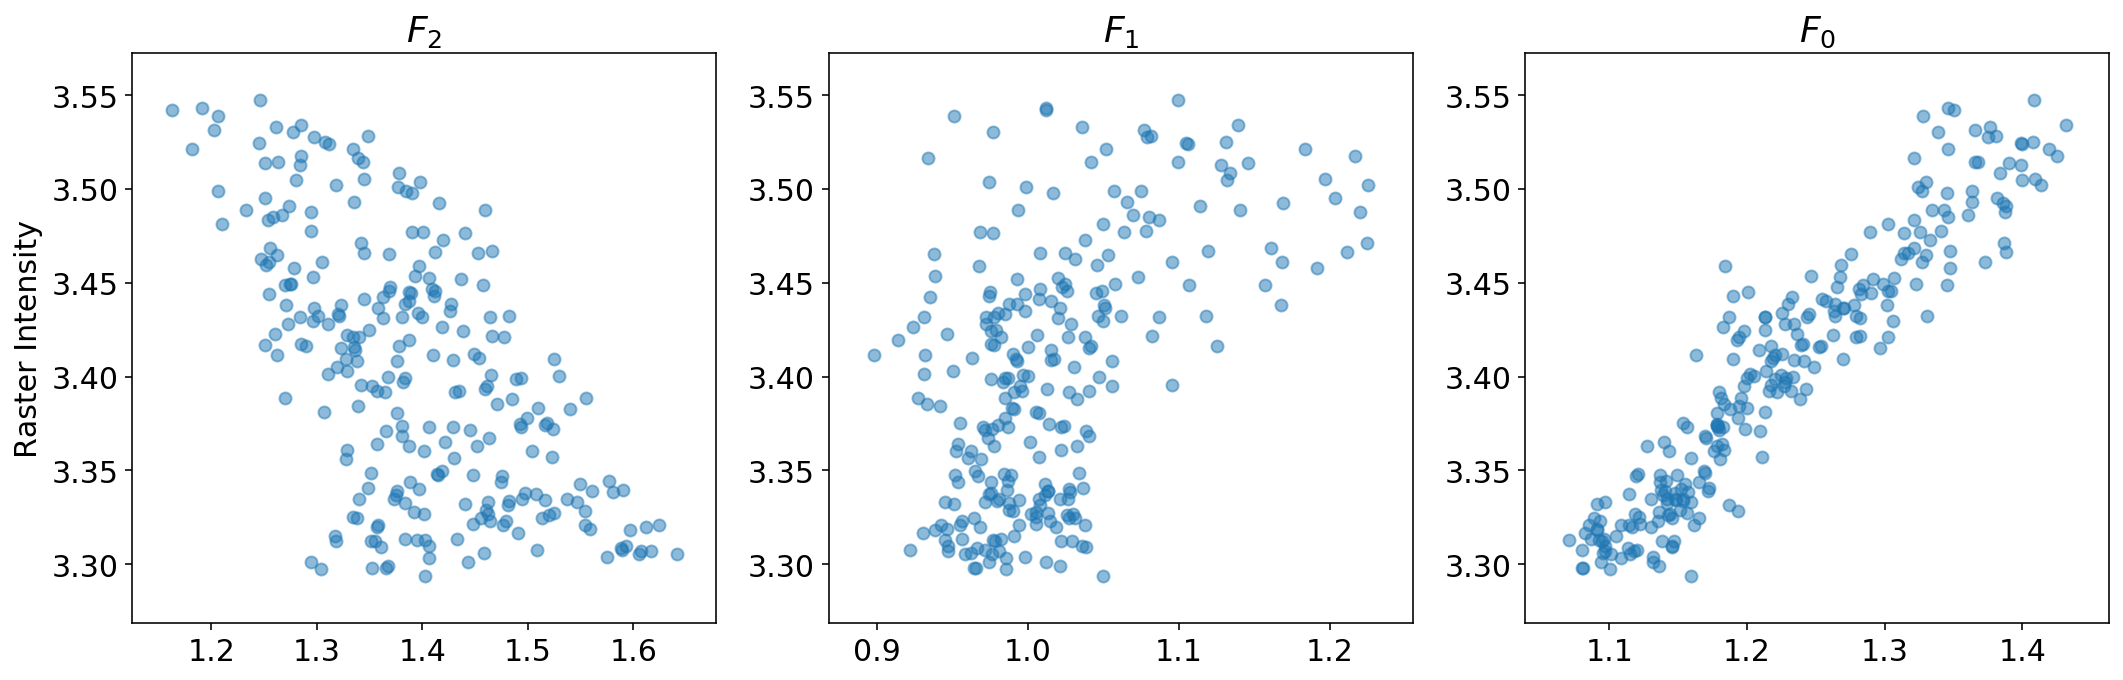

In [172]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

titles = [r'$F_2$', r'$F_1$', r'$F_0$']
fluxes = [flux2, flux1, flux0]

for i, flux, title in zip(range(3), fluxes, titles):
    ax[i].scatter(flux[7:23,7:23],np.log10(raster)[7:23,7:23], alpha=0.5)
    ax[i].set_title(title)

ax[0].set_ylabel(r'Raster Intensity')

plt.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=500)
plt.show()

In [3]:
tau = 5.0

# [S] = 
S0 = 0.24
S1 = 0.47
S2 = 0.37
Sp = 1.05

s1 = lambda x: S0 + (-3*S0+4*S1-S2)/2 * x + (S0-2*S1+S2)/2 * x**2
s2 = lambda x: S1 + (-S0+S2)/2 * x + (S0-2*S1+S2)/2 * x**2
s3 = lambda x: S2 + (Sp-S2) * x

# [v] = km/s, [w] = pm
v1 = 0.30
w1 = 16.3
a1 = 0.0
v2 = -0.13
w2 = 20.1
a2 = 0.3
vp = -0.02
wp = 10**0.84
ap = 10**1.10
eta = 10**0.51

def u(wv, v, w, line='Ca'):
    c = 3e5
    if line == 'Ha':
        wv0 = 656.3
    elif line == 'Ca':
        wv0 = 854.2
    else:
        raise NameError('Wrong line.')
    
    return (wv - (1+v/c)*wv0)/w

h1 = lambda y: tau * special.wofz(u(y,v1,w1) + a1*1j).real
h2 = lambda y: tau * special.wofz(u(y,v2,w2) + a2*1j).real
hp = lambda y: 1 + eta * special.wofz(u(y,vp,wp) + ap*1j).real

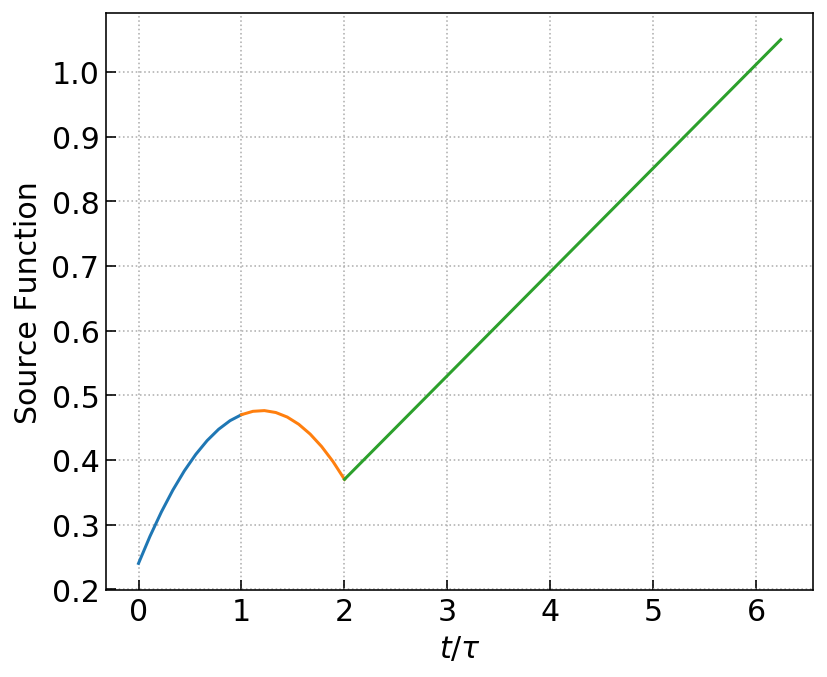

In [4]:
fig = plt.figure(figsize=(6,5))

x = np.linspace(0,1,10)

plt.plot(x,s1(x))
plt.plot(1+x,s2(x))
plt.plot(2+(1+eta)*x,s3(x))

plt.xlabel(r'$t/\tau$')
plt.ylabel(r'Source Function')
plt.tick_params(direction='in', length=5)
plt.grid(ls=':')
#plt.legend()

fig.tight_layout()
#plt.savefig('.pdf', format='pdf', dpi=300)
plt.show()

In [15]:
def f00(x,y):
    return s1(x) * e2(x*h1(y)) * h1(y)
def f01(x,y):
    return s2(x) * e2(h1(y) + x*h2(y)) * h2(y)
def f02(x,y):
    return s3(x) * e2(h1(y) + h2(y) + x*hp(y)) * hp(y)

def f10(x,y):
    return s1(x) * e2((1-x)*h1(y)) * h1(y)
def f11(x,y):
    return s2(x) * e2(x*h2(y)) * h2(y)
def f12(x,y):
    return s3(x) * e2(h2(y) + x*hp(y)) * hp(y)

def f20(x,y):
    return s1(x) * e2((1-x)*h1(y) + h2(y)) * h1(y)
def f21(x,y):
    return s2(x) * e2((1-x)*h2(y)) * h2(y)
def f22(x,y):
    return s3(x) * e2(x*hp(y)) * hp(y)

FR = np.zeros((3,3))
ERR = np.zeros((3,3))

bin_Ca = [852.0,856.4]
#bin_Ca = [853.0, 855.4]
#bin_Ca = [853.8, 854.6]

FR[0,0], ERR[0,0] = integrate.nquad(f00, [[0,1],bin_Ca])
FR[0,1], ERR[0,1] = integrate.nquad(f01, [[0,1],bin_Ca])
FR[0,2], ERR[0,2] = integrate.nquad(f02, [[0,np.inf],bin_Ca])

FR[1,0], ERR[1,0] = integrate.nquad(f10, [[0,1],bin_Ca])
FR[1,1], ERR[1,1] = integrate.nquad(f11, [[0,1],bin_Ca])
FR[1,2], ERR[1,2] = integrate.nquad(f12, [[0,np.inf],bin_Ca])

FR[2,0], ERR[2,0] = integrate.nquad(f20, [[0,1],bin_Ca])
FR[2,1], ERR[2,1] = integrate.nquad(f21, [[0,1],bin_Ca])
FR[2,2], ERR[2,2] = integrate.nquad(f22, [[0,np.inf],bin_Ca])

FR = 2*np.pi*FR
ERR = 2*np.pi*ERR

print(FR)
print(ERR)

[[3.94579391e+00 1.15882598e-02 3.97366335e-04]
 [6.27995113e+00 6.45777527e+00 1.00378919e-01]
 [5.06108694e-02 5.56202096e+00 1.05895985e+01]]
[[3.28264232e-11 1.28655528e-16 7.10600525e-11]
 [1.79464786e-11 2.17765070e-12 3.01767505e-09]
 [5.61893525e-16 9.99640551e-12 2.21547555e-08]]


In [16]:
print(FR[0,0] + FR[0,1] + FR[0,2])
print(-FR[1,0] + FR[1,1] + FR[1,2])
print(-FR[2,0] - FR[2,1] + FR[2,2])

3.957779534793982
0.2782030642589934
4.976966648003431
